<a href="https://colab.research.google.com/github/AI-Diagnostic-Assistant/ML-Environment/blob/main/UTO_XAI_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installations**

In [ ]:
!pip install pydicom
!pip install segmentation-models-pytorch
!pip install --upgrade --force-reinstall --no-deps segmentation-models-pytorch
!pip install catalyst
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


# **Imports and config**

In [ ]:
import os
from google.colab import drive
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Rectangle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import numpy as np
import cv2
import json
from skimage.transform import resize
from pydicom.uid import generate_uid
from pydicom.dataset import FileDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, make_scorer, recall_score, precision_score, f1_score, roc_curve, auc
from scipy.stats import kurtosis, skew
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.utils.class_weight import compute_class_weight
import random
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.interpolate import CubicSpline
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import functools
from scipy.ndimage import gaussian_filter
from collections import defaultdict
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from sklearn.base import clone





drive.mount('/content/drive')
parent_dir_ckd = '/content/drive/My Drive/drs_dataset/DATA_DICOM'
parent_dir_uto = '/content/drive/My Drive/uto/uto_dataset/DATA_DICOM'

clinical_data_dir = '/content/drive/My Drive/drs_dataset/TABLES_b'
masked_composite_images = '/content/drive/My Drive/masked_composite_images'
composite_images_dir = '/content/drive/My Drive/composite_images'
composite_images_dir_uto = '/content/drive/My Drive/uto/composite_images'

kidney_rois_dir= '/content/drive/My Drive/masked_kidneys'
kidney_rois_uto_dir= '/content/drive/My Drive/uto/masked_kidneys_uto'

masked_frames_dir= '/content/drive/My Drive/masked_frames'
masked_frames_summed_dir= '/content/drive/My Drive/masked_frames_summed'
renograms_summed_raw_dir= '/content/drive/My Drive/uto/renograms_summed'
renograms_raw_dir= '/content/drive/My Drive/uto/renograms_raw'
renograms_raw_test_dir= '/content/drive/My Drive/renograms_raw_test'
renograms_raw_test_inter_nearest_dir= '/content/drive/My Drive/renograms_raw_test_inter_nearest'

renograms_summed_raw_sum_dir= '/content/drive/My Drive/uto/renograms_summed_gug'
renograms_raw_sum_dir= '/content/drive/My Drive/renograms_raw_sum'
masked_frames_test_dir= '/content/drive/My Drive/masked_frames_test'

renograms_dir= '/content/drive/My Drive/renograms'
renograms_summed_dir= '/content/drive/My Drive/renograms_summed'
renograms_unormalized_dir= '/content/drive/My Drive/renograms_unormalized'
patient_labels_dir = '/content/drive/My Drive/patient_labels'
patient_labels_uto_dir = '/content/drive/My Drive/uto/uto_dataset/patient_labels'
masked_frames_dicom_dir = '/content/drive/My Drive/masked_frames_dicom'
segmentation_models= '/content/drive/My Drive/segmentation_models'
segmentation_models_test= '/content/drive/My Drive/segmentation_models_test'

evaluation_metrics_results_unet = "/content/drive/My Drive/evaluation_metrics/unet/evaluation_metrics.json"
evaluation_metrics_results_svm = "/content/drive/My Drive/uto/models/svm_models/evaluation_metrics.json"
evaluation_metrics_results_dt = "/content/drive/My Drive/uto/models/dt_models/evaluation_metrics.json"
evaluation_metrics_results_xgboost = "/content/drive/My Drive/uto/models/xgboost_models/evaluation_metrics.json"
evaluation_metrics_results_rf = "/content/drive/My Drive/uto/models/rf_models/evaluation_metrics.json"
evaluation_metrics_results_knn = "/content/drive/My Drive/uto/models/knn_models/evaluation_metrics.json"
evaluation_metrics_results_ens = "/content/drive/My Drive/uto/models/ensamble_models/evaluation_metrics.json"


svm_model_dir = '/content/drive/MyDrive/uto/models/svm_models'
dataset_analysis_plots_dir = '/content/drive/MyDrive/uto/uto_dataset/analysis'






Mounted at /content/drive


# **Custom Dataset classes**

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images, left_masks, right_masks):
        self.images = images
        self.left_masks = left_masks
        self.right_masks = right_masks
        #self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        left_mask = self.left_masks[idx]
        right_mask = self.right_masks[idx]
        #mask = self.masks[idx]

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32)
        left_mask = torch.tensor(left_mask, dtype=torch.long)
        right_mask = torch.tensor(right_mask, dtype=torch.long)
        #mask = torch.tensor(mask, dtype=torch.long)

        # Transpose image to (C, H, W)
        if image.ndim == 3:
            image = image.permute(2, 0, 1)  # PyTorch tensor permute

        # Ensure masks have a channel dimension
        if left_mask.ndim == 2:
            left_mask = left_mask.unsqueeze(0)
        elif left_mask.ndim == 3 and left_mask.shape[2] == 1:
            left_mask = left_mask.permute(2, 0, 1)

        if right_mask.ndim == 2:
            right_mask = right_mask.unsqueeze(0)
        elif right_mask.ndim == 3 and right_mask.shape[2] == 1:
            right_mask = right_mask.permute(2, 0, 1)

        return image, left_mask, right_mask


class RenogramDatasetUTO(Dataset):
  def __init__(self, activities, labels, dicom_dir):
        self.activities = []
        self.time_vectors  = []
        self.labels = []
        self.diuretic_times = []
        self.patient_ids = []

        # Loop over each patient
        for pid, activity in activities.items():
            if pid in labels:
                # Assuming labels[patient_folder] is a tuple (left_label, right_label)
                left_label, right_label, diuretic_time = labels[pid]

                t_min = np.array(activity["times_min"], dtype=float)

                # Append left kidney sample and label
                self.activities.append(np.array(activity["left"]))
                self.time_vectors.append(t_min)
                self.labels.append(left_label)
                self.diuretic_times.append(diuretic_time)
                self.patient_ids.append(pid)

                # Append right kidney sample and label
                self.activities.append(np.array(activity["right"]))
                self.time_vectors.append(t_min)
                self.labels.append(right_label)
                self.diuretic_times.append(diuretic_time)
                self.patient_ids.append(pid)


        # Convert labels to a tensor
        self.labels = torch.tensor(self.labels, dtype=torch.long)

  def __len__(self):
        return len(self.activities)

  def __getitem__(self, idx):
        # Return a single kidney curve and its corresponding label
        return self.activities[idx], self.labels[idx], self.diuretic_times[idx], self.patient_ids[idx], self.time_vectors[idx]





# **Functions**

In [ ]:
def create_uptake_composite(dcm_folder_path,
                            file_pattern,
                            patient_folder,
                            target_size=(128,128),
                            uptake_window=(120,180)):  # seconds post‑injection
    """
    Reads the multi-frame NM DICOM in dcm_folder_path, builds a time vector
    from the PhaseInformationSequence, picks only those frames whose
    relative time ∈ [120,180)s, sums them, normalizes, resizes, and saves.
    """
    # 1) find your DICOM(s)
    patt = re.compile(file_pattern)
    files = sorted(f for f in os.listdir(dcm_folder_path) if patt.match(f))
    if not files:
        print(f"⚠️ No files matched {file_pattern} in {dcm_folder_path}")
        return None

    # 2) load the first (multi‑frame) DICOM
    ds = pydicom.dcmread(os.path.join(dcm_folder_path, files[0]))
    arr = ds.pixel_array            # shape = (n_frames, H, W)
    n_frames = arr.shape[0]

    # 3) build the durations list from PhaseInformationSequence
    try:
        phases = ds.PhaseInformationSequence
    except AttributeError:
        print("⚠️ DICOM has no PhaseInformationSequence; can't build time axis")
        return None

    durations_ms = []
    for item in phases:
        dur = float(item.ActualFrameDuration)        # in ms
        count = int(item.NumberOfFramesInPhase)
        durations_ms.extend([dur] * count)
    # trim or pad to exactly n_frames
    durations_ms = (durations_ms + durations_ms)[ : n_frames ]

    # 4) cumulative times (ms) and convert to seconds
    cum_ms = np.cumsum(durations_ms)
    # make the first frame t=0 rather than t=durations_ms[0]
    rel_s = (cum_ms - durations_ms[0]) / 1000.0  # array length = n_frames

    # 5) pick only frames in [120,180) seconds
    idxs = np.where((rel_s >= uptake_window[0]) &
                    (rel_s <  uptake_window[1]))[0]
    if idxs.size == 0:
        print(f"⚠️ No frames in {uptake_window[0]}–{uptake_window[1]} s for {patient_folder!r}")
        return None

    # 6) sum them
    comp = np.sum(arr[idxs, ...], axis=0)  # (H, W)

    # 7) normalize safely
    mx = comp.max()
    if mx > 0:
        comp = comp / mx
    else:
        print(f"⚠️ Uptake composite all zeros for {patient_folder!r}")
        return None
    comp = np.nan_to_num(comp, nan=0.0)

    # 8) resize if needed
    if comp.shape != target_size:
        comp = cv2.resize(
            comp,
            dsize=target_size[::-1],  # (width, height)
            interpolation=cv2.INTER_LINEAR
        )
        comp -= comp.min()
        m2 = comp.max()
        if m2 > 0:
            comp = comp / m2

    # 9) save as a true 2D gray PNG
    out_fn   = f'composite_image_{patient_folder}.png'
    out_path = os.path.join(composite_images_dir_uto, out_fn)
    plt.imsave(
        out_path,
        comp,
        cmap='gray',
        vmin=0.0,
        vmax=1.0,
        format='png'
    )
    print(f"✅ Saved uptake-phase composite to {out_path}")
    return comp



def load_composite_images_with_roi_labels(image_dir, masked_kidneys_dir, img_height=128, img_width=128, preprocessing_fn=None):
    image_filenames = os.listdir(image_dir)
    images = []
    left_masks = []
    right_masks = []

    for filename in image_filenames:
        # Construct the full path to the composite image and masks
        image_path = os.path.join(image_dir, filename)
        patient_id = filename.split('_')[-1].split('.')[0]


        # If the patient_id is numeric, assume the old format; otherwise, use the new one.
        if patient_id.isdigit():
            left_mask_filename = f"left_kidney_mask_drsprg_{patient_id}.png"
            right_mask_filename = f"right_kidney_mask_drsprg_{patient_id}.png"
        else:
            left_mask_filename = f"left_kidney_mask_{patient_id}.png"
            right_mask_filename = f"right_kidney_mask_{patient_id}.png"

        # Extract the masks
        left_mask_path = os.path.join(masked_kidneys_dir, left_mask_filename)
        right_mask_path = os.path.join(masked_kidneys_dir, right_mask_filename)

        if not os.path.exists(left_mask_path) or not os.path.exists(right_mask_path):
          print(f"Did not find match for {filename}")
          continue

        # Load and resize the image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))

        if preprocessing_fn is not None:
            image = preprocessing_fn(image)
        else:
            image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]


        # Load and resize the masks
        left_mask = cv2.imread(left_mask_path, cv2.IMREAD_GRAYSCALE)
        left_mask = cv2.resize(left_mask, (img_width, img_height))
        left_mask = (left_mask > 127).astype(np.float32)  # Binarize mask
        left_mask = np.expand_dims(left_mask, axis=-1)  # Add channel dimension

        right_mask = cv2.imread(right_mask_path, cv2.IMREAD_GRAYSCALE)
        right_mask = cv2.resize(right_mask, (img_width, img_height))
        right_mask = (right_mask > 127).astype(np.float32)  # Binarize mask
        right_mask = np.expand_dims(right_mask, axis=-1)  # Add channel dimension

        images.append(image)
        left_masks.append(left_mask)
        right_masks.append(right_mask)

    images = np.array(images)
    left_masks = np.array(left_masks)
    right_masks = np.array(right_masks)

    return images, left_masks, right_masks

def total_loss(outputs, targets):
    dice_loss = smp.losses.DiceLoss(mode='binary')
    focal_loss = smp.losses.FocalLoss(mode='binary')

    loss1 = dice_loss(outputs, targets)
    loss2 = focal_loss(outputs, targets)
    return loss1 + loss2

# Define the model
def pretrained_unet_model(backbone='resnet34', lr=1e-4):
    #n_classes = 1 #Binary
    n_classes = 2  # Two channels for left and right kidney segmentation
    activation = None  # Activation is handled in the loss function

    # Create the model
    model = smp.Unet(
        encoder_name=backbone,
        encoder_weights='imagenet',  # Use 'imagenet' pre-trained weights
        in_channels=3,
        classes=n_classes,
        activation=activation
    )

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define loss function
    criterion = total_loss

    # Metrics
    metric_funcs = {
        'iou_score': smp.metrics.functional.iou_score,
        'fscore': smp.metrics.f1_score
    }

    return model, optimizer, criterion, metric_funcs


# Save metrics per fold and mean over all folds
def save_evaluation_metrics_unet(all_folds_results):
    results_to_save = {
        "fold_results": {
            fold: {
                "iou_score": all_folds_results[fold]['iou_score'],
                "dice_score": all_folds_results[fold]['dice_score']
            } for fold in range(1, n_splits + 1)
        },
        "mean_scores": {
            "mean_iou_score": mean_iou_score_over_folds,
            "mean_dice_score": mean_dice_score_over_folds
        }
    }

    # Ensure correct indentation for the 'with' block
    with open(evaluation_metrics_results_unet, 'w') as json_file:
        json.dump(results_to_save, json_file, indent=4)


def create_renograms_summed_raw(dcm_folder_path, file_pattern, patient_folder, left_kidney_mask, right_kidney_mask, all_activities, frame_interval_seconds=10, sum_duration_minutes=2):

    output_dir = os.path.join(renograms_summed_raw_dir, patient_folder)
    os.makedirs(output_dir, exist_ok=True)

    dicom_files = [
        file for file in os.listdir(dcm_folder_path)
        if re.match(file_pattern, file)
    ]

    if not dicom_files:
        print(f"No DICOM files found in {dcm_folder_path} matching {file_pattern}.")
        return

    left_activities, right_activities = [], []
    chunk_durations = []



    for dcm_file in dicom_files:
        dcm_file_path = os.path.join(dcm_folder_path, dcm_file)
        print(f"Processing DICOM file: {dcm_file}")

        ds = pydicom.dcmread(dcm_file_path)

       # build per-frame durations
        if hasattr(ds, "PhaseInformationSequence"):
            ms = []
            for phase in ds.PhaseInformationSequence:
                dur = float(phase.ActualFrameDuration)
                nfr = int(phase.NumberOfFramesInPhase)
                ms += [dur] * nfr
            frame_times = np.array(ms, float) / 1000.0
        else:
            frame_times = np.full(int(ds.NumberOfFrames), frame_interval_seconds)


          # Ensure masks are in proper format
        if left_kidney_mask.max() <= 1.0:
            left_kidney_mask = (left_kidney_mask * 255).astype(np.uint8)
        if right_kidney_mask.max() <= 1.0:
            right_kidney_mask = (right_kidney_mask * 255).astype(np.uint8)

        # Ensure masks match image size
        resized_left_kidney_roi = cv2.resize(left_kidney_mask, (ds.pixel_array.shape[2], ds.pixel_array.shape[1]), interpolation=cv2.INTER_LINEAR)
        resized_right_kidney_roi = cv2.resize(right_kidney_mask, (ds.pixel_array.shape[2], ds.pixel_array.shape[1]), interpolation=cv2.INTER_LINEAR)

        # chunk into ~2 min bins
        target = sum_duration_minutes * 60.0
        i = 0
        while i < len(frame_times):
            acc = 0.0
            start = i
            while i < len(frame_times) and acc < target:
                acc += frame_times[i]
                i += 1
            # sum that bin
            summed = np.sum(ds.pixel_array[start:i], axis=0).astype(np.uint16)
            lval = compute_activity(cv2.bitwise_and(summed, summed, mask=resized_left_kidney_roi),  acc)
            rval = compute_activity(cv2.bitwise_and(summed, summed, mask=resized_right_kidney_roi), acc)

            left_activities.append(lval)
            right_activities.append(rval)
            chunk_durations.append(acc)

    # now build your **cumulative** time‐vector and trim the tail
    times_cum = np.cumsum(np.array(chunk_durations, dtype=float))
    left_arr  = np.array(left_activities,  dtype=float)
    right_arr = np.array(right_activities, dtype=float)

    left_trim, right_trim, times_trim = trim_bad_by_fraction(
        left_arr, right_arr, times_cum, 0.8, 6
    )

    # back to lists
    all_activities[patient_folder] = {
        "times_s":   times_trim.tolist(),
        "times_min": (times_trim / 60.0).tolist(),
        "left":      left_trim.tolist(),
        "right":     right_trim.tolist(),
    }

    # optionally save your plot / CSV
    save_renogram(left_trim.tolist(),
                  right_trim.tolist(),
                  times_trim / 60.0,
                  output_dir)



def trim_bad_ending(left, right, times, slope_thresh=-8.0):
    """
    Iteratively drop the last frame from left, right, times
    if either kidney’s end‐slope is below slope_thresh.

    left, right: 1D numpy arrays of same length
    times:      1D numpy array (cumulative seconds) of same length
    slope_thresh: scalar, e.g. -8.0 counts/sec

    Returns (left_trimmed, right_trimmed, times_trimmed)
    """
    # need at least two points to compute slope
    while len(times) >= 2:
        dt = times[-1] - times[-2]
        slope_l = (left[-1]  - left[-2])  / dt
        slope_r = (right[-1] - right[-2]) / dt
        if slope_l < slope_thresh or slope_r < slope_thresh:
            left, right, times = left[:-1], right[:-1], times[:-1]
        else:
            break
    return left, right, times



def trim_bad_ending_window_test(left, right, times, slope_thresh=-8.0, window=15):
    # need at least `window` points
    while len(times) >= window:
        dt = times[-1] - times[-window]
        slope_l = (left[-1]  - left[-window])  / dt
        slope_r = (right[-1] - right[-window]) / dt
        if slope_l < slope_thresh or slope_r < slope_thresh:
            left, right, times = left[:-1], right[:-1], times[:-1]
        else:
            break
    return left, right, times

def trim_bad_by_fraction(left, right, times, frac_thresh=0.8, span=5):
    df = pd.DataFrame({"L": left, "R": right})
    # rolling means (center=False so only past frames)
    roll_L = df["L"].rolling(span, min_periods=1).mean()
    roll_R = df["R"].rolling(span, min_periods=1).mean()

    # drop until last frame is ≥ threshold × rolling mean
    while len(df) > 1:
        if (df["L"].iloc[-1] < frac_thresh * roll_L.iloc[-1]
            or df["R"].iloc[-1] < frac_thresh * roll_R.iloc[-1]):
            df = df.iloc[:-1]
            roll_L = roll_L.iloc[:-1]; roll_R = roll_R.iloc[:-1]
        else:
            break

    return df["L"].to_numpy(), df["R"].to_numpy(), times[: len(df)]


def create_renograms_raw(dcm_folder_path, file_pattern, patient_folder, left_kidney_mask, right_kidney_mask, all_activites):

    # Ensure output directory exists
    output_dir = os.path.join(renograms_raw_dir, patient_folder)
    os.makedirs(output_dir, exist_ok=True)

    dicom_files = [file for file in os.listdir(dcm_folder_path) if re.match(file_pattern, file)]

    if not dicom_files:
        print(f"No DICOM files found in {dcm_folder_path} matching {file_pattern}.")
        return

    left_activities, right_activities = [], []
    time_s_list = []


    for dcm_file in dicom_files:
        dcm_file_path = os.path.join(dcm_folder_path, dcm_file)
        print(f"Processing DICOM file: {dcm_file}")

        # Read the DICOM file
        ds = pydicom.dcmread(dcm_file_path)

        if hasattr(ds, "PhaseInformationSequence"):
            # Multi-phase: each phase entry has ActualFrameDuration + NumberOfFramesInPhase
            frame_times_ms = []
            for phase in ds.PhaseInformationSequence:
                dur_ms = float(phase.ActualFrameDuration)
                nfr   = int(phase.NumberOfFramesInPhase)
                frame_times_ms += [dur_ms] * nfr
            frame_times_s = np.array(frame_times_ms, dtype=float) / 1000.0
        else:
            # Fallback: assume 10 s per frame
            frame_times_s = np.full(int(ds.NumberOfFrames), 10.0)

        print("frame_times_s", frame_times_s)


        time_s_list.extend(frame_times_s)

        # Ensure masks are in proper format
        if left_kidney_mask.max() <= 1.0:
            left_kidney_mask = (left_kidney_mask * 255).astype(np.uint8)
        if right_kidney_mask.max() <= 1.0:
            right_kidney_mask = (right_kidney_mask * 255).astype(np.uint8)

        # Ensure masks match image size
        resized_left_kidney_roi = cv2.resize(left_kidney_mask, (ds.pixel_array.shape[2], ds.pixel_array.shape[1]), interpolation=cv2.INTER_LINEAR)
        resized_right_kidney_roi = cv2.resize(right_kidney_mask, (ds.pixel_array.shape[2], ds.pixel_array.shape[1]), interpolation=cv2.INTER_LINEAR)

        for frame_idx in range(ds.NumberOfFrames):
            pixel_array = ds.pixel_array[frame_idx].astype(np.float32)
            dur   = frame_times_s[frame_idx]

            # **Apply masks to raw pixel values (NO PRE-NORMALIZATION)**
            left_masked_frame = cv2.bitwise_and(pixel_array, pixel_array, mask=resized_left_kidney_roi)
            right_masked_frame = cv2.bitwise_and(pixel_array, pixel_array, mask=resized_right_kidney_roi)

            # Compute activity **immediately**
            left_activity = compute_activity(left_masked_frame, dur)
            right_activity = compute_activity(right_masked_frame, dur)

            left_activities.append(left_activity)
            right_activities.append(right_activity)



    #Cut of last frame if below treshold here
    times_arr  = np.cumsum(np.array(time_s_list))
    left_arr   = np.array(left_activities, dtype=float)
    right_arr  = np.array(right_activities, dtype=float)

    # apply the drop‐last‐if‐bad to each kidney
    left_arr, right_arr, times_arr = trim_bad_by_fraction(left_arr, right_arr, times_arr, 0.8, 6)

    time_min = times_arr / 60.0

    # back to Python lists (if you need them)
    left_activities  = left_arr.tolist()
    right_activities = right_arr.tolist()

    # Store activities in dictionary
    all_activities[patient_folder] = {
        "times_s": times_arr.tolist(),
        "times_min": (times_arr/60.0).tolist(),
        "left":    left_activities,
        "right":   right_activities,
    }

    save_renogram(left_activities, right_activities, time_min, output_dir)




def save_renogram(left_acts, right_acts, time_min, output_dir):
  fig, ax = plt.subplots(figsize=(10,4))
  ax.plot(time_min, left_acts,  label="Left kidney")
  ax.plot(time_min, right_acts, label="Right kidney")
  ax.xaxis.set_major_locator(MultipleLocator(1))
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_xlabel("Time (minutes)")
  ax.set_ylabel("counts/sec")
  ax.legend(loc="best")
  ax.grid(True)
  plt.tight_layout()
  plt.savefig(os.path.join(output_dir, "renogram.png"))
  plt.close()




def get_one_predicted_mask(image_tensor):
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = (pred_mask > 0.5).cpu().numpy().squeeze()
    return pred_mask


def load_image(image_path, img_height=256, img_width=256, preprocessing_fn=None):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_width, img_height))

    if image is None:
        raise ValueError(f"Failed to load the image at {image_path}")

    # Apply preprocessing if provided
    if preprocessing_fn is not None:
        image = preprocessing_fn(image)
    else:
        image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]


    # Add channel dimension for grayscale image
    return image


def compute_activity(masked_array, frame_duration):
    """Compute counts per second by dividing the sum of counts by the frame duration (in seconds)."""
    total_counts = np.sum(masked_array)
    return total_counts / frame_duration


def compute_t_half(curve: np.ndarray, time_vector: np.ndarray, diuretic_time: float):
    t = time_vector
    n = len(curve)

    inj_idx = np.searchsorted(t, diuretic_time, side='right') - 1
    inj_ct = curve[inj_idx] if 0 <= inj_idx < n else np.nan


  # diuretic half-time
    dh = np.nan
    if 0 <= inj_idx < n and not np.isnan(inj_ct):
        thr = inj_ct / 2.0
        for i in range(inj_idx, n):
            if curve[i] <= thr:
                dh = t[i] - diuretic_time
                break

    return dh



def prepare_training_data(data_loader, training_mode="datapoint"):
    X = []
    y = []
    injection_times = []
    patients = []
    time_vectors = []

    for activities, labels, diuretic_times, patient_folders, batch_time_vectors in data_loader:
        for i in range(len(labels)):
            X.append(activities[i])
            y.append(labels[i].item())
            injection_times.append(diuretic_times[i])
            patients.append(patient_folders[i])
            time_vectors.append(batch_time_vectors[i])

    if training_mode == "feature":
      X = list(X)

    y = np.array(y)
    injection_times = np.array(injection_times)
    patients = np.array(patients)
    time_vectors = np.array(time_vectors, dtype=object)

    return X, y, injection_times, patients, time_vectors


def statistical_features(curve: np.ndarray):
    """Mean, variance, skewness, kurtosis."""
    return [
        np.mean(curve),
        np.var(curve),
        skew(curve),
        kurtosis(curve),
    ]


def related_work_features(curve: np.ndarray, time_vector: np.ndarray, diuretic_time: float):
    """
    Compute:
      time_to_peak,
      baseline_half_time,
      diuretic_half_time,
      C30 (percent clearance at 30 min post‑furosemide),
      mean_slope_0_5min,
      mean_slope_15_20min,
      curve_length
    """

    # ensure numpy
    if hasattr(curve, "cpu"):
        curve = curve.cpu().detach().numpy()

    t = time_vector  # in minutes
    n = len(curve)

    # mean/statistics
    m = np.mean(curve)
    v = np.var(curve)
    sk = skew(curve)
    kt = kurtosis(curve)

    # determine if scan covers enough post-furo time
    end_time = t[-1]
    covers_5  = end_time >= diuretic_time + 5.0
    covers_20 = end_time >= diuretic_time + 20.0

    # find indices
    inj_idx = np.searchsorted(t, diuretic_time, side='right') - 1
    f30_idx = np.searchsorted(t, 30.0, side='right') - 1
    post5_idx   = np.searchsorted(t, diuretic_time + 5.0, side='right') - 1
    post15_idx  = np.searchsorted(t, diuretic_time + 15.0, side='right') - 1
    post20_idx  = np.searchsorted(t, diuretic_time + 20.0, side='right') - 1

    #C_last as a replacement for C30 due to variable length of sequences.
    #The idea is to catch the percent clearance at the last available time point
    last_idx = len(curve) - 1
    C_last = 100.0 * (curve[inj_idx] - curve[last_idx]) / curve[inj_idx]
    #C_last = 100 * (curve[last_idx] / curve[inj_idx])


     # mean slope during first 5 min post-furo
    if covers_5 and post5_idx > inj_idx:
        ds = np.diff(curve[inj_idx:post5_idx+1])
        dt = np.diff(t[inj_idx:post5_idx+1])
        slope_0_5 = np.mean(ds / dt)
    else:
        slope_0_5 = np.nan

    # mean slope between 15–20 min post-furo
    if covers_20 and post20_idx > post15_idx:
        ds = np.diff(curve[post15_idx:post20_idx+1])
        dt = np.diff(t[post15_idx:post20_idx+1])
        slope_15_20 = np.mean(ds / dt)
    else:
        slope_15_20 = np.nan



    # Curve length: arc-length from injection to end on smoothed curve
    ds_len = np.diff(curve[inj_idx:])
    dt_len = np.diff(t[inj_idx:])
    if len(ds_len) > 0:
        length = np.sum(np.sqrt(ds_len**2 + dt_len**2))
    else:
        length = np.nan

    def _fix(x): return -1 if np.isnan(x) else x

    return [
        m, v, _fix(sk), _fix(kt), _fix(C_last), _fix(slope_0_5), _fix(slope_15_20), _fix(length)
    ]

def domain_expertise_features(curve: np.ndarray, time_vector: np.ndarray, diuretic_time: float):
    """
    time_to_peak, baseline_half_time, diuretic_half_time,
    ratio_30min, ratio_30_3
    """
    if hasattr(curve, "cpu"):
        curve = curve.cpu().detach().numpy()

    t = time_vector
    n = len(curve)

    peak_idx = np.argmax(curve)
    peak_ct = curve[peak_idx]
    ttp = t[peak_idx]

    inj_idx = np.searchsorted(t, diuretic_time, side='right') - 1
    inj_ct = curve[inj_idx] if 0 <= inj_idx < n else np.nan

    # baseline half-time
    bh = np.nan
    if peak_idx < inj_idx:
        for i in range(peak_idx, inj_idx+1):
            if curve[i] <= peak_ct/2.0:
                bh = t[i] - ttp
                break

    # diuretic half-time
    dh = np.nan
    if 0 <= inj_idx < n and not np.isnan(inj_ct):
        thr = inj_ct / 2.0
        for i in range(inj_idx, n):
            if curve[i] <= thr:
                dh = t[i] - diuretic_time
                break


    # Now the two ratios, but only if t[-1] >= 30 min
    if t[-1] < 30.0:
        # scan too short → mark as missing
        ratio_30   = np.nan
        ratio_30_3 = np.nan
    else:
        # find the frame at (or just before) 30 min
        f30_idx = np.searchsorted(t, 30.0, side='right') - 1
        ratio_30 = curve[f30_idx] / peak_ct if peak_ct != 0 else np.nan

        # 3-min frame index
        f3_idx = np.searchsorted(t, 3.0, side='right') - 1
        if 0 <= f3_idx < n and curve[f3_idx] != 0:
            ratio_30_3 = curve[f30_idx] / curve[f3_idx]
        else:
            ratio_30_3 = np.nan

    def _fix(x): return -1 if np.isnan(x) else x
    return [
        _fix(ttp), _fix(bh), _fix(dh),
        _fix(ratio_30), _fix(ratio_30_3)
    ]

def extract_quantitative_features(
    curve,
    time_vector: np.ndarray,
    diuretic_time: float = 20,
    feature_set: str = "all",
):
    if hasattr(curve, "cpu"):
        curve = curve.cpu().detach().numpy()

    related_work = related_work_features(curve, time_vector, diuretic_time)
    domain_expertise = domain_expertise_features(curve, time_vector, diuretic_time)

    if feature_set == "related_work":
        return related_work
    elif feature_set == "domain_expertise":
        return domain_expertise
    elif feature_set == "all":
        return related_work + domain_expertise
    else:
        raise ValueError(f"Unknown feature_set {feature_set!r}")

# Example wrapper to build your full feature matrix:
def extract_features_matrix(
    X, diuretic_times, patient_ids, time_vectors, feature_set="all"
):
    feats = []
    for curve, dt, pid, t_vec in zip(X, diuretic_times, patient_ids, time_vectors):
        feats.append(extract_quantitative_features(
            curve, t_vec, dt, feature_set
        ))

    feats = np.array(feats)   # shape (n_samples, n_feats)

    #if we're in the domain_expertise mode, stack on the split column
    if feature_set == "domain_expertise" or "all":
        split_vals = compute_split_ratio_test(X, time_vectors, patient_ids)
        feats = np.column_stack([feats, split_vals])
    return feats



def compute_split_ratio_test(
    curves: list[np.ndarray],
    time_vectors: list[np.ndarray],
    patient_ids: list[str]
) -> np.ndarray:
    """
    Compute the split ratio during the uptake phase (2–3 min post-injection).
    For each curve i:
      uptake_area_i = ∑_{frames in [2,3] min} counts(frame) * duration(frame)
      split_i = uptake_area_i / (sum of both kidneys' uptake areas)
    Singletons or zero total → 0.5.
    """
    uptake_areas = []
    for curve, t in zip(curves, time_vectors):
        # convert torch tensors to numpy if needed
        if isinstance(curve, torch.Tensor):
            curve = curve.cpu().detach().numpy()
        if isinstance(t, torch.Tensor):
            t = t.cpu().detach().numpy()

        # per-frame durations in minutes, then to seconds
        durations_min = np.diff(t, prepend=0.0)
        durations_s   = durations_min * 60.0

        # mask frames in uptake window 2–3 min
        mask = (t >= 2.0) & (t <= 3.0)
        if not np.any(mask):
            uptake_areas.append(0.0)
        else:
            # area = sum(counts * duration)
            uptake_areas.append(float(np.sum(curve[mask] * durations_s[mask])))

    uptake_areas = np.array(uptake_areas, dtype=float)

    # group by patient
    groups = defaultdict(list)
    for idx, pid in enumerate(patient_ids):
        groups[pid].append(idx)

    # compute split per group
    split = np.zeros_like(uptake_areas)
    for idxs in groups.values():
        if len(idxs) == 2:
            i, j = idxs
            tot = uptake_areas[i] + uptake_areas[j]
            if tot > 0:
                split[i] = uptake_areas[i] / tot
                split[j] = uptake_areas[j] / tot
            else:
                split[i] = split[j] = 0.5
        else:
            for i in idxs:
                split[i] = 0.5
    return split


def compute_split_ratio(curves: list[np.ndarray], patient_ids: list[str]):
    """
    Given a list of time‑activity curves (one per kidney) and
    a parallel list of patient IDs, returns a 1D array `split`
    where for each kidney i:
      split[i] = area(curve_i) / (area(curve_left) + area(curve_right))
    for its patient.  Patients with only one kidney get 0.5.
    """
    # 1) compute area under each curve
    areas = np.array([c.sum() for c in curves], dtype=float)

    # 2) group indices by patient
    groups = defaultdict(list)
    for idx, pid in enumerate(patient_ids):
        groups[pid].append(idx)

    # 3) compute split per group
    split = np.zeros_like(areas)
    for pid, idxs in groups.items():
        if len(idxs) == 2:
            i, j = idxs
            total = areas[i] + areas[j]
            if total > 0:
                split[i] = areas[i] / total
                split[j] = areas[j] / total
            else:
                split[i] = split[j] = 0.5
        else:
            # fallback if only one kidney found
            for i in idxs:
                split[i] = 0.5

    return split




def calculate_and_save_evaluation_metrics(cv_results, save_filepath, hyperparams=None):
  average_metrics = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}

  # Organize per-fold metrics
  fold_metrics = []
  n_folds = len(cv_results['test_accuracy'])
  for i in range(n_folds):
      fold_metric = {metric: cv_results[f'test_{metric}'][i] for metric in scoring.keys()}
      fold_metric['fold'] = i + 1
      fold_metrics.append(fold_metric)

  results = {
      'fold_metrics': fold_metrics,
      'average_metrics': average_metrics,
      'hyperparameters': hyperparams if hyperparams is not None else {}


  }

  with open(save_filepath, 'w') as f:
      json.dump(results, f, indent=4)

  print("Metrics and hyperparameters saved")


def save_fold_metrics_pytorch(fold_metrics, save_filepath, hyperparams=None):
    # Compute average and std for each metric.
    # Assuming each fold_metric is a dict with the same keys.
    average_metrics = {}
    keys = fold_metrics[0].keys()
    for key in keys:
        values = [fold[key] for fold in fold_metrics]
        average_metrics[key] = {
            "mean": float(np.mean(values)),
            "std": float(np.std(values))
        }

    # Organize results
    results = {
        "fold_metrics": fold_metrics,
        "average_metrics": average_metrics,
        "hyperparameters": hyperparams if hyperparams is not None else {}
    }

    # Save to a JSON file
    with open(save_filepath, 'w') as f:
        json.dump(results, f, indent=4)

    print("Metrics and hyperparameters saved to", save_filepath)


def save_training_data_and_model(model_save_path, training_data_save_path, best_model, X):
  dump(best_model, model_save_path)
  np.save(training_data_save_path, X)

  print(f"Model saved successfully at {model_save_path}")
  print(f"Training data saved sucessfully at {training_data_save_path}")




# ====== Define augmentation functions ======

def fix_boundaries(original, augmented, boundary=5):
    augmented[:boundary] = original[:boundary]
    augmented[-boundary:] = original[-boundary:]
    return augmented

def jitter_curve(curve, sigma=0.05, exclude_start=5, exclude_end=5):
    """
    Add Gaussian noise only to the middle portion of the curve,
    excluding the first and last frames.
    """
    augmented = curve.copy()
    # Define the region that will receive noise
    noise_region = slice(exclude_start, len(curve) - exclude_end)
    # Calculate noise based on the mean of that region
    noise_std = sigma * np.mean(augmented[noise_region])
    noise = np.random.normal(0, noise_std, size=len(augmented[noise_region]))
    # Apply noise
    augmented[noise_region] += noise
    return augmented

def scale_curve(curve, scale_range=(0.9, 1.1), exclude_start=5, exclude_end=5):
    """
    Scale only the middle portion of the curve.
    """
    augmented = curve.copy()
    scale_region = slice(exclude_start, len(curve) - exclude_end)
    scale_factor = np.random.uniform(*scale_range)
    augmented[scale_region] *= scale_factor
    return augmented

def time_shift_curve(curve, shift_max=5, exclude_start=5, exclude_end=5):
    """
    Shift only the middle portion of the curve in time (by rolling).
    The excluded boundary frames remain in place.
    """
    augmented = curve.copy()
    middle_region = slice(exclude_start, len(curve) - exclude_end)

    # Extract the middle portion
    middle_part = augmented[middle_region]
    shift = np.random.randint(-shift_max, shift_max + 1)
    # Roll just the middle part
    middle_part = np.roll(middle_part, shift)

    # Place the shifted middle part back
    augmented[middle_region] = middle_part
    return augmented



def smooth_magnitude_warping(curve, n_knots=4, warp_strength=0.02):
    """
    Gently warp the amplitude of 'curve' by multiplying it with a smooth
    function that varies around 1.

    Parameters:
    -----------
    curve : 1D numpy array
        The original renogram curve.
    n_knots : int
        Number of control points for the spline. Fewer knots => smoother warping.
    warp_strength : float
        Maximum deviation from 1. For example, 0.02 => scale between [0.98, 1.02].

    Returns:
    --------
    warped_curve : 1D numpy array
        The amplitude-warped curve.
    """
    length = len(curve)
    x_knots = np.linspace(0, length - 1, n_knots)

    # Random scale factors around 1, e.g., [1 - warp_strength, 1 + warp_strength]
    scale_factors = 1 + np.random.uniform(-warp_strength, warp_strength, size=n_knots)

    # Create a cubic spline that smoothly transitions between these scale factors
    spline = CubicSpline(x_knots, scale_factors)

    # Evaluate the spline at each frame
    warp = spline(np.arange(length))

    # Multiply the original curve by the smooth warp
    warped_curve = curve * warp
    return warped_curve



def small_time_shift(curve, shift_max=3):
    """
    Shift the entire curve by up to ±shift_max frames.
    """
    shift = np.random.randint(-shift_max, shift_max + 1)
    # np.roll wraps the tail end to the front; if that's not desired,
    # you could fill shifted frames with the original boundary values instead.
    return np.roll(curve, shift)


def augment_curve_new(curve, warp_strength=0.06, shift_max=6, offset_strength=0.01, boundary=15):
    """
    Augment 'curve' by gently warping its amplitude, optionally shifting in time,
    and adding a small offset. All parameters are chosen to preserve the original shape.
    """
  # Make a copy of the original
    original = curve.copy()
    # Apply augmentations
    aug = smooth_magnitude_warping(curve, n_knots=4, warp_strength=warp_strength)
    aug = small_time_shift(aug, shift_max=shift_max)
    # aug = small_offset(aug, offset_strength=offset_strength)
    # Fix the first/last frames
    aug = fix_boundaries(original, aug, boundary=boundary)

    return aug



def augment_curve(curve,
                  apply_jitter=True, jitter_sigma=0.05,
                  apply_scale=True, scale_range=(0.9, 1.1),
                  apply_shift=True, shift_max=5,
                  exclude_start=5, exclude_end=5):
    """
    Apply a combination of partial augmentations that preserve
    the first and last frames (or any boundary region).
    """
    augmented = curve.copy()
    if apply_jitter:
        augmented = jitter_curve(augmented, sigma=jitter_sigma,
                                         exclude_start=exclude_start,
                                         exclude_end=exclude_end)
    if apply_scale:
        augmented = scale_curve(augmented, scale_range=scale_range,
                                        exclude_start=exclude_start,
                                        exclude_end=exclude_end)
    if apply_shift:
        augmented = time_shift_curve(augmented, shift_max=shift_max,
                                             exclude_start=exclude_start,
                                             exclude_end=exclude_end)
    return augmented



def prepare_augmented_data(X, y, num_augments_per_sample = 3):

  augmented_X = []
  augmented_y = []

  for i in range(len(X)):
      for _ in range(num_augments_per_sample):
          augmented_curve = augment_curve_new(X[i])
          augmented_X.append(augmented_curve)
          augmented_y.append(y[i])

  return np.array(augmented_X), np.array(augmented_y)




def plot_augmented_curves(original_curve, label, num_augments=2):
    """
    Plots the original renogram curve and several augmented versions.

    Parameters:
      original_curve (np.array): The original curve data.
      label (int/float): The corresponding label.
      num_augments (int): How many augmented curves to generate and plot.
    """
    plt.figure(figsize=(10, 6))

    # Plot original curve in bold black
    plt.plot(original_curve, label=f'Original (Label: {label})', linewidth=3, color='black')

    # Generate and plot augmented curves
    for i in range(num_augments):
        augmented_curve = augment_curve_new(
            original_curve,

        )
        plt.plot(augmented_curve, linestyle='--', label=f'Augmented {i+1}')

    plt.title('Original and Augmented Renogram Curve')
    plt.xlabel('Frame')
    plt.ylabel('Counts/sec')
    plt.legend()
    plt.show()




def custom_collate_fn(batch):
    # Unzip the batch (each item is now a tuple: (activity, label, diuretic_time))
    sequences, labels, diuretic_times, patient_folders, time_vectors = zip(*batch)
    # Ensure sequences are tensors if they are not already
    sequences = [torch.tensor(seq) if not torch.is_tensor(seq) else seq for seq in sequences]

    labels = torch.tensor(labels)
    diuretic_times = torch.tensor(diuretic_times)

    return sequences, labels, diuretic_times, patient_folders, time_vectors



def plot_renogram(curve):
    plt.figure(figsize=(10, 6))

    # Plot original curve in bold black
    plt.plot(curve, linewidth=1, color='black')
    plt.title('Original Renogram Curve')
    plt.xlabel('Frame')
    plt.ylabel('Counts/sec')
    plt.legend()
    plt.show()

#For MLP and CNN
def aggregate_metrics(fold_metrics):
    agg_metrics = {}
    for key in fold_metrics[0].keys():
        values = [fold[key] for fold in fold_metrics]
        agg_metrics[key] = (np.mean(values), np.std(values))
    return agg_metrics


# Define a custom scorer for FNR (1 - recall)
def fnr_score(y_true, y_pred):
    return 1 - recall_score(y_true, y_pred)



def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def fpr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0.0


def plot_renograms_patient(X, y, patient_folders, time_vectors):
    from collections import defaultdict
    import matplotlib.pyplot as plt

    # group per patient
    curves_by_patient = defaultdict(list)
    for seq, label, pf, t_vec in zip(X, y, patient_folders, time_vectors):
        curves_by_patient[pf].append((seq, label, t_vec))

    # plot
    for pf, curves in curves_by_patient.items():
        plt.figure(figsize=(8, 4))
        for seq, label, t_vec in curves:
            arr = seq.cpu().numpy() if hasattr(seq, "cpu") else np.array(seq)
            side = "Left" if label == 0 else "Right"     # or however you encode it
            plt.plot(t_vec, arr, label=side)
        plt.title(f"Diuretic‐phase renogram for patient {pf}")
        plt.xlabel("Time since injection (min)")
        plt.ylabel("Activity")
        plt.legend()
        plt.tight_layout()
        plt.show()






def cubic_smooth_curves(curves, time_vectors):
  smoothed_curves = []
  for seq, t in zip(curves, time_vectors):
      # get a numpy array of the counts
      seq_np = seq.numpy() if torch.is_tensor(seq) else np.array(seq, dtype=float)
      # choose a smoothing factor (tweak this to taste)
      s = 0.005 * len(t) * np.var(seq_np)
      spline = UnivariateSpline(t, seq_np, s=s)
      # evaluate the smoothing spline back at the *original* time points
      smooth_seq = spline(t)
      # store as a torch tensor so the rest of your code is unchanged
      smoothed_curves.append(torch.tensor(smooth_seq, dtype=torch.float32))

  return smoothed_curves


def plot_raw_vs_smoothed_curves(
    X_raw, X_smooth,
    time_vectors, patient_folders, diuretic_times,
    out_dir,
    num_to_plot=140
):

    #make sure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    n = min(num_to_plot, len(X_raw))
    for i in range(n):
        t       = time_vectors[i]
        raw     = X_raw[i]
        smooth  = X_smooth[i]
        pid     = patient_folders[i]
        t0      = diuretic_times[i]   # diuretic injection time for this curve (in minutes)


        # if tensors, convert to numpy
        if torch.is_tensor(raw):
            raw = raw.numpy()
        if torch.is_tensor(smooth):
            smooth = smooth.numpy()

        # plot
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(t, raw,    '-', lw=1, alpha=0.6, label='Raw (noisy)')
        ax.plot(t, smooth, '-', lw=3,           label='Smoothed')
        # add diuretic injection time
        if t0 is not None:
            ax.axvline(x=t0, color='red', linestyle='--', lw=1.5, label='Diuretic administration')
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Counts/Sec')
        ax.legend()

        # save and close
        fname = f"patient_{pid:}_sample_{i:03d}.png"
        fig.savefig(os.path.join(out_dir, fname), dpi=150, bbox_inches='tight')
        plt.close(fig)








# **UNET - Segmentation**

## **Create composite images**

In [ ]:
patient_folder_pattern = re.compile(r'^[A-Za-z0-9]+$')

# List all items in the parent directory and filter for patient folders
patient_folders = [f for f in os.listdir(parent_dir_uto)
                   if os.path.isdir(os.path.join(parent_dir_uto, f)) and patient_folder_pattern.match(f)]

# Generic pattern to match DICOM files (e.g., 'EE0DAEDE.dcm')
file_pattern = r'^[A-Za-z0-9]+\.dcm$'

# Loop over each patient folder and call the function
for patient_folder in sorted(patient_folders):
    patient_folder_path = os.path.join(parent_dir_uto, patient_folder)
    print(f"\nProcessing patient folder: {patient_folder}")
    composite_image = create_uptake_composite(patient_folder_path, file_pattern, patient_folder)


Processing patient folder: EE0013BF
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_image_EE0013BF.png

Processing patient folder: EE0DAEDE
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_image_EE0DAEDE.png

Processing patient folder: EE131960
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_image_EE131960.png

Processing patient folder: EE1975D9
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_image_EE1975D9.png

Processing patient folder: EE19A538
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_image_EE19A538.png

Processing patient folder: EE24A0C1
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_image_EE24A0C1.png

Processing patient folder: EE27217F
✅ Saved uptake-phase composite to /content/drive/My Drive/uto/composite_images/composite_imag

## **Training and validation with cross validation**

In [ ]:

# Assuming these two functions/classes are defined elsewhere in your codebase:
# - load_composite_images_with_roi_labels()
# - SegmentationDataset()
# - pretrained_unet_model()

# ------------------------------------------------------------
# 1) Load your data
# ------------------------------------------------------------
images, left_masks, right_masks = load_composite_images_with_roi_labels(
    composite_images_dir_uto, kidney_rois_uto_dir
)

# ------------------------------------------------------------
# 2) Hyperparameters & setup
# ------------------------------------------------------------
batch_size = 8
epochs = 150
n_splits = 5  # Switched to 5‐fold cross‐validation

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# We'll keep a record of each fold's final metrics in this dict:
all_folds_results = {}

# Keep track of the best Dice score so far (across folds)
best_dice_score = 0.0
best_model_path = "/content/drive/My Drive/uto/segmentation_models/best_unet_model.pth"
best_metrics_path = "/content/drive/My Drive/uto/segmentation_models/best_unet_metrics.json"

fold_no = 1

# ------------------------------------------------------------
# 3) Cross‐validation loop
# ------------------------------------------------------------
for train_index, val_index in kf.split(images):
    print(f"\n=== Training fold {fold_no}/{n_splits} ===")

    # Split the data for this fold
    X_train, X_val = images[train_index], images[val_index]
    left_y_train, left_y_val = left_masks[train_index], left_masks[val_index]
    right_y_train, right_y_val = right_masks[train_index], right_masks[val_index]

    # Create PyTorch datasets + loaders
    train_dataset = SegmentationDataset(X_train, left_y_train, right_y_train)
    val_dataset = SegmentationDataset(X_val, left_y_val, right_y_val)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    # Initialize U-Net, optimizer, loss, and metrics
    model, optimizer, criterion, metric_funcs = pretrained_unet_model(
        backbone="resnet34", lr=1e-4
    )
    model = model.to(device)

    # ------------------------------------------------------------
    # 3a) Training + validation for this fold
    # ------------------------------------------------------------
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images_batch, left_masks_batch, right_masks_batch in train_loader:
            images_batch = images_batch.to(device)
            left_masks_batch = left_masks_batch.to(device)
            right_masks_batch = right_masks_batch.to(device)

            optimizer.zero_grad()
            outputs = model(images_batch)

            # Compute per‐kidney losses
            left_loss = criterion(
                outputs[:, 0, :, :].contiguous(),
                left_masks_batch.float().contiguous(),
            )
            right_loss = criterion(
                outputs[:, 1, :, :].contiguous(),
                right_masks_batch.float().contiguous(),
            )
            loss = (left_loss + right_loss) / 2.0

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # --------------------------------------------------------
        # Validation loop
        # --------------------------------------------------------
        model.eval()
        val_loss = 0.0
        total_samples = 0

        # We'll accumulate TP/FP/FN/TN for left and right separately
        cumulative_tp_left = []
        cumulative_fp_left = []
        cumulative_fn_left = []
        cumulative_tn_left = []

        cumulative_tp_right = []
        cumulative_fp_right = []
        cumulative_fn_right = []
        cumulative_tn_right = []

        with torch.no_grad():
            for images_batch, left_masks_batch, right_masks_batch in val_loader:
                images_batch = images_batch.to(device)
                left_masks_batch = left_masks_batch.to(device)
                right_masks_batch = right_masks_batch.to(device)

                outputs = model(images_batch)

                # Compute loss
                left_loss = criterion(
                    outputs[:, 0, :, :].contiguous(),
                    left_masks_batch.float().contiguous(),
                )
                right_loss = criterion(
                    outputs[:, 1, :, :].contiguous(),
                    right_masks_batch.float().contiguous(),
                )
                loss = (left_loss + right_loss) / 2.0
                val_loss += loss.item() * images_batch.size(0)

                # Compute binary stats for IoU & Dice
                tp_left, fp_left, fn_left, tn_left = smp.metrics.get_stats(
                    outputs[:, 0, :, :].unsqueeze(1),
                    left_masks_batch,
                    mode="binary",
                    threshold=0.5,
                )
                tp_right, fp_right, fn_right, tn_right = smp.metrics.get_stats(
                    outputs[:, 1, :, :].unsqueeze(1),
                    right_masks_batch,
                    mode="binary",
                    threshold=0.5,
                )

                cumulative_tp_left.append(tp_left)
                cumulative_fp_left.append(fp_left)
                cumulative_fn_left.append(fn_left)
                cumulative_tn_left.append(tn_left)

                cumulative_tp_right.append(tp_right)
                cumulative_fp_right.append(fp_right)
                cumulative_fn_right.append(fn_right)
                cumulative_tn_right.append(tn_right)

                total_samples += images_batch.size(0)

        # --------------------------------------------------------
        # Aggregate stats and compute metrics for this epoch
        # --------------------------------------------------------
        tp_left = torch.cat(cumulative_tp_left)
        fp_left = torch.cat(cumulative_fp_left)
        fn_left = torch.cat(cumulative_fn_left)
        tn_left = torch.cat(cumulative_tn_left)

        tp_right = torch.cat(cumulative_tp_right)
        fp_right = torch.cat(cumulative_fp_right)
        fn_right = torch.cat(cumulative_fn_right)
        tn_right = torch.cat(cumulative_tn_right)

        iou_metric = metric_funcs["iou_score"]
        f1_metric = metric_funcs["fscore"]

        iou_left = iou_metric(tp_left, fp_left, fn_left, tn_left, reduction="micro").item()
        iou_right = iou_metric(tp_right, fp_right, fn_right, tn_right, reduction="micro").item()

        dice_left = f1_metric(tp_left, fp_left, fn_left, tn_left, reduction="micro").item()
        dice_right = f1_metric(tp_right, fp_right, fn_right, tn_right, reduction="micro").item()

        mean_iou = (iou_left + iou_right) / 2.0
        mean_dice = (dice_left + dice_right) / 2.0

        val_loss /= total_samples

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {train_loss:.4f} "
            f"Val Loss: {val_loss:.4f} "
            f"IoU: {mean_iou:.4f} "
            f"Dice: {mean_dice:.4f}"
        )

    # ------------------------------------------------------------
    # 3b) End of fold: record final (last epoch) metrics
    # ------------------------------------------------------------
    all_folds_results[fold_no] = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "iou_score": mean_iou,
        "dice_score": mean_dice,
    }

    # Check if this fold’s Dice is the best so far
    if mean_dice > best_dice_score:
        best_dice_score = mean_dice

        # 1) Save the model of this fold (overwrite any previous best)
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
        torch.save(model.state_dict(), best_model_path)

        # 2) Save this fold’s metrics to JSON
        best_metrics = {
            "fold": fold_no,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "iou_score": mean_iou,
            "dice_score": mean_dice,
        }
        with open(best_metrics_path, "w") as f:
            json.dump(best_metrics, f, indent=4)

        print(f">>> New best model found on fold {fold_no} (Dice: {mean_dice:.4f}).")
        print(f">>> Saved best model to: {best_model_path}")
        print(f">>> Saved best metrics to: {best_metrics_path}")

    else:
        print(f"Fold {fold_no} Dice {mean_dice:.4f} did not exceed best Dice {best_dice_score:.4f}.")

    fold_no += 1

# ------------------------------------------------------------
# 4) After all folds: compute and print overall averages
# ------------------------------------------------------------
total_dice = 0.0
total_iou = 0.0

for f in range(1, n_splits + 1):
    total_dice += all_folds_results[f]["dice_score"]
    total_iou += all_folds_results[f]["iou_score"]

mean_dice_over_folds = total_dice / n_splits
mean_iou_over_folds = total_iou / n_splits

print("\n===== CROSS‐VALIDATION SUMMARY =====")
print(f"Mean Dice over {n_splits} folds: {mean_dice_over_folds:.4f}")
print(f"Mean IoU  over {n_splits} folds: {mean_iou_over_folds:.4f}")

# Optionally, you could also dump all_folds_results to disk:
all_results_path = "/content/drive/My Drive/uto/segmentation_models/all_folds_results.json"
with open(all_results_path, "w") as f:
    json.dump(all_folds_results, f, indent=4)
print(f"Saved all folds’ results to: {all_results_path}")



Using device: cpu

=== Training fold 1/5 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch [1/150] Train Loss: 1.3343 Val Loss: 1.1965 IoU: 0.0767 Dice: 0.1416
Epoch [2/150] Train Loss: 1.2284 Val Loss: 1.1705 IoU: 0.1126 Dice: 0.2024
Epoch [3/150] Train Loss: 1.1593 Val Loss: 1.1502 IoU: 0.1174 Dice: 0.2045
Epoch [4/150] Train Loss: 1.1160 Val Loss: 1.1345 IoU: 0.1926 Dice: 0.2996
Epoch [5/150] Train Loss: 1.0892 Val Loss: 1.1143 IoU: 0.2527 Dice: 0.3816
Epoch [6/150] Train Loss: 1.0682 Val Loss: 1.0917 IoU: 0.3201 Dice: 0.4715
Epoch [7/150] Train Loss: 1.0482 Val Loss: 1.0671 IoU: 0.4142 Dice: 0.5769
Epoch [8/150] Train Loss: 1.0318 Val Loss: 1.0450 IoU: 0.5070 Dice: 0.6683
Epoch [9/150] Train Loss: 1.0156 Val Loss: 1.0284 IoU: 0.5646 Dice: 0.7204
Epoch [10/150] Train Loss: 1.0010 Val Loss: 1.0124 IoU: 0.6161 Dice: 0.7622
Epoch [11/150] Train Loss: 0.9855 Val Loss: 0.9964 IoU: 0.6367 Dice: 0.7779
Epoch [12/150] Train Loss: 0.9709 Val Loss: 0.9821 IoU: 0.6411 Dice: 0.7813
Epoch [13/150] Train Loss: 0.9596 Val Loss: 0.9691 IoU: 0.6573 Dice: 0.7932
Epoch [14/150] Train 

KeyboardInterrupt: 

## **Training without cross validation**

In [ ]:
images, left_masks, right_masks = load_composite_images_with_roi_labels(composite_images_dir, kidney_rois_dir)

epochs = 150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

#Split data
train_index, val_index = train_test_split(range(len(images)), test_size=0.2, random_state=42)
X_train, X_val = images[train_index], images[val_index]
left_y_train, left_y_val = left_masks[train_index], left_masks[val_index]
right_y_train, right_y_val = right_masks[train_index], right_masks[val_index]

# Create datasets
train_dataset = SegmentationDataset(X_train, left_y_train, right_y_train)
val_dataset = SegmentationDataset(X_val, left_y_val, right_y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model, optimizer, loss, and metrics
model, optimizer, criterion, metric_funcs = pretrained_unet_model(backbone='resnet34', lr=1e-4)
model = model.to(device)

# Training loop
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images_batch, left_masks_batch, right_masks_batch in train_loader: #Before only masks_batch
        images_batch = images_batch.to(device)
        left_masks_batch = left_masks_batch.to(device)
        right_masks_batch = right_masks_batch.to(device)

        optimizer.zero_grad()
        outputs = model(images_batch)

        # Compute loss
        left_loss = criterion(outputs[:, 0, :, :].contiguous(), left_masks_batch.float().contiguous())
        right_loss = criterion(outputs[:, 1, :, :].contiguous(), right_masks_batch.float().contiguous())
        loss = (left_loss + right_loss) / 2  # Average loss for both kidneys

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0
    total_samples = 0

    iou_metric = metric_funcs['iou_score']
    f1_metric = metric_funcs['fscore']

    cumulative_tp_left = []
    cumulative_fp_left = []
    cumulative_fn_left = []
    cumulative_tn_left = []

    cumulative_tp_right = []
    cumulative_fp_right = []
    cumulative_fn_right = []
    cumulative_tn_right = []

    with torch.no_grad():
        for images_batch, left_masks_batch, right_masks_batch in val_loader:
            images_batch = images_batch.to(device)
            left_masks_batch = left_masks_batch.to(device)
            right_masks_batch = right_masks_batch.to(device)

            outputs = model(images_batch)

            # Compute loss
            left_loss = criterion(outputs[:, 0, :, :].contiguous(), left_masks_batch.float().contiguous())
            right_loss = criterion(outputs[:, 1, :, :].contiguous(), right_masks_batch.float().contiguous())
            loss = (left_loss + right_loss) / 2
            val_loss += loss.item() * images_batch.size(0)

            # Calculate stats for IoU and Dice
            tp_left, fp_left, fn_left, tn_left = smp.metrics.get_stats(outputs[:, 0, :, :].unsqueeze(1), left_masks_batch, mode='binary', threshold=0.5)
            tp_right, fp_right, fn_right, tn_right = smp.metrics.get_stats(outputs[:, 1, :, :].unsqueeze(1), right_masks_batch, mode='binary', threshold=0.5)

            cumulative_tp_left.append(tp_left)
            cumulative_fp_left.append(fp_left)
            cumulative_fn_left.append(fn_left)
            cumulative_tn_left.append(tn_left)

            cumulative_tp_right.append(tp_right)
            cumulative_fp_right.append(fp_right)
            cumulative_fn_right.append(fn_right)
            cumulative_tn_right.append(tn_right)

            total_samples += images_batch.size(0)

    # Aggregate stats for both kidneys
    tp_left = torch.cat(cumulative_tp_left)
    fp_left = torch.cat(cumulative_fp_left)
    fn_left = torch.cat(cumulative_fn_left)
    tn_left = torch.cat(cumulative_tn_left)

    tp_right = torch.cat(cumulative_tp_right)
    fp_right = torch.cat(cumulative_fp_right)
    fn_right = torch.cat(cumulative_fn_right)
    tn_right = torch.cat(cumulative_tn_right)

    iou_score_left = iou_metric(tp_left, fp_left, fn_left, tn_left, reduction='micro').item()
    iou_score_right = iou_metric(tp_right, fp_right, fn_right, tn_right, reduction='micro').item()

    dice_score_left = f1_metric(tp_left, fp_left, fn_left, tn_left, reduction='micro').item()
    dice_score_right = f1_metric(tp_right, fp_right, fn_right, tn_right, reduction='micro').item()

    # Compute average IoU and Dice scores
    mean_iou_score = (iou_score_left + iou_score_right) / 2
    mean_dice_score = (dice_score_left + dice_score_right) / 2

    # Compute average validation loss
    val_loss /= total_samples

    print(f'Epoch [{epoch+1}/{epochs}], '
        f'Train Loss: {train_loss:.4f}, '
        f'Val Loss: {val_loss:.4f}, '
        f'IoU: {mean_iou_score:.4f}, '
        f'DSC: {mean_dice_score:.4f}')

# Save the model
model_path = f"/content/drive/My Drive/segmentation_models_test/final_unet_model.pth"
torch.save(model, model_path)
print("Final model saved after training on the entire dataset.")

Did not find match for composite_image_drsprg_011.png
Did not find match for composite_image_drsprg_012.png
Did not find match for composite_image_drsprg_047.png
Did not find match for composite_image_drsprg_049.png
Did not find match for composite_image_drsprg_055.png
Did not find match for composite_image_drsprg_060.png
Did not find match for composite_image_drsprg_104.png
Using device: cuda
Epoch [1/150], Train Loss: 1.2758, Val Loss: 1.1249, IoU: 0.2463, DSC: 0.3949
Epoch [2/150], Train Loss: 1.1432, Val Loss: 1.1052, IoU: 0.3569, DSC: 0.5176
Epoch [3/150], Train Loss: 1.0744, Val Loss: 1.0749, IoU: 0.4581, DSC: 0.6196
Epoch [4/150], Train Loss: 1.0351, Val Loss: 1.0448, IoU: 0.5459, DSC: 0.7002
Epoch [5/150], Train Loss: 1.0062, Val Loss: 1.0123, IoU: 0.6368, DSC: 0.7768
Epoch [6/150], Train Loss: 0.9845, Val Loss: 0.9864, IoU: 0.7064, DSC: 0.8277
Epoch [7/150], Train Loss: 0.9672, Val Loss: 0.9684, IoU: 0.7230, DSC: 0.8392
Epoch [8/150], Train Loss: 0.9511, Val Loss: 0.9520, IoU:

## **Visualize predictions**

<ipython-input-14-9bf634d54eb6>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)  # Load the entire model


Image Tensor: torch.Size([1, 3, 128, 128]) 0.0 1.0
Raw Predictions (Min, Max): -10.300864219665527 10.080804824829102


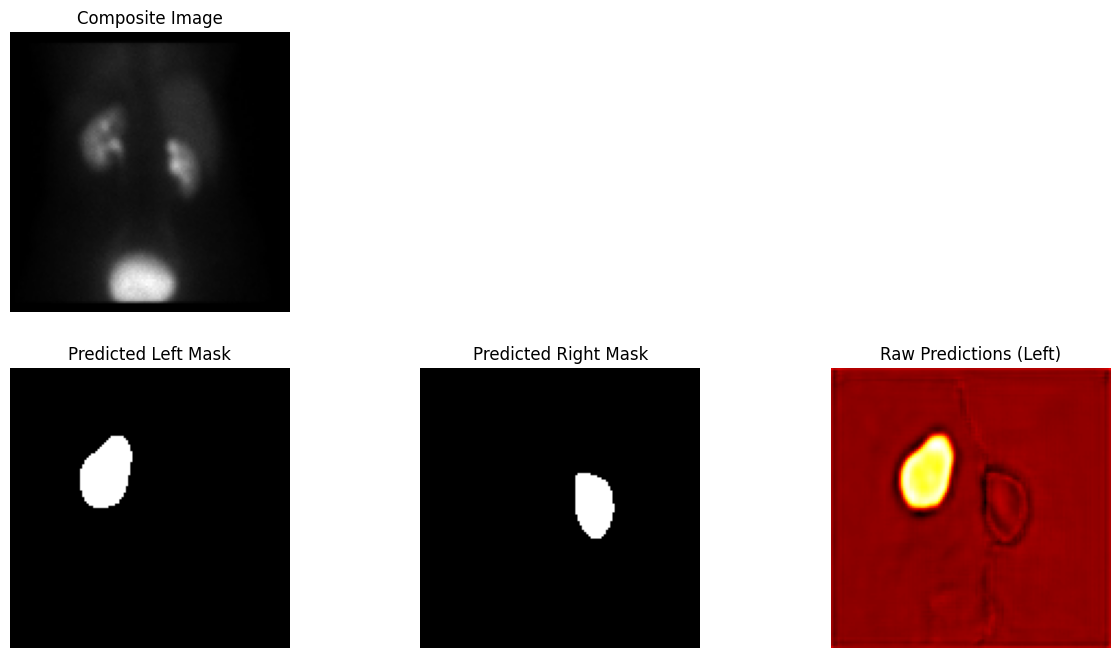

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model for a specific fold
fold_no = 1  # Set the desired fold number
model_path = f"/content/drive/My Drive/segmentation_models_test/fold_{fold_no}_pretrained_unet_model.pth"
model = torch.load(model_path, map_location=device)  # Load the entire model
model.to(device)
model.eval()

# Load composite image for drsprg_001
patient_number = "001"
img_height=128
img_width=128

composite_image_path =f"/content/drive/My Drive/composite_images/composite_image_drsprg_{patient_number}.png"

composite_image = cv2.imread(composite_image_path)
composite_image = cv2.resize(composite_image, (img_width, img_height))
composite_image = composite_image.astype(np.float32) / 255.0  # Normalize to [0, 1]


# Preprocess image for the model
image_tensor = torch.tensor(composite_image).permute(2, 0, 1).unsqueeze(0).float().to(device)

print("Image Tensor:", image_tensor.shape, image_tensor.min().item(), image_tensor.max().item())  # Debug


# Get prediction
with torch.no_grad():
  pred_masks = model(image_tensor)

  print("Raw Predictions (Min, Max):", pred_masks.min().item(), pred_masks.max().item())  # Debug

  pred_left_mask = (pred_masks[:, 0, :, :] > 0.5).cpu().numpy().squeeze()
  pred_right_mask = (pred_masks[:, 1, :, :] > 0.5).cpu().numpy().squeeze()

# Visualize the results
plt.figure(figsize=(15, 8))

# Original composite image
plt.subplot(2, 3, 1)
plt.imshow(composite_image)
plt.title('Composite Image')
plt.axis('off')

# Predicted left mask
plt.subplot(2, 3, 4)
plt.imshow(pred_left_mask, cmap='gray')
plt.title('Predicted Left Mask')
plt.axis('off')

# Predicted right mask
plt.subplot(2, 3, 5)
plt.imshow(pred_right_mask, cmap='gray')
plt.title('Predicted Right Mask')
plt.axis('off')

# Combined prediction for visualization (Optional)
plt.subplot(2, 3, 6)
combined_pred = np.maximum(pred_left_mask, pred_right_mask)  # Combine left and right masks
plt.imshow(combined_pred, cmap='gray')
plt.title('Combined Predicted Mask')
plt.axis('off')

# Visualize raw probabilities for debugging
plt.subplot(2, 3, 6)
plt.imshow(pred_masks[0, 0, :, :].cpu().numpy(), cmap='hot')
plt.title('Raw Predictions (Left)')
plt.axis('off')

plt.show()

# **Dataset analysis**

## **Side of obstruction**

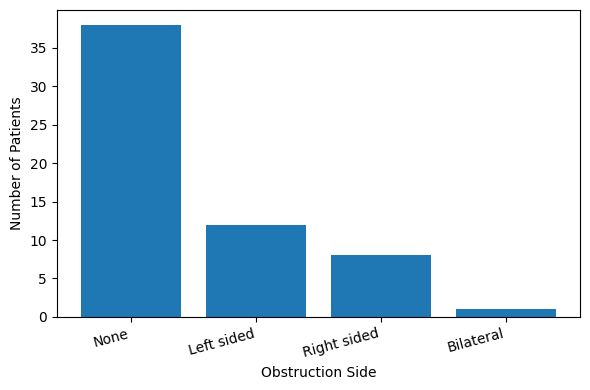

In [ ]:
def categorize_obstruction(row):
    left  = bool(row["left_kidney_label"])
    right = bool(row["right_kidney_label"])
    if left and right:
        return "Bilateral"
    elif left:
        return "Left sided"
    elif right:
        return "Right sided"
    else:
        return "None"

# 1) Read labels and compute “obstruction_side”
labels_path = os.path.join(patient_labels_uto_dir, "patient_labels_uto.csv")
labels_df = pd.read_csv(labels_path, sep=",")
labels_df["obstruction_side"] = labels_df.apply(categorize_obstruction, axis=1)

# 2) Get counts in a fixed order
order = ["None", "Left sided", "Right sided", "Bilateral"]
counts = labels_df["obstruction_side"].value_counts().reindex(order, fill_value=0)

# 3) Bar plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(counts.index, counts.values)
ax.set_xlabel("Obstruction Side")
ax.set_ylabel("Number of Patients")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()

# 4) Save (or plt.show())
fname = "side_of_obstruction_patients_bar.png"
fig.savefig(os.path.join(dataset_analysis_plots_dir, fname), dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## **Pie chart of obtruction distribution**

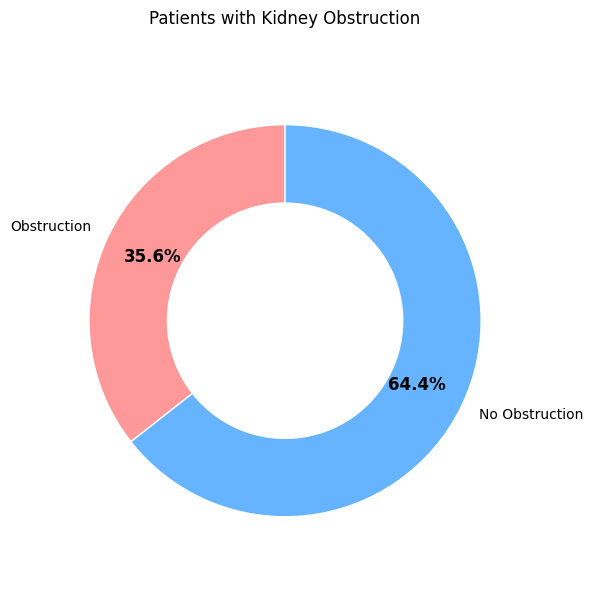

In [ ]:
# 1) Flag any patient with at least one kidney obstructed
labels_df["has_obstruction"] = (
    (labels_df["left_kidney_label"] == 1) |
    (labels_df["right_kidney_label"] == 1)
)

# 2) Count
counts = labels_df["has_obstruction"].value_counts()
sizes = [counts.get(True, 0), counts.get(False, 0)]
labels = ["Obstruction", "No Obstruction"]
colors = ["#ff9999","#66b3ff"]  # optional custom palette

# 3) Donut chart
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='w'),
    pctdistance=0.75,              # move percent labels outward
    colors=colors                  # optional
)

# draw center circle for donuthole effect
centre_circle = plt.Circle((0,0), 0.40, fc='white', linewidth=0)
ax.add_artist(centre_circle)

# styling
ax.axis("equal")  # ensure circle
plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Patients with Kidney Obstruction", y=1.05)

plt.tight_layout()

# 4) Save and show
fname_donut = "obstruction_vs_normal_kidneys_donut.png"
fig.savefig(os.path.join(dataset_analysis_plots_dir, fname_donut), dpi=150, bbox_inches='tight')
plt.show()
plt.close(fig)





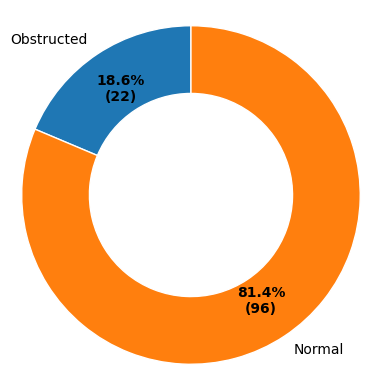

In [ ]:
# 1) Flatten labels and count
kidney_labels = labels_df[["left_kidney_label", "right_kidney_label"]].values.ravel()
unique, counts = np.unique(kidney_labels, return_counts=True)
count_map = dict(zip(unique, counts))
sizes = [count_map.get(1, 0), count_map.get(0, 0)]
labels = ["Obstructed", "Normal"]

total = sum(sizes)

# helper to show “xx.x% (n)”
def make_autopct(sizes):
    def my_autopct(pct):
        absolute = int(np.round(pct/100.*total))
        return f"{pct:.1f}%\n({absolute})"
    return my_autopct

# 3) Donut chart with counts in labels
fig, ax = plt.subplots(figsize=(4,4))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor="w"),
    pctdistance=0.75
)

# center “hole”
centre_circle = plt.Circle((0, 0), 0.40, fc="white", linewidth=0)
ax.add_artist(centre_circle)

ax.axis("equal")
plt.setp(autotexts, size=10, weight="bold")
plt.tight_layout()

# save & show
fname_donut = "obstructed_vs_non_obstructed_kidneys_donut_with_counts.png"
fig.savefig(os.path.join(dataset_analysis_plots_dir, fname_donut), dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

## **Diuretic Injection Time Spread**

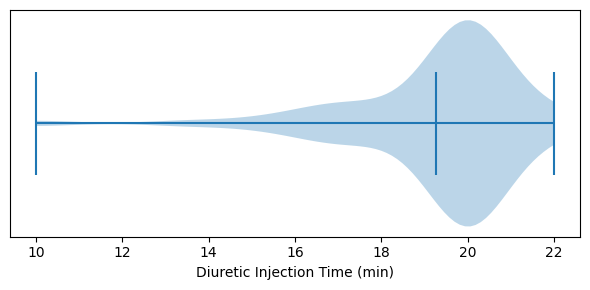

In [ ]:
# 1) Diuretic Injection Time Spread
#plt.figure(figsize=(6,4))
#plt.hist(labels_df['diuretic_time'], bins=15)
#plt.xlabel('Diuretic Injection Time (min post‐start)')
#plt.ylabel('Number of Patients')
#plt.title('Spread of Diuretic Injection Times')
#plt.tight_layout()
#plt.show()
#plt.close(fig)


# 2) Violin‐plot of the same distribution using fig, ax
fig, ax = plt.subplots(figsize=(6, 3))

parts = ax.violinplot(
    labels_df['diuretic_time'],
    showmeans=True,
    showextrema=True,
    vert=False           # ← make it horizontal


)

ax.set_xlabel('Diuretic Injection Time (min)')
ax.set_yticks([])       # hide the y‐axis ticks since it’s a single distribution

fig.tight_layout()

# save
out_fname = "diuretic_variation_horizontal.png"
out_path = os.path.join(dataset_analysis_plots_dir, out_fname)
#fig.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close(fig)



In [ ]:
def save_2_min_summed_images(patient_folders):

  # — 2-min Summed Image for One Example Patient —
  example = patient_folders[0]  # or pick a specific ID
  example_path = os.path.join(parent_dir_uto, example)
  files_ex = sorted([
      fn for fn in os.listdir(example_path)
      if re.match(file_pattern, fn)
  ])

  # load first file to get timing & data shape
  ds_first = pydicom.dcmread(os.path.join(example_path, files_ex[0]))
  if hasattr(ds_first, "NumberOfFrames"):
      arr = ds_first.pixel_array  # shape = (n_frames, H, W)
      # extract frame_time_s exactly as above
      if hasattr(ds_first, "FrameTime"):
          ft_ms = float(ds_first.FrameTime)
      else:
          ft_ms = float(ds_first.PhaseInformationSequence[0].ActualFrameDuration)
      frame_time_s = ft_ms / 1000.0
  else:
      # stack single-frame files
      arr = np.stack([
          pydicom.dcmread(os.path.join(example_path, fn)).pixel_array
          for fn in files_ex
      ])
      # assume same timing in first file
      if hasattr(ds_first, "FrameTime"):
          frame_time_s = float(ds_first.FrameTime) / 1000.0
      else:
          frame_time_s = float(ds_first.PhaseInformationSequence[0].ActualFrameDuration) / 1000.0

  # how many frames correspond to 2 minutes?
  n_sum = int(np.floor(180.0 / frame_time_s))
  total_frames = arr.shape[0]
  n_windows = total_frames // n_sum

  for i in range(n_windows):
      start_idx = i * n_sum
      end_idx   = start_idx + n_sum

      # sum this 2-min block
      sum_img = arr[start_idx:end_idx].sum(axis=0)

      # convert to time labels
      t_start = start_idx * frame_time_s
      t_end   = end_idx   * frame_time_s

      # plot & save
      fig, ax = plt.subplots(figsize=(4,4))
      ax.imshow(sum_img, cmap='gray')
      ax.axis('off')
      plt.tight_layout()

      fname = f"{example}_sum_{int(t_start)}-{int(t_end)}s.png"
      outpath = os.path.join(dataset_analysis_plots_dir, fname)
      fig.savefig(outpath, dpi=150, bbox_inches='tight')
      plt.close(fig)

  print(f"Generated {n_windows} two-minute summed images for patient {example}")

def compute_frame_count_and_frame_interval(dcm_file_path, frame_counts, frame_intervals):
    ds = pydicom.dcmread(dcm_file_path)

    # if the vendor has given us PhaseInformationSequence → variable intervals
    if hasattr(ds, "PhaseInformationSequence"):
        total_frames = 0
        for phase in ds.PhaseInformationSequence:
            # how many frames were in this phase?
            n_phase = int(phase.NumberOfFramesInPhase)
            total_frames += n_phase

            # actual duration for each of those frames, in ms
            ft_ms = float(phase.ActualFrameDuration)
            ft_s = ft_ms / 1000.0

            # record that interval once per frame
            frame_intervals.extend([ft_s] * n_phase)

        # record the exam’s total frame count
        frame_counts.append(total_frames)

    else:
        # fallback: constant interval for all frames
        # determine number of frames
        if hasattr(ds, "NumberOfFrames"):
            total_frames = int(ds.NumberOfFrames)
        else:
            raise ValueError(f"No PhaseInformationSequence or NumberOfFrames in {dcm_file_path}")

        # read the single, constant FrameTime
        if hasattr(ds, "FrameTime"):
            ft_ms = float(ds.FrameTime)
        else:
            ft_ms = float(ds.PhaseInformationSequence[0].ActualFrameDuration)
        ft_s = ft_ms / 1000.0

        # append
        frame_counts.append(total_frames)
        frame_intervals.extend([ft_s] * total_frames)


def plot_acquisition_variation(frame_counts, frame_intervals, out_dir):
    # —— 1) Histogram of frame counts ——
    fig1, ax1 = plt.subplots(figsize=(6,4))
    ax1.hist(frame_counts, bins='auto', edgecolor='k')
    ax1.set_xlabel('Number of frames per exam')
    ax1.set_ylabel('Number of exams')
    fig1.tight_layout()
    fname1 = 'frame_count_distribution.png'
    fig1.savefig(os.path.join(out_dir, fname1), dpi=300, bbox_inches='tight')
    plt.close(fig1)
    print(f"Saved frame‐count plot to {os.path.join(out_dir, fname1)}")

    # —— 2) Histogram of frame intervals ——
    fig2, ax2 = plt.subplots(figsize=(6,4))
    ax2.hist(frame_intervals, bins='auto', edgecolor='k')
    ax2.set_xlabel('Frame interval (s)')
    ax2.set_ylabel('Number of frames')
    fig2.tight_layout()
    fname2 = 'frame_interval_distribution.png'
    fig2.savefig(os.path.join(out_dir, fname2), dpi=300, bbox_inches='tight')
    plt.close(fig2)
    print(f"Saved frame‐interval plot to {os.path.join(out_dir, fname2)}")




file_pattern = r'^[A-Za-z0-9]+\.dcm$'
patient_folder_pattern = re.compile(r'^[A-Za-z0-9]+$')

patient_folders = [
    folder for folder in os.listdir(parent_dir_uto)
    if os.path.isdir(os.path.join(parent_dir_uto, folder)) and patient_folder_pattern.match(folder)
]

#print(f"Found {len(patient_folders)} patient folders: {patient_folders}")

all_activities = {}

frame_counts = []
frame_intervals = []


for patient_folder in patient_folders:
  print(f"\nProcessing patient: {patient_folder}")

  patient_folder_path = os.path.join(parent_dir_uto, patient_folder)

  print("patient_folder_path", patient_folder_path)

  dicom_files = [file for file in os.listdir(patient_folder_path) if re.match(file_pattern, file)]

  if not dicom_files:
    print(f"No DICOM files found in {patient_folder_path} matching {file_pattern}.")

  left_activities, right_activities = [], []
  time_s_list = []




  for dcm_file in dicom_files:
    dcm_file_path = os.path.join(patient_folder_path, dcm_file)
    print(f"Processing DICOM file: {dcm_file}")

    # Read the DICOM file
    #ds = pydicom.dcmread(dcm_file_path)

    #save_2_min_summed_images(patient_folders)
    compute_frame_count_and_frame_interval(dcm_file_path, frame_counts, frame_intervals)

print("frame counts", frame_counts)
print("frame intervals", frame_intervals)


plot_acquisition_variation(frame_counts, frame_intervals, dataset_analysis_plots_dir )






Processing patient: EEEFC908
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EEEFC908
Processing DICOM file: EEEFC908.dcm

Processing patient: EE590409
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EE590409
Processing DICOM file: EE590409.dcm

Processing patient: EE3D27BE
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EE3D27BE
Processing DICOM file: EE3D27BE.dcm

Processing patient: EEB35A45
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EEB35A45
Processing DICOM file: EEB35A45.dcm

Processing patient: EE3058BC
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EE3058BC
Processing DICOM file: EE3058BC.dcm

Processing patient: EE44B410
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EE44B410
Processing DICOM file: EE44B410.dcm

Processing patient: EEAFA73F
patient_folder_path /content/drive/My Drive/uto/uto_dataset/DATA_DICOM/EEAFA73F
Processing DIC

## **Plot 3-min summed frames**

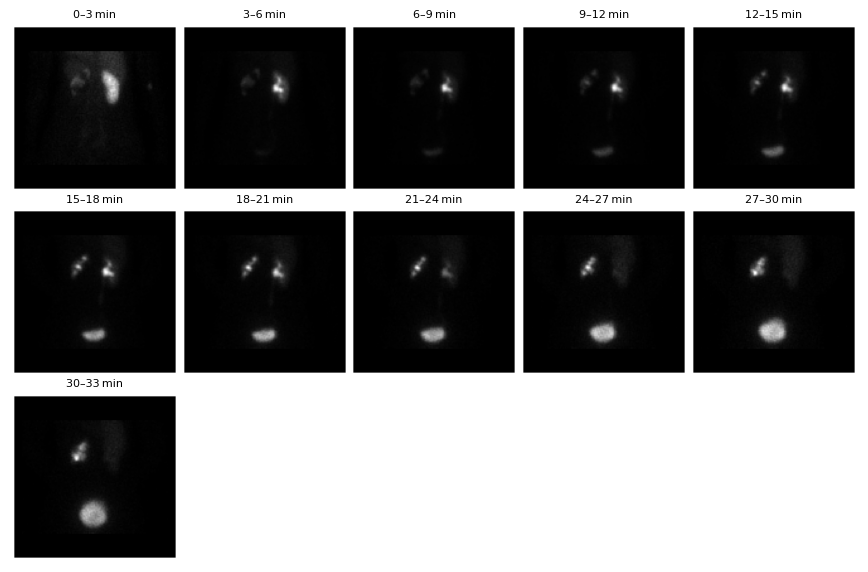

In [ ]:
import glob
from mpl_toolkits.axes_grid1 import ImageGrid



pattern = os.path.join(dataset_analysis_plots_dir, 'EEEFC908_sum_*s.png')
files = glob.glob(pattern)
n_imgs  = len(files)


# Extract the start‐time from the filename using regex
def get_start(fname):
    m = re.search(r'_sum_(\d+)-', fname)
    return int(m.group(1)) if m else 0

files = sorted(files, key=get_start)

# 2) Make the figure + grid with no padding between axes
fig = plt.figure(figsize=(12, 7))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(3, 5),
    axes_pad=(0.0, 0.15),
    share_all=True,
)

# 3) Populate the grid
for idx, ax in enumerate(grid):
    if idx < n_imgs:
        img = plt.imread(files[idx])
        ax.imshow(img, cmap='gray')

        # hide ticks & spines
        ax.axis('off')

        # compute & set title, nudged up with pad
        t0 = get_start(files[idx]) // 60
        t1 = (get_start(files[idx]) + 180) // 60
        ax.set_title(f'{t0}–{t1} min', fontsize=8, pad=4)
    else:
        # remove any extra axes entirely
        ax.set_axis_off()

# 5) Save with zero border padding
out = os.path.join(dataset_analysis_plots_dir, 'EEEFC908_tight_montage.png')
plt.savefig(out, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


# **Renogram analysis**

## **Create renograms curves over over all frames or 2 min summed frames**

Found 57 patient folders: ['EEEFC908', 'EE590409', 'EE3D27BE', 'EEB35A45', 'EE3058BC', 'EE44B410', 'EEAFA73F', 'EE4FC4E1', 'EEB87DBD', 'EE24A0C1', 'EE4FFDB2', 'EEDFDFCD', 'EEB783E2', 'EEC10770', 'EED2DD92', 'EE642661', 'EEB9ECD4', 'EE0DAEDE', 'EED550DA', 'EEF9C7F3', 'EEA9C613', 'EE533BD0', 'EED7A564', 'EE4647AB', 'EE5D0C3A', 'EEA8F6C4', 'EE385B28', 'EE95E869', 'EEF913D1', 'EEC5F13F', 'EE980452', 'EE346720', 'EED7A1C2', 'EE39ABA9', 'EEBA2A04', 'EEC2B75F', 'EE45E53E', 'EE1975D9', 'EE8501C5', 'EE7F1401', 'EE0013BF', 'EE4922B9', 'EEC00649', 'EE426122', 'EEF61EF2', 'EEFE2D7F', 'EE131960', 'EE19A538', 'EE9B3CBC', 'EEECEFC3', 'EE467060', 'EED140BF', 'EE72CBC2', 'EEE5AD94', 'EE27217F', 'EE86FF3A', 'EEB056B3']

Processing patient: EEEFC908
Processing DICOM file: EEEFC908.dcm

Processing patient: EE590409
Processing DICOM file: EE590409.dcm

Processing patient: EE3D27BE
Processing DICOM file: EE3D27BE.dcm

Processing patient: EEB35A45
Processing DICOM file: EEB35A45.dcm

Processing patient: EE30

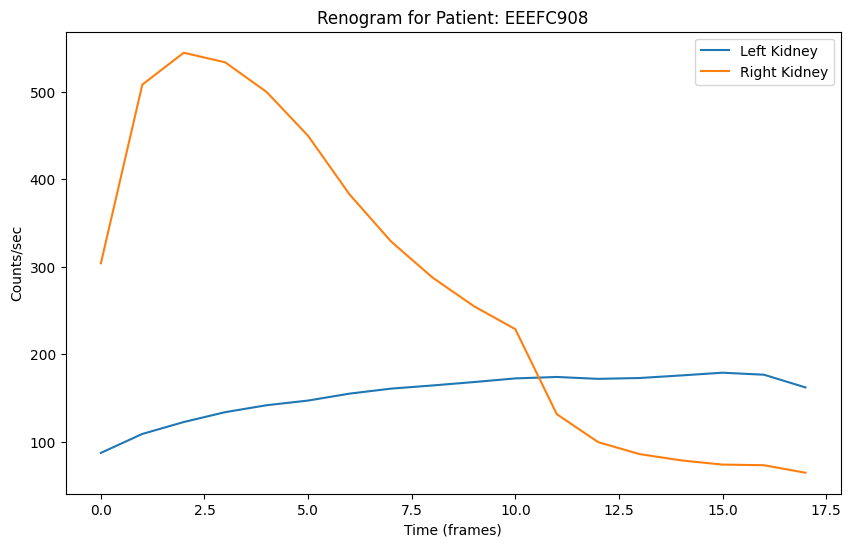

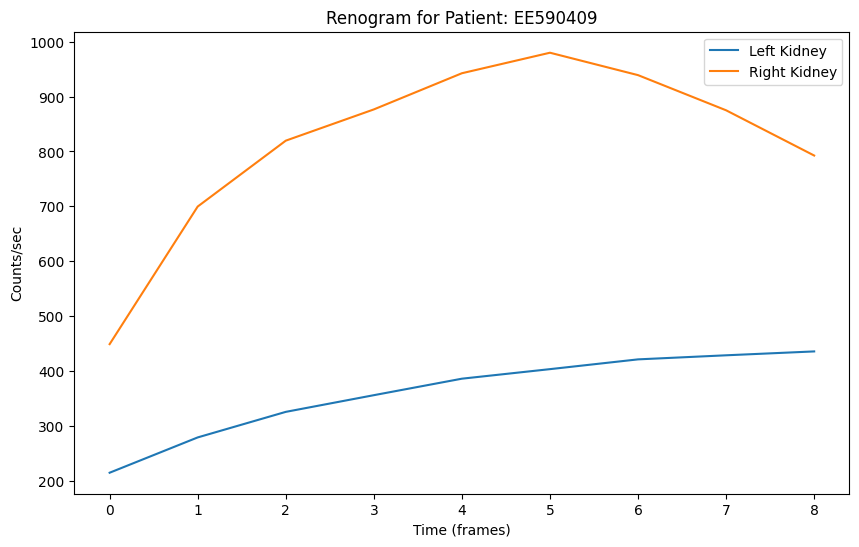

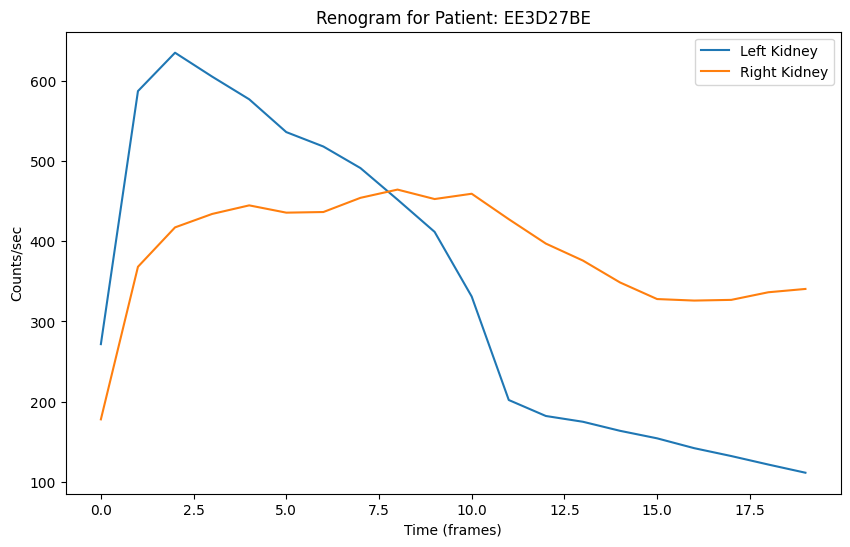

Saved renogram dataset to path /content/drive/MyDrive/uto/activity_curve_datasets/kidney_activity_dataset_2_min_summed_uto.npz


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

file_pattern = r'^[A-Za-z0-9]+\.dcm$'
patient_folder_pattern = re.compile(r'^[A-Za-z0-9]+$')

patient_folders = [
    folder for folder in os.listdir(parent_dir_uto)
    if os.path.isdir(os.path.join(parent_dir_uto, folder)) and patient_folder_pattern.match(folder)
]


print(f"Found {len(patient_folders)} patient folders: {patient_folders}")

all_activities = {}


for patient_folder in patient_folders:
  print(f"\nProcessing patient: {patient_folder}")

  patient_folder_path = os.path.join(parent_dir_uto, patient_folder)

  #Handling left and right rois seperatly
  left_roi_path = os.path.join(kidney_rois_uto_dir, f"left_kidney_mask_{patient_folder}.png")
  right_roi_path = os.path.join(kidney_rois_uto_dir, f"right_kidney_mask_{patient_folder}.png")

  if not os.path.exists(left_roi_path) or not os.path.exists(right_roi_path):
    print(f"One or both kidney ROIs not found for {patient_folder}. Skipping.")
    continue

  # Load the kidney ROIs
  left_kidney_roi = load_image(left_roi_path)
  right_kidney_roi = load_image(right_roi_path)

  create_renograms_summed_raw(patient_folder_path, file_pattern, patient_folder, left_kidney_roi, right_kidney_roi, all_activities)

#Print for validation
selected_patients = list(all_activities.keys())[:3]

for patient in selected_patients:
    activity = all_activities[patient]
    # Create an x-axis array (assuming the curve length is the number of time points)
    time = np.arange(len(activity["left"]))

    plt.figure(figsize=(10, 6))
    plt.plot(time, activity["left"], label="Left Kidney")
    plt.plot(time, activity["right"], label="Right Kidney")

    plt.title(f"Renogram for Patient: {patient}")
    plt.xlabel("Time (frames)")
    plt.ylabel("Counts/sec")
    plt.legend()
    plt.show()

#Save renogram dataset as a dictionary to disk
output_dataset_path = '/content/drive/MyDrive/uto/activity_curve_datasets/kidney_activity_dataset_2_min_summed_uto.npz'
np.savez(output_dataset_path, **all_activities)

print(f"Saved renogram dataset to path {output_dataset_path}")


## **Model training**

### **Prepare training data**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


# Fix random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

training_mode = "datapoint"
feature_set="all"
curve_phase="whole"

TARGET_LEN_WHOLE   = 220
TARGET_LEN_DIURETIC = 120
TARGET_LEN_2_MIN_SUMMED = 20


smoothed_curves_out_dir = '/content/drive/MyDrive/uto/smoothed_renograms'

#Read renogram dataset from disk
output_dataset_path = '/content/drive/MyDrive/uto/activity_curve_datasets/kidney_activity_dataset_raw_uto.npz'
activities = np.load(output_dataset_path, allow_pickle=True)
activities = {key: activities[key].tolist() for key in activities.files}


# Read labels from csv (with two labels per patient: one for each kidney)
labels_path = os.path.join(patient_labels_uto_dir, 'patient_labels_uto.csv')
labels_df = pd.read_csv(labels_path, sep=',')

patient_labels = {
    row['patient_folder']: (row['left_kidney_label'], row['right_kidney_label'], row['diuretic_time'])
    for _, row in labels_df.iterrows()
}

# Create dataset with one kidney curve per training sample
dataset = RenogramDatasetUTO(activities, patient_labels, dicom_dir=parent_dir_uto)

data_loader = DataLoader(dataset, batch_size=len(dataset), collate_fn=custom_collate_fn)
X_raw, y, diuretic_times, patient_folders, time_vectors = prepare_training_data(data_loader, training_mode)

#print("time_vectors", time_vectors)

#Cubic smooth to reduce noise
X = cubic_smooth_curves(X_raw, time_vectors)

orig_time_vectors = list(time_vectors)       # make a copy of the list
orig_X_smooth     = [c.clone() if torch.is_tensor(c) else c.copy()
                     for c in X]      # list of tensors/arrays
orig_X_raw        = [c.clone() if torch.is_tensor(c) else c.copy()
                     for c in X_raw]

#plot_raw_vs_smoothed_curves(X_raw, X, time_vectors, patient_folders, diuretic_times, smoothed_curves_out_dir)

#plot_renograms_patient(X, y, patient_folders, time_vectors)

#print("X[0]", X[0])


t_half_dict  = {}   # maps "patientID_left"/"patientID_right" → T₁/₂ value
y_true_dict  = {}   # maps same keys → true label (0 or 1)
pid_counts   = {}   # to ensure left/right keys don’t overwrite


if training_mode == "datapoint":
  resampled_seqs = []
  resampled_tvs  = []
  if curve_phase == "whole":
    # interpolate every full curve to TARGET_LEN_WHOLE
    for seq, t_vec in zip(X, time_vectors):
        # to numpy
        seq_np = seq.numpy() if torch.is_tensor(seq) else np.array(seq, dtype=float)
        # build interpolant on original minutes-grid
        f = interp1d(t_vec, seq_np, kind='linear', fill_value='extrapolate')
        # new uniform grid
        new_t = np.linspace(t_vec[0], t_vec[-1], TARGET_LEN_WHOLE)
        new_seq = f(new_t)
        resampled_seqs.append(torch.tensor(new_seq, dtype=torch.float32))
        resampled_tvs.append(new_t)


  if curve_phase == "diuretic":
    # crop to diuretic phase then interpolate
    for seq, t_vec, dt in zip(X, time_vectors, diuretic_times):
        seq_np = seq.numpy() if torch.is_tensor(seq) else np.array(seq, dtype=float)
        # find where diuretic injection starts
        start_i = int(np.searchsorted(t_vec, dt))
        diu_seq = seq_np[start_i:]
        diu_t   = t_vec[start_i:]
        # now interpolate that segment
        f = interp1d(diu_t, diu_seq, kind='linear', fill_value='extrapolate')
        new_t = np.linspace(diu_t[0], diu_t[-1], TARGET_LEN_DIURETIC)
        new_seq = f(new_t)
        resampled_seqs.append(torch.tensor(new_seq, dtype=torch.float32))
        resampled_tvs.append(new_t)

  X = torch.stack(resampled_seqs, dim=0)
  time_vectors = resampled_tvs

if training_mode == "feature":
  for curve, t_vec, dt, pid_base, true_label in zip(X, time_vectors, diuretic_times, patient_folders, y):
    th = compute_t_half(curve, t_vec, dt)

    # 2) Create a unique key per kidney (append "_left" or "_right")
    count = pid_counts.get(pid_base, 0) + 1
    pid_counts[pid_base] = count
    if count == 1:
        key = f"{pid_base}_left"
    elif count == 2:
        key = f"{pid_base}_right"
    else:
        key = f"{pid_base}_{count}"

    # 3) Store
    t_half_dict[key] = th
    y_true_dict[key] = int(true_label)


print(f"Computed T₁/₂ for {len(t_half_dict)} kidneys ({len(pid_counts)} patients).")

# --- 1) Gather keys and build arrays ---
all_keys    = list(t_half_dict.keys())    # insertion order of your dict
t_half_list = [t_half_dict[k] for k in all_keys]
y_true_list = [y_true_dict[k] for k in all_keys]

# 2) Replace NaN with a large placeholder (so NaN -> “high half-time”)
finite_vals = [v for v in t_half_list if not np.isnan(v)]
if finite_vals:
    nan_sub = max(finite_vals) + 1.0
else:
    nan_sub = 1.0
t_half_scores = [ (v if not np.isnan(v) else nan_sub) for v in t_half_list ]

# Convert to arrays
y_true_arr  = np.array(y_true_list, dtype=int)
t_half_arr  = np.array(t_half_scores, dtype=float)

# 3) Compute ROC curve & AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresh = roc_curve(y_true_arr, t_half_arr, pos_label=1)
roc_auc = auc(fpr, tpr)

# 4) Plot ROC curve with matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], lw=1, linestyle="--", label="Chance level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC‐AUC (continuous T₁/₂): {roc_auc:.3f}")

# 2) Compute Youden's index and find the best cutoff
youden        = tpr - fpr
best_idx      = np.argmax(youden)
best_tau      = thresh[best_idx]
best_sens     = tpr[best_idx]
best_spec     = 1.0 - fpr[best_idx]
best_youden   = youden[best_idx]

print(f"Youden’s J max at τ = {best_tau:.2f} min")
print(f"  → Sensitivity = {best_sens:.3f}")
print(f"  → Specificity = {best_spec:.3f}")
print(f"  → Youden’s J  = {best_youden:.3f}")


# -----------------------------
# (D) Now sweep through multiple thresholds τ
# -----------------------------
thresholds = list(range(5, 21))  # [6, 7, 8, …, 14] minutes
#results    = pd.DataFrame(
  #  index=thresholds, columns=["accuracy", "precision", "recall", "f1"]
#)

results    = pd.DataFrame(
    index=thresholds,
    columns=["accuracy", "precision", "recall", "f1", "fnr", "fpr", "specificity"]
)

for τ in thresholds:
    y_true_list = []
    y_pred_list = []
    for key, th in t_half_dict.items():
        true_label = y_true_dict[key]

        # If th is NaN OR th > τ, predict 1 (obstructed); else 0 (normal)
        if np.isnan(th) or th > τ:
            pred = 1
        else:
            pred = 0

        y_true_list.append(true_label)
        y_pred_list.append(pred)

    y_true_arr = np.array(y_true_list, dtype=int)
    y_pred_arr = np.array(y_pred_list, dtype=int)

    # Compute metrics
    acc  = accuracy_score(y_true_arr, y_pred_arr)
    prec = precision_score(y_true_arr, y_pred_arr, zero_division=0)
    rec  = recall_score(y_true_arr, y_pred_arr, zero_division=0)
    f1   = f1_score(y_true_arr, y_pred_arr, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true_arr, y_pred_arr, labels=[0,1]).ravel()

    # (c) Compute FNR, FPR, Specificity
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    results.loc[τ] = [acc, prec, rec, f1, fnr, fpr, spec]

# Print the sweep table
print("\n=== T₁/₂ Threshold Sweep (pre‐diuretic) ===")
print(results)

# Which τ gives best F₁?
best_tau = results["f1"].astype(float).idxmax()
best_f1  = results.loc[best_tau, "f1"]
print(f"\nBest F₁ is {best_f1:.3f} at τ = {best_tau} minutes.")


print(f"=== Full classification report at τ = {best_tau} min ===")
y_true_best = []
y_pred_best = []

for key, th in t_half_dict.items():
    true_label = y_true_dict[key]
    if np.isnan(th) or (th >= best_tau):
        pred = 1
    else:
        pred = 0
    y_true_best.append(true_label)
    y_pred_best.append(pred)

y_true_best = np.array(y_true_best, dtype=int)
y_pred_best = np.array(y_pred_best, dtype=int)

print("Accuracy :", accuracy_score(y_true_best, y_pred_best))
print("Precision:", precision_score(y_true_best, y_pred_best, zero_division=0))
print("Recall   :", recall_score(y_true_best, y_pred_best, zero_division=0))
print("F1 Score :", f1_score(y_true_best, y_pred_best, zero_division=0))

# Confusion matrix & derived metrics
tn, fp, fn, tp = confusion_matrix(y_true_best, y_pred_best, labels=[0,1]).ravel()
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(f"FNR       : {fnr:.3f}")
print(f"FPR       : {fpr:.3f}")
print(f"Specificity: {spec:.3f}\n")

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true_best, y_pred_best))
print("\nFull classification report:")
print(classification_report(y_true_best, y_pred_best, zero_division=0))













    #X = extract_features_matrix(X, diuretic_times, patient_folders, time_vectors, feature_set=feature_set)

#for i in range(10):
 # print(f"Row {i}:")
 # print(" Curve length", len(X[i]))
 # print("  Kidney curve:", X[i])
 # print("  Label:", y[i])
 # print("  Patient:", patient_folders[i])
 # print("  Diuretic time:", diuretic_times[i])

 # fnr = make_scorer(fnr_score)
 # specificity = make_scorer(specificity_score)
 # fpr = make_scorer(fpr_score)

 # scoring = {
  #  'accuracy':  'accuracy',
  #  'precision': 'precision',
  #  'f1':        'f1',
  #  'roc_auc':   'roc_auc',
  #  'recall':    'recall',
  #  'fnr':       fnr,
  #  'fpr':       fpr,
  #  'specificity': specificity
#}


# Augment only the training data (original training data)
#augmented_X, augmented_y = prepare_augmented_data(X_train, y_train)
#print("Augmented training samples:", augmented_X.shape[0])

# Combine original training data with augmented training data
#X_train = np.concatenate([X_train, augmented_X], axis=0)
#y_train = np.concatenate([y_train, augmented_y], axis=0)
#print("Total training samples after augmentation:", X_train.shape[0])

#sample_index = 1
#plot_augmented_curves(X[sample_index], y[sample_index], num_augments=2)




Computed T₁/₂ for 0 kidneys (0 patients).


IndexError: cannot do a non-empty take from an empty axes.

### **Support vector machine**

In [ ]:
# 1) Build a pipeline: scaler + SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=SEED, class_weight='balanced'))
])

# 2) Parameter grid: prefix with 'svm__'
param_grid = {
    'svm__C':      [0.1, 1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma':  ['scale', 'auto'],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_search_svm = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',      # or you could pick 'f1' or any single metric
    verbose=2,
    n_jobs=-1,
    return_train_score=False,
)

grid_search_svm.fit(X, y)

print("Best params:", grid_search_svm.best_params_)
best_svm_model = grid_search_svm.best_estimator_

# 3) Get all your CV metrics at once
cv_results_svm = cross_validate(
    best_svm_model,
    X, y,
    cv=skf,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring:
    scores = cv_results_svm[f'test_{metric}']
    print(f"{metric:9s} → mean: {scores.mean():.3f}  std: {scores.std():.3f}")


training_data_svm_save_path = f"/content/drive/MyDrive/uto/models/svm_models/datapoints/svm_best_training_data.npy"
scaler_save_path = os.path.join(svm_model_dir, "scaler_raw.joblib")
svm_model_save_path_total = os.path.join(svm_model_dir, f"svm_best_model_raw.joblib")

#dump(best_svm_model, svm_model_save_path_total)
#np.save(training_data_svm_save_path, X)
#dump(scaler, scaler_save_path)

calculate_and_save_evaluation_metrics(cv_results_svm, evaluation_metrics_results_svm, grid_search_svm.best_params_)




Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
accuracy  → mean: 0.921  std: 0.033
precision → mean: 0.950  std: 0.100
f1        → mean: 0.749  std: 0.102
roc_auc   → mean: 0.945  std: 0.044
recall    → mean: 0.630  std: 0.125
fnr       → mean: 0.370  std: 0.125
fpr       → mean: 0.011  std: 0.022
specificity → mean: 0.989  std: 0.022
Metrics and hyperparameters saved


### **Decision tree**

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=SEED)

# 3) Hyperparameter grid (no prefix needed if not in a Pipeline)
param_grid_dt = {
    "max_depth": [3, 5, 7],  # Reduce complexity
    "min_samples_split": [2, 5],  # Fewer options
    "min_samples_leaf": [1, 2]  # Smaller range
}

# 4) 5‑fold splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 5) GridSearchCV on the full dataset
grid_search_dt = GridSearchCV(
    dt,
    param_grid_dt,
    cv=skf,
    scoring='accuracy',   # you can choose any one metric to optimize
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)
grid_search_dt.fit(X, y)

print("Best DT params:", grid_search_dt.best_params_)
best_dt_model = grid_search_dt.best_estimator_

# 6) Cross‑validate the best tree for all metrics
cv_results_dt = cross_validate(
    best_dt_model,
    X, y,
    cv=skf,
    scoring=scoring,
    return_train_score=False

)

# 7) Print per‑metric means ± stds
for metric in scoring:
    scores = cv_results_dt[f'test_{metric}']
    print(f"{metric:9s} → mean: {scores.mean():.3f}  std: {scores.std():.3f}")


model_save_path = f"/content/drive/MyDrive/uto/models/dt_models/dt_model_best.joblib"
training_data_save_path = f"/content/drive/MyDrive/uto/models/dt_models/dt_training_data_best.npy"

save_training_data_and_model(model_save_path, training_data_save_path, best_dt_model, X)
calculate_and_save_evaluation_metrics(cv_results_dt, evaluation_metrics_results_dt, grid_search_dt.best_params_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best DT params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy  → mean: 0.868  std: 0.048
precision → mean: 0.703  std: 0.169
f1        → mean: 0.619  std: 0.170
roc_auc   → mean: 0.749  std: 0.128
recall    → mean: 0.600  std: 0.226
fnr       → mean: 0.400  std: 0.226
fpr       → mean: 0.066  std: 0.042
specificity → mean: 0.934  std: 0.042
Model saved successfully at /content/drive/MyDrive/uto/models/dt_models/dt_model_best.joblib
Training data saved sucessfully at /content/drive/MyDrive/uto/models/dt_models/dt_training_data_best.npy
Metrics and hyperparameters saved


### **XGBOOST**

In [ ]:
# 2) Compute scale_pos_weight from y
counter = Counter(y)
n_neg = counter[0]
n_pos = counter[1]
scale_pos_weight = n_neg / n_pos

# 3) Define XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=SEED,
    use_label_encoder=False,   # newer XGBoost versions
    eval_metric='logloss',     # shuts off warning
    scale_pos_weight=scale_pos_weight
)

# 4) Hyperparameter grid
param_grid_xgb = {
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'n_estimators':     [50, 100, 200],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 5) 5‑fold splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 6) GridSearchCV on full X, y
grid_search_xgb = GridSearchCV(
    xgb,
    param_grid=param_grid_xgb,
    cv=skf,
    scoring='accuracy',    # pick your main metric here
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)
grid_search_xgb.fit(X, y)

print("Best XGB params:", grid_search_xgb.best_params_)
best_xgb_model = grid_search_xgb.best_estimator_

# 7) Cross‑validate best model for all metrics
cv_results_xgb = cross_validate(
    best_xgb_model,
    X, y,
    cv=skf,
    scoring=scoring,
    return_train_score=False
)

# 8) Summarize
for metric in scoring:
    scores = cv_results_xgb[f'test_{metric}']
    print(f"{metric:9s} → mean: {scores.mean():.3f}  std: {scores.std():.3f}")

model_save_path = f"/content/drive/MyDrive/uto/models/xgboost_models/xgboost_best.joblib"
training_data_save_path = f"/content/drive/MyDrive/uto/models/xgboost_models/xgboost_training_data_best.npy"

save_training_data_and_model(model_save_path, training_data_save_path, best_xgb_model, X)
calculate_and_save_evaluation_metrics(cv_results_xgb, evaluation_metrics_results_xgboost, grid_search_xgb.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
accuracy  → mean: 0.948  std: 0.051
precision → mean: 0.883  std: 0.145
f1        → mean: 0.867  std: 0.117
roc_auc   → mean: 0.903  std: 0.092
recall    → mean: 0.860  std: 0.116
fnr       → mean: 0.140  std: 0.116
fpr       → mean: 0.033  std: 0.044
specificity → mean: 0.967  std: 0.044
Model saved successfully at /content/drive/MyDrive/uto/models/xgboost_models/xgboost_best.joblib
Training data saved sucessfully at /content/drive/MyDrive/uto/models/xgboost_models/xgboost_training_data_best.npy
Metrics and hyperparameters saved


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

### **Random Forest**

In [ ]:
rf = RandomForestClassifier(class_weight="balanced", random_state=SEED)

# Hyperparameter tuning
param_grid_rf = {
    "n_estimators": [50, 100, 200],  # Number of trees in the forest
    "max_depth": [None, 3, 5, 10, 15],  # Tree depth
    "min_samples_split": [2, 5, 10],  # Minimum samples for splitting a node
    "min_samples_leaf": [1, 2, 5],  # Minimum samples for a leaf node
    "max_features": ["sqrt", "log2"],  # Number of features per split
    "bootstrap": [True, False]  # Whether to use bootstrap sampling
}


# Perform Grid Search with Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 6) GridSearchCV on full X, y
grid_search_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,
    cv=skf,
    scoring='accuracy',    # pick your main metric here
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)
grid_search_rf.fit(X, y)

best_params = grid_search_rf.best_params_
best_rf    = grid_search_rf.best_estimator_

fold_metrics = []
all_metrics  = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    # re-instantiate & train on this fold
    model = clone(best_rf).set_params(**best_params)
    model.fit(X[train_idx], y[train_idx])

    # get true & predicted
    y_true  = y[test_idx]
    y_pred  = model.predict(X[test_idx])
    y_score = model.predict_proba(X[test_idx])[:,1]

    # compute standard metrics
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred)
    rec   = recall_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred)
    roc   = auc(*roc_curve(y_true, y_score)[:2])

    # collect for averaging
    for name,val in zip(['accuracy','precision','recall','f1','roc_auc'],
                        [acc,prec,rec,f1,roc, y]):
        all_metrics[name].append(val)

    # store per‐fold detail + raw curves
    fpr, tpr, thr = roc_curve(y_true, y_score)
    fold_metrics.append({
        'fold':       fold,
        'accuracy':   acc,
        'precision':  prec,
        'recall':     rec,
        'f1':         f1,
        'roc_auc':    roc,
        'fpr':        fpr.tolist(),
        'tpr':        tpr.tolist(),
        'thresholds': thr.tolist(),
        'y_true':     y_true.tolist(),
        'y_score':    y_score.tolist()
    })

# compute averages
average_metrics = { name: float(np.mean(vals)) for name,vals in all_metrics.items() }

# package everything
results = {
    'fold_metrics':    fold_metrics,
    'average_metrics': average_metrics,
    'hyperparameters': { **best_params, 'voting': 'n/a (single model)' }
}

model_save_path = f"/content/drive/MyDrive/uto/models/rf_models/rf_model_best.joblib"
training_data_save_path = f"/content/drive/MyDrive/uto/models/rf_models/rf_training_data_best.npy"

save_training_data_and_model(model_save_path, training_data_save_path, best_rf, X)


# save to your drive
out_path = "/content/drive/MyDrive/uto/models/rf_models/rf_evaluation.json"
with open(out_path, 'w') as f:
    json.dump(results, f, indent=2)






Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Model saved successfully at /content/drive/MyDrive/uto/models/rf_models/rf_model_best.joblib
Training data saved sucessfully at /content/drive/MyDrive/uto/models/rf_models/rf_training_data_best.npy


### **KNN**

In [ ]:
# 2) Build a Pipeline (scale → KNN)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn',    KNeighborsClassifier())
])

# 3) Hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 10, 15],
    'knn__weights':    ['uniform', 'distance']
}

# 4) 5-fold splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 5) GridSearchCV on the *entire* dataset
grid_search_knn = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',   # or whichever single metric you want to optimize
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)
grid_search_knn.fit(X, y)

best_params = grid_search_knn.best_params_
best_knn    = grid_search_knn.best_estimator_

fold_metrics = []
all_metrics  = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    # re-instantiate & train on this fold
    model = clone(best_knn).set_params(**best_params)
    model.fit(X[train_idx], y[train_idx])

    # get true & predicted
    y_true  = y[test_idx]
    y_pred  = model.predict(X[test_idx])
    y_score = model.predict_proba(X[test_idx])[:,1]

    # compute standard metrics
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred)
    rec   = recall_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred)
    roc   = auc(*roc_curve(y_true, y_score)[:2])

    # collect for averaging
    for name,val in zip(['accuracy','precision','recall','f1','roc_auc'],
                        [acc,prec,rec,f1,roc]):
        all_metrics[name].append(val)

    # store per‐fold detail + raw curves
    fpr, tpr, thr = roc_curve(y_true, y_score)
    fold_metrics.append({
        'fold':       fold,
        'accuracy':   acc,
        'precision':  prec,
        'recall':     rec,
        'f1':         f1,
        'roc_auc':    roc,
        'fpr':        fpr.tolist(),
        'tpr':        tpr.tolist(),
        'thresholds': thr.tolist(),
        'y_true':     y_true.tolist(),
        'y_score':    y_score.tolist()
    })

# compute averages
average_metrics = { name: float(np.mean(vals)) for name,vals in all_metrics.items() }

# package everything
results = {
    'fold_metrics':    fold_metrics,
    'average_metrics': average_metrics,
    'hyperparameters': { **best_params, 'voting': 'n/a (single model)' }
}


model_save_path = f"/content/drive/MyDrive/uto/models/knn_models/knn_model_best_summed.joblib"
training_data_save_path = f"/content/drive/MyDrive/uto/models/knn_models/knn_training_data_summed_best.npy"

save_training_data_and_model(model_save_path, training_data_save_path, best_knn, X)

# save to your drive
out_path = "/content/drive/MyDrive/uto/models/knn_models/knn_evaluation_summed.json"
with open(out_path, 'w') as f:
    json.dump(results, f, indent=2)


np.save("/content/drive/MyDrive/uto/models/knn_models/knn_training_data_timevecs.npy", np.vstack(resampled_tvs))








Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model saved successfully at /content/drive/MyDrive/uto/models/knn_models/knn_model_best_summed.joblib
Training data saved sucessfully at /content/drive/MyDrive/uto/models/knn_models/knn_training_data_summed_best.npy


### **MLP**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from itertools import product


class MLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(MLP, self).__init__()

        self.dropout_rate = dropout_rate

        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.output(x)
        return x


def train_mlp(model, train_loader, test_loader, epochs=100, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()

        train_acc = correct / total

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}")

    print("\nTraining Complete!")


def evaluate_mlp(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_labels = []
    all_preds = []
    all_pred_probs = []  # For ROC-AUC

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Compute probabilities using softmax
            probabilities = torch.softmax(outputs, dim=1)
            # For binary classification, use the probability of the positive class
            all_pred_probs.extend(probabilities[:, 1].cpu().numpy())

            # Get predicted labels using argmax
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_pred_probs = np.array(all_pred_probs)

    # Compute metrics using sklearn functions
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_pred_probs)

    # Compute confusion matrix and derive FNR: FNR = FN / (FN + TP)
    cm = confusion_matrix(all_labels, all_preds)
    # Make sure we have a binary confusion matrix (assume cm = [[TN, FP], [FN, TP]])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0  # In case something unexpected happens

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Optionally, print out the metrics
    print("\nTest Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"FNR:       {fnr:.4f}")

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1,
        'roc_auc': roc_auc,
        'recall': recall,
        'fnr': fnr,
        'fpr': fpr,
        'specificity': tnr
    }

    return metrics


X_np = np.array(X)
y_np = np.array(y)

# Hyperparameter grids
batch_sizes = [16, 32]
dropouts    = [0.2, 0.3]
lrs         = [1e-3, 5e-4]


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
best_avg_acc = 0
best_params   = None
epochs = 100


for batch_size, dropout, lr in product(batch_sizes, dropouts, lrs):
    print(f"\nTesting combination: batch_size={batch_size}, dropout={dropout}, lr={lr}")
    fold_metrics = []

    # Five-fold cross validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):

        # reproducibility
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        random.seed(SEED)

        # split data
        X_tr, y_tr = X[train_idx], y[train_idx]
        X_va, y_va = X[val_idx], y[val_idx]

        # to tensors and loaders
        train_ds = TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                                 torch.tensor(y_tr, dtype=torch.long))
        val_ds   = TensorDataset(torch.tensor(X_va, dtype=torch.float32),
                                 torch.tensor(y_va, dtype=torch.long))
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        # init model with dropout
        model = MLP(input_dim=X.shape[1], dropout_rate=dropout)
        train_mlp(model, train_loader, val_loader, epochs=epochs, lr=lr)
        metrics = evaluate_mlp(model, val_loader)
        fold_metrics.append(metrics)

    # average accuracy over folds
    fold_accuracies = [m['accuracy'] for m in fold_metrics]
    avg_acc = np.mean(fold_accuracies)
    print(f"Avg CV accuracy: {avg_acc:.4f}")

    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_params  = {'batch_size': batch_size,
                        'dropout':    dropout,
                        'lr':         lr}


save_filepath = "/content/drive/MyDrive/uto/models/mlp_models/evaluation_metrics.json"

save_fold_metrics_pytorch(fold_metrics, save_filepath, best_params)




Testing combination: batch_size=16, dropout=0.2, lr=0.001
Epoch [1/100], Loss: 3.6327, Train Acc: 0.5250
Epoch [2/100], Loss: 3.2930, Train Acc: 0.5875
Epoch [3/100], Loss: 3.2027, Train Acc: 0.6875
Epoch [4/100], Loss: 3.0392, Train Acc: 0.7250
Epoch [5/100], Loss: 2.8554, Train Acc: 0.8125
Epoch [6/100], Loss: 2.7469, Train Acc: 0.7875
Epoch [7/100], Loss: 2.7727, Train Acc: 0.8125
Epoch [8/100], Loss: 2.6200, Train Acc: 0.8250
Epoch [9/100], Loss: 2.5136, Train Acc: 0.8125
Epoch [10/100], Loss: 2.6478, Train Acc: 0.7875
Epoch [11/100], Loss: 2.3548, Train Acc: 0.8250
Epoch [12/100], Loss: 2.4135, Train Acc: 0.8250
Epoch [13/100], Loss: 2.3543, Train Acc: 0.8375
Epoch [14/100], Loss: 2.1622, Train Acc: 0.8500
Epoch [15/100], Loss: 2.3830, Train Acc: 0.8125
Epoch [16/100], Loss: 2.3074, Train Acc: 0.8250
Epoch [17/100], Loss: 2.2814, Train Acc: 0.8125
Epoch [18/100], Loss: 2.2903, Train Acc: 0.8125
Epoch [19/100], Loss: 2.2258, Train Acc: 0.8000
Epoch [20/100], Loss: 2.1170, Train Ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/100], Loss: 2.4406, Train Acc: 0.7875
Epoch [9/100], Loss: 2.3951, Train Acc: 0.8125
Epoch [10/100], Loss: 2.5543, Train Acc: 0.7625
Epoch [11/100], Loss: 2.3144, Train Acc: 0.8125
Epoch [12/100], Loss: 2.1314, Train Acc: 0.8625
Epoch [13/100], Loss: 2.2963, Train Acc: 0.8375
Epoch [14/100], Loss: 2.2855, Train Acc: 0.8250
Epoch [15/100], Loss: 2.3119, Train Acc: 0.8125
Epoch [16/100], Loss: 2.1403, Train Acc: 0.8625
Epoch [17/100], Loss: 2.3483, Train Acc: 0.8250
Epoch [18/100], Loss: 2.2681, Train Acc: 0.8125
Epoch [19/100], Loss: 2.4751, Train Acc: 0.7875
Epoch [20/100], Loss: 2.1433, Train Acc: 0.8375
Epoch [21/100], Loss: 2.1895, Train Acc: 0.8375
Epoch [22/100], Loss: 2.2941, Train Acc: 0.8000
Epoch [23/100], Loss: 2.1819, Train Acc: 0.8500
Epoch [24/100], Loss: 2.4311, Train Acc: 0.8375
Epoch [25/100], Loss: 2.3702, Train Acc: 0.8000
Epoch [26/100], Loss: 2.3659, Train Acc: 0.8125
Epoch [27/100], Loss: 2.2187, Train Acc: 0.8000
Epoch [28/100], Loss: 2.2567, Train Acc: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/100], Loss: 2.2368, Train Acc: 0.8125
Epoch [20/100], Loss: 2.0727, Train Acc: 0.8500
Epoch [21/100], Loss: 2.0675, Train Acc: 0.8250
Epoch [22/100], Loss: 2.2463, Train Acc: 0.8250
Epoch [23/100], Loss: 2.0768, Train Acc: 0.8250
Epoch [24/100], Loss: 2.1777, Train Acc: 0.7875
Epoch [25/100], Loss: 2.2652, Train Acc: 0.8125
Epoch [26/100], Loss: 1.9794, Train Acc: 0.8625
Epoch [27/100], Loss: 2.2930, Train Acc: 0.8000
Epoch [28/100], Loss: 2.2492, Train Acc: 0.8250
Epoch [29/100], Loss: 2.2093, Train Acc: 0.8375
Epoch [30/100], Loss: 2.4060, Train Acc: 0.8000
Epoch [31/100], Loss: 2.4237, Train Acc: 0.7625
Epoch [32/100], Loss: 1.9987, Train Acc: 0.8500
Epoch [33/100], Loss: 2.0544, Train Acc: 0.8125
Epoch [34/100], Loss: 2.0747, Train Acc: 0.8125
Epoch [35/100], Loss: 2.0085, Train Acc: 0.8250
Epoch [36/100], Loss: 2.2425, Train Acc: 0.8000
Epoch [37/100], Loss: 1.9584, Train Acc: 0.8250
Epoch [38/100], Loss: 2.1043, Train Acc: 0.8500
Epoch [39/100], Loss: 1.9138, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/100], Loss: 2.6375, Train Acc: 0.8000
Epoch [18/100], Loss: 2.5740, Train Acc: 0.8250
Epoch [19/100], Loss: 2.4802, Train Acc: 0.8000
Epoch [20/100], Loss: 2.4386, Train Acc: 0.8250
Epoch [21/100], Loss: 2.5390, Train Acc: 0.8000
Epoch [22/100], Loss: 2.5998, Train Acc: 0.8125
Epoch [23/100], Loss: 2.6185, Train Acc: 0.8125
Epoch [24/100], Loss: 2.5114, Train Acc: 0.8125
Epoch [25/100], Loss: 2.5591, Train Acc: 0.8250
Epoch [26/100], Loss: 2.5223, Train Acc: 0.8250
Epoch [27/100], Loss: 2.5724, Train Acc: 0.8000
Epoch [28/100], Loss: 2.5399, Train Acc: 0.8000
Epoch [29/100], Loss: 2.4867, Train Acc: 0.8125
Epoch [30/100], Loss: 2.3484, Train Acc: 0.8125
Epoch [31/100], Loss: 2.4935, Train Acc: 0.8000
Epoch [32/100], Loss: 2.4117, Train Acc: 0.8375
Epoch [33/100], Loss: 2.4087, Train Acc: 0.8000
Epoch [34/100], Loss: 2.3091, Train Acc: 0.8375
Epoch [35/100], Loss: 2.3869, Train Acc: 0.8500
Epoch [36/100], Loss: 2.4788, Train Acc: 0.8125
Epoch [37/100], Loss: 2.3486, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/100], Loss: 2.7367, Train Acc: 0.7875
Epoch [10/100], Loss: 2.9109, Train Acc: 0.7375
Epoch [11/100], Loss: 2.6571, Train Acc: 0.8250
Epoch [12/100], Loss: 2.5613, Train Acc: 0.8250
Epoch [13/100], Loss: 2.7099, Train Acc: 0.8375
Epoch [14/100], Loss: 2.6688, Train Acc: 0.7750
Epoch [15/100], Loss: 2.5953, Train Acc: 0.8000
Epoch [16/100], Loss: 2.4565, Train Acc: 0.8500
Epoch [17/100], Loss: 2.6141, Train Acc: 0.7875
Epoch [18/100], Loss: 2.5718, Train Acc: 0.8500
Epoch [19/100], Loss: 2.6109, Train Acc: 0.8250
Epoch [20/100], Loss: 2.4447, Train Acc: 0.8125
Epoch [21/100], Loss: 2.4027, Train Acc: 0.8375
Epoch [22/100], Loss: 2.4900, Train Acc: 0.7375
Epoch [23/100], Loss: 2.3934, Train Acc: 0.8625
Epoch [24/100], Loss: 2.4847, Train Acc: 0.8125
Epoch [25/100], Loss: 2.5065, Train Acc: 0.8000
Epoch [26/100], Loss: 2.5264, Train Acc: 0.8250
Epoch [27/100], Loss: 2.5048, Train Acc: 0.8000
Epoch [28/100], Loss: 2.5379, Train Acc: 0.7875
Epoch [29/100], Loss: 2.2606, Train Acc: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/100], Loss: 3.7405, Train Acc: 0.4750
Epoch [2/100], Loss: 3.4402, Train Acc: 0.6250
Epoch [3/100], Loss: 3.3291, Train Acc: 0.6375
Epoch [4/100], Loss: 3.0491, Train Acc: 0.7500
Epoch [5/100], Loss: 3.1918, Train Acc: 0.6250
Epoch [6/100], Loss: 3.0975, Train Acc: 0.6500
Epoch [7/100], Loss: 2.9773, Train Acc: 0.7625
Epoch [8/100], Loss: 3.0624, Train Acc: 0.6250
Epoch [9/100], Loss: 2.8769, Train Acc: 0.7250
Epoch [10/100], Loss: 2.8483, Train Acc: 0.7625
Epoch [11/100], Loss: 2.9790, Train Acc: 0.7125
Epoch [12/100], Loss: 2.9200, Train Acc: 0.7625
Epoch [13/100], Loss: 2.7078, Train Acc: 0.8000
Epoch [14/100], Loss: 2.5046, Train Acc: 0.8125
Epoch [15/100], Loss: 2.7542, Train Acc: 0.7625
Epoch [16/100], Loss: 2.7034, Train Acc: 0.7750
Epoch [17/100], Loss: 2.6105, Train Acc: 0.7875
Epoch [18/100], Loss: 2.5796, Train Acc: 0.8000
Epoch [19/100], Loss: 2.5685, Train Acc: 0.7750
Epoch [20/100], Loss: 2.6843, Train Acc: 0.8125
Epoch [21/100], Loss: 2.5237, Train Acc: 0.7625
E

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Loss: 2.6990, Train Acc: 0.7750
Epoch [11/100], Loss: 2.4413, Train Acc: 0.8125
Epoch [12/100], Loss: 2.5435, Train Acc: 0.8250
Epoch [13/100], Loss: 2.4207, Train Acc: 0.8375
Epoch [14/100], Loss: 2.1494, Train Acc: 0.8500
Epoch [15/100], Loss: 2.3072, Train Acc: 0.8125
Epoch [16/100], Loss: 2.2100, Train Acc: 0.8250
Epoch [17/100], Loss: 2.3421, Train Acc: 0.8125
Epoch [18/100], Loss: 2.4318, Train Acc: 0.8000
Epoch [19/100], Loss: 2.3389, Train Acc: 0.8000
Epoch [20/100], Loss: 2.2346, Train Acc: 0.8125
Epoch [21/100], Loss: 2.3929, Train Acc: 0.8000
Epoch [22/100], Loss: 2.4982, Train Acc: 0.8000
Epoch [23/100], Loss: 2.2364, Train Acc: 0.8250
Epoch [24/100], Loss: 2.3228, Train Acc: 0.8000
Epoch [25/100], Loss: 2.1120, Train Acc: 0.8250
Epoch [26/100], Loss: 2.2290, Train Acc: 0.8125
Epoch [27/100], Loss: 2.2828, Train Acc: 0.8125
Epoch [28/100], Loss: 2.1917, Train Acc: 0.8000
Epoch [29/100], Loss: 2.2942, Train Acc: 0.8250
Epoch [30/100], Loss: 2.1473, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Loss: 2.4475, Train Acc: 0.8000
Epoch [8/100], Loss: 2.6651, Train Acc: 0.7500
Epoch [9/100], Loss: 2.3839, Train Acc: 0.8250
Epoch [10/100], Loss: 2.6556, Train Acc: 0.7625
Epoch [11/100], Loss: 2.4341, Train Acc: 0.8000
Epoch [12/100], Loss: 2.2507, Train Acc: 0.8625
Epoch [13/100], Loss: 2.3990, Train Acc: 0.8250
Epoch [14/100], Loss: 2.3421, Train Acc: 0.8000
Epoch [15/100], Loss: 2.4075, Train Acc: 0.7875
Epoch [16/100], Loss: 2.2901, Train Acc: 0.8250
Epoch [17/100], Loss: 2.3753, Train Acc: 0.8125
Epoch [18/100], Loss: 2.3669, Train Acc: 0.8250
Epoch [19/100], Loss: 2.6275, Train Acc: 0.8000
Epoch [20/100], Loss: 2.0468, Train Acc: 0.8625
Epoch [21/100], Loss: 2.2395, Train Acc: 0.8125
Epoch [22/100], Loss: 2.4056, Train Acc: 0.8000
Epoch [23/100], Loss: 2.2302, Train Acc: 0.8250
Epoch [24/100], Loss: 2.2339, Train Acc: 0.8000
Epoch [25/100], Loss: 2.4139, Train Acc: 0.8000
Epoch [26/100], Loss: 2.4260, Train Acc: 0.8375
Epoch [27/100], Loss: 2.3716, Train Acc: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/100], Loss: 2.1924, Train Acc: 0.8000
Epoch [20/100], Loss: 2.3922, Train Acc: 0.8125
Epoch [21/100], Loss: 2.3587, Train Acc: 0.8000
Epoch [22/100], Loss: 2.4642, Train Acc: 0.7750
Epoch [23/100], Loss: 2.2760, Train Acc: 0.8250
Epoch [24/100], Loss: 2.3607, Train Acc: 0.8000
Epoch [25/100], Loss: 2.5457, Train Acc: 0.7875
Epoch [26/100], Loss: 2.0587, Train Acc: 0.8500
Epoch [27/100], Loss: 2.2794, Train Acc: 0.7875
Epoch [28/100], Loss: 2.4396, Train Acc: 0.8000
Epoch [29/100], Loss: 2.4686, Train Acc: 0.7875
Epoch [30/100], Loss: 2.5435, Train Acc: 0.8000
Epoch [31/100], Loss: 2.3143, Train Acc: 0.8125
Epoch [32/100], Loss: 2.2441, Train Acc: 0.8250
Epoch [33/100], Loss: 2.3864, Train Acc: 0.8125
Epoch [34/100], Loss: 2.4789, Train Acc: 0.7875
Epoch [35/100], Loss: 2.3206, Train Acc: 0.8000
Epoch [36/100], Loss: 2.4446, Train Acc: 0.8000
Epoch [37/100], Loss: 2.3898, Train Acc: 0.8125
Epoch [38/100], Loss: 2.2146, Train Acc: 0.8125
Epoch [39/100], Loss: 2.2283, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/100], Loss: 2.8629, Train Acc: 0.7875
Epoch [12/100], Loss: 2.8332, Train Acc: 0.8000
Epoch [13/100], Loss: 2.7082, Train Acc: 0.8125
Epoch [14/100], Loss: 2.5104, Train Acc: 0.8375
Epoch [15/100], Loss: 2.6522, Train Acc: 0.8250
Epoch [16/100], Loss: 2.6073, Train Acc: 0.8125
Epoch [17/100], Loss: 2.6645, Train Acc: 0.8000
Epoch [18/100], Loss: 2.7222, Train Acc: 0.8125
Epoch [19/100], Loss: 2.6673, Train Acc: 0.8000
Epoch [20/100], Loss: 2.6001, Train Acc: 0.8000
Epoch [21/100], Loss: 2.6432, Train Acc: 0.8000
Epoch [22/100], Loss: 2.7247, Train Acc: 0.7875
Epoch [23/100], Loss: 2.5787, Train Acc: 0.8250
Epoch [24/100], Loss: 2.6484, Train Acc: 0.7875
Epoch [25/100], Loss: 2.6161, Train Acc: 0.8125
Epoch [26/100], Loss: 2.5056, Train Acc: 0.7875
Epoch [27/100], Loss: 2.6955, Train Acc: 0.7875
Epoch [28/100], Loss: 2.5457, Train Acc: 0.7750
Epoch [29/100], Loss: 2.5595, Train Acc: 0.8125
Epoch [30/100], Loss: 2.4810, Train Acc: 0.8125
Epoch [31/100], Loss: 2.6922, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/100], Loss: 3.4805, Train Acc: 0.5375
Epoch [3/100], Loss: 3.3420, Train Acc: 0.5500
Epoch [4/100], Loss: 3.4559, Train Acc: 0.6375
Epoch [5/100], Loss: 3.2123, Train Acc: 0.6000
Epoch [6/100], Loss: 3.0040, Train Acc: 0.7625
Epoch [7/100], Loss: 2.7936, Train Acc: 0.8000
Epoch [8/100], Loss: 2.8741, Train Acc: 0.7375
Epoch [9/100], Loss: 2.8425, Train Acc: 0.7625
Epoch [10/100], Loss: 2.8519, Train Acc: 0.7500
Epoch [11/100], Loss: 2.7320, Train Acc: 0.8000
Epoch [12/100], Loss: 2.6205, Train Acc: 0.7875
Epoch [13/100], Loss: 2.7225, Train Acc: 0.8250
Epoch [14/100], Loss: 2.7359, Train Acc: 0.7500
Epoch [15/100], Loss: 2.5930, Train Acc: 0.8125
Epoch [16/100], Loss: 2.5790, Train Acc: 0.8125
Epoch [17/100], Loss: 2.6224, Train Acc: 0.7750
Epoch [18/100], Loss: 2.5659, Train Acc: 0.7875
Epoch [19/100], Loss: 2.7067, Train Acc: 0.7875
Epoch [20/100], Loss: 2.4870, Train Acc: 0.8250
Epoch [21/100], Loss: 2.4911, Train Acc: 0.8250
Epoch [22/100], Loss: 2.6613, Train Acc: 0.7625


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Loss: 2.9272, Train Acc: 0.7375
Epoch [11/100], Loss: 2.8695, Train Acc: 0.7375
Epoch [12/100], Loss: 2.7450, Train Acc: 0.7750
Epoch [13/100], Loss: 2.6015, Train Acc: 0.8500
Epoch [14/100], Loss: 2.7671, Train Acc: 0.7875
Epoch [15/100], Loss: 2.6505, Train Acc: 0.8000
Epoch [16/100], Loss: 2.7649, Train Acc: 0.7750
Epoch [17/100], Loss: 2.6574, Train Acc: 0.7750
Epoch [18/100], Loss: 2.8204, Train Acc: 0.7750
Epoch [19/100], Loss: 2.5040, Train Acc: 0.8500
Epoch [20/100], Loss: 2.5658, Train Acc: 0.8375
Epoch [21/100], Loss: 2.5457, Train Acc: 0.8250
Epoch [22/100], Loss: 2.6576, Train Acc: 0.8125
Epoch [23/100], Loss: 2.5108, Train Acc: 0.7875
Epoch [24/100], Loss: 2.6137, Train Acc: 0.7750
Epoch [25/100], Loss: 2.6242, Train Acc: 0.8125
Epoch [26/100], Loss: 2.4671, Train Acc: 0.8375
Epoch [27/100], Loss: 2.6138, Train Acc: 0.7625
Epoch [28/100], Loss: 2.5847, Train Acc: 0.8000
Epoch [29/100], Loss: 2.8079, Train Acc: 0.7750
Epoch [30/100], Loss: 2.6503, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/100], Loss: 3.1002, Train Acc: 0.6625
Epoch [8/100], Loss: 3.0792, Train Acc: 0.7375
Epoch [9/100], Loss: 2.8305, Train Acc: 0.7375
Epoch [10/100], Loss: 3.0051, Train Acc: 0.7000
Epoch [11/100], Loss: 2.9174, Train Acc: 0.7375
Epoch [12/100], Loss: 2.8740, Train Acc: 0.7750
Epoch [13/100], Loss: 2.7805, Train Acc: 0.7625
Epoch [14/100], Loss: 2.6704, Train Acc: 0.8000
Epoch [15/100], Loss: 2.8017, Train Acc: 0.7875
Epoch [16/100], Loss: 2.7805, Train Acc: 0.8000
Epoch [17/100], Loss: 2.6610, Train Acc: 0.8000
Epoch [18/100], Loss: 2.5892, Train Acc: 0.8000
Epoch [19/100], Loss: 2.5500, Train Acc: 0.7875
Epoch [20/100], Loss: 2.5621, Train Acc: 0.8000
Epoch [21/100], Loss: 2.6146, Train Acc: 0.7750
Epoch [22/100], Loss: 2.7415, Train Acc: 0.7875
Epoch [23/100], Loss: 2.5062, Train Acc: 0.8000
Epoch [24/100], Loss: 2.7069, Train Acc: 0.7375
Epoch [25/100], Loss: 2.7833, Train Acc: 0.7250
Epoch [26/100], Loss: 2.4513, Train Acc: 0.8250
Epoch [27/100], Loss: 2.6093, Train Acc: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [41/100], Loss: 0.9226, Train Acc: 0.8438
Epoch [42/100], Loss: 0.9323, Train Acc: 0.8438
Epoch [43/100], Loss: 0.9175, Train Acc: 0.8281
Epoch [44/100], Loss: 0.9469, Train Acc: 0.8125
Epoch [45/100], Loss: 0.9365, Train Acc: 0.7812
Epoch [46/100], Loss: 0.8828, Train Acc: 0.8594
Epoch [47/100], Loss: 0.9055, Train Acc: 0.8438
Epoch [48/100], Loss: 1.0268, Train Acc: 0.7812
Epoch [49/100], Loss: 0.9838, Train Acc: 0.8281
Epoch [50/100], Loss: 1.0466, Train Acc: 0.7969
Epoch [51/100], Loss: 0.9192, Train Acc: 0.8438
Epoch [52/100], Loss: 0.8918, Train Acc: 0.8438
Epoch [53/100], Loss: 0.8826, Train Acc: 0.8281
Epoch [54/100], Loss: 0.9799, Train Acc: 0.7812
Epoch [55/100], Loss: 0.9355, Train Acc: 0.7969
Epoch [56/100], Loss: 0.9379, Train Acc: 0.8125
Epoch [57/100], Loss: 1.0374, Train Acc: 0.7812
Epoch [58/100], Loss: 0.8253, Train Acc: 0.8438
Epoch [59/100], Loss: 0.8697, Train Acc: 0.8594
Epoch [60/100], Loss: 1.0551, Train Acc: 0.8125
Epoch [61/100], Loss: 0.9342, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [41/100], Loss: 0.8953, Train Acc: 0.8438
Epoch [42/100], Loss: 0.9354, Train Acc: 0.7969
Epoch [43/100], Loss: 1.0004, Train Acc: 0.7656
Epoch [44/100], Loss: 0.9090, Train Acc: 0.8125
Epoch [45/100], Loss: 1.0001, Train Acc: 0.7812
Epoch [46/100], Loss: 0.9291, Train Acc: 0.8281
Epoch [47/100], Loss: 0.9715, Train Acc: 0.7500
Epoch [48/100], Loss: 0.8220, Train Acc: 0.8906
Epoch [49/100], Loss: 0.9697, Train Acc: 0.7969
Epoch [50/100], Loss: 0.9415, Train Acc: 0.8281
Epoch [51/100], Loss: 0.8891, Train Acc: 0.8281
Epoch [52/100], Loss: 0.9232, Train Acc: 0.8125
Epoch [53/100], Loss: 0.9289, Train Acc: 0.7812
Epoch [54/100], Loss: 0.9982, Train Acc: 0.7656
Epoch [55/100], Loss: 0.9966, Train Acc: 0.7656
Epoch [56/100], Loss: 0.9919, Train Acc: 0.7812
Epoch [57/100], Loss: 0.9359, Train Acc: 0.7969
Epoch [58/100], Loss: 0.8800, Train Acc: 0.8594
Epoch [59/100], Loss: 0.8691, Train Acc: 0.8594
Epoch [60/100], Loss: 0.9735, Train Acc: 0.8125
Epoch [61/100], Loss: 0.9280, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/100], Loss: 1.0123, Train Acc: 0.8281
Epoch [41/100], Loss: 0.8978, Train Acc: 0.8750
Epoch [42/100], Loss: 1.0132, Train Acc: 0.7969
Epoch [43/100], Loss: 0.9397, Train Acc: 0.8438
Epoch [44/100], Loss: 0.9552, Train Acc: 0.7500
Epoch [45/100], Loss: 0.9740, Train Acc: 0.7969
Epoch [46/100], Loss: 1.0021, Train Acc: 0.7969
Epoch [47/100], Loss: 0.9445, Train Acc: 0.8438
Epoch [48/100], Loss: 0.9406, Train Acc: 0.8594
Epoch [49/100], Loss: 1.0078, Train Acc: 0.7500
Epoch [50/100], Loss: 0.9920, Train Acc: 0.8125
Epoch [51/100], Loss: 0.8935, Train Acc: 0.8438
Epoch [52/100], Loss: 0.9870, Train Acc: 0.7969
Epoch [53/100], Loss: 0.8480, Train Acc: 0.8750
Epoch [54/100], Loss: 1.1096, Train Acc: 0.7812
Epoch [55/100], Loss: 1.0159, Train Acc: 0.7969
Epoch [56/100], Loss: 0.9547, Train Acc: 0.8125
Epoch [57/100], Loss: 1.0164, Train Acc: 0.7500
Epoch [58/100], Loss: 0.9731, Train Acc: 0.7812
Epoch [59/100], Loss: 0.9983, Train Acc: 0.8125
Epoch [60/100], Loss: 0.8797, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/100], Loss: 1.1169, Train Acc: 0.8125
Epoch [20/100], Loss: 1.1757, Train Acc: 0.7188
Epoch [21/100], Loss: 1.1384, Train Acc: 0.8125
Epoch [22/100], Loss: 1.2042, Train Acc: 0.7812
Epoch [23/100], Loss: 1.1212, Train Acc: 0.8125
Epoch [24/100], Loss: 1.1678, Train Acc: 0.7969
Epoch [25/100], Loss: 1.1434, Train Acc: 0.8125
Epoch [26/100], Loss: 1.1713, Train Acc: 0.7656
Epoch [27/100], Loss: 1.1514, Train Acc: 0.7969
Epoch [28/100], Loss: 1.1698, Train Acc: 0.7500
Epoch [29/100], Loss: 1.1709, Train Acc: 0.7500
Epoch [30/100], Loss: 1.1808, Train Acc: 0.7812
Epoch [31/100], Loss: 1.1735, Train Acc: 0.7500
Epoch [32/100], Loss: 1.1025, Train Acc: 0.8750
Epoch [33/100], Loss: 1.2119, Train Acc: 0.7812
Epoch [34/100], Loss: 1.1912, Train Acc: 0.7812
Epoch [35/100], Loss: 1.2252, Train Acc: 0.7656
Epoch [36/100], Loss: 1.2222, Train Acc: 0.7500
Epoch [37/100], Loss: 1.1425, Train Acc: 0.7344
Epoch [38/100], Loss: 1.0733, Train Acc: 0.8125
Epoch [39/100], Loss: 1.1044, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [32/100], Loss: 1.1730, Train Acc: 0.7344
Epoch [33/100], Loss: 1.1496, Train Acc: 0.7188
Epoch [34/100], Loss: 1.1353, Train Acc: 0.7656
Epoch [35/100], Loss: 1.1091, Train Acc: 0.8438
Epoch [36/100], Loss: 1.0747, Train Acc: 0.7812
Epoch [37/100], Loss: 1.1085, Train Acc: 0.7969
Epoch [38/100], Loss: 1.1389, Train Acc: 0.7500
Epoch [39/100], Loss: 1.1079, Train Acc: 0.7344
Epoch [40/100], Loss: 1.1932, Train Acc: 0.7188
Epoch [41/100], Loss: 1.0522, Train Acc: 0.8125
Epoch [42/100], Loss: 1.1152, Train Acc: 0.8281
Epoch [43/100], Loss: 1.1256, Train Acc: 0.7812
Epoch [44/100], Loss: 1.1189, Train Acc: 0.7812
Epoch [45/100], Loss: 1.1632, Train Acc: 0.7344
Epoch [46/100], Loss: 1.1008, Train Acc: 0.7656
Epoch [47/100], Loss: 1.1269, Train Acc: 0.7656
Epoch [48/100], Loss: 1.0168, Train Acc: 0.8438
Epoch [49/100], Loss: 1.1392, Train Acc: 0.7188
Epoch [50/100], Loss: 1.0677, Train Acc: 0.7969
Epoch [51/100], Loss: 1.0561, Train Acc: 0.8281
Epoch [52/100], Loss: 1.0931, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [43/100], Loss: 0.9598, Train Acc: 0.7969
Epoch [44/100], Loss: 0.9405, Train Acc: 0.8750
Epoch [45/100], Loss: 1.0333, Train Acc: 0.7812
Epoch [46/100], Loss: 0.9375, Train Acc: 0.7969
Epoch [47/100], Loss: 1.0001, Train Acc: 0.7969
Epoch [48/100], Loss: 0.9214, Train Acc: 0.8594
Epoch [49/100], Loss: 1.0284, Train Acc: 0.8281
Epoch [50/100], Loss: 0.9536, Train Acc: 0.8125
Epoch [51/100], Loss: 0.9186, Train Acc: 0.8594
Epoch [52/100], Loss: 1.0254, Train Acc: 0.7969
Epoch [53/100], Loss: 1.0469, Train Acc: 0.7656
Epoch [54/100], Loss: 1.0533, Train Acc: 0.7656
Epoch [55/100], Loss: 1.0018, Train Acc: 0.7812
Epoch [56/100], Loss: 1.0165, Train Acc: 0.8125
Epoch [57/100], Loss: 0.9110, Train Acc: 0.8281
Epoch [58/100], Loss: 0.9144, Train Acc: 0.8438
Epoch [59/100], Loss: 1.0001, Train Acc: 0.7812
Epoch [60/100], Loss: 1.0023, Train Acc: 0.8438
Epoch [61/100], Loss: 0.9549, Train Acc: 0.7812
Epoch [62/100], Loss: 0.9806, Train Acc: 0.8125
Epoch [63/100], Loss: 0.9263, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/100], Loss: 0.9889, Train Acc: 0.8281
Epoch [41/100], Loss: 0.9360, Train Acc: 0.8594
Epoch [42/100], Loss: 1.1019, Train Acc: 0.7656
Epoch [43/100], Loss: 1.1099, Train Acc: 0.7812
Epoch [44/100], Loss: 0.9710, Train Acc: 0.7500
Epoch [45/100], Loss: 1.0878, Train Acc: 0.8125
Epoch [46/100], Loss: 1.0855, Train Acc: 0.7656
Epoch [47/100], Loss: 0.9595, Train Acc: 0.8438
Epoch [48/100], Loss: 0.9918, Train Acc: 0.8125
Epoch [49/100], Loss: 1.0243, Train Acc: 0.7969
Epoch [50/100], Loss: 1.0323, Train Acc: 0.7812
Epoch [51/100], Loss: 0.9926, Train Acc: 0.8125
Epoch [52/100], Loss: 1.0158, Train Acc: 0.7812
Epoch [53/100], Loss: 0.8912, Train Acc: 0.8906
Epoch [54/100], Loss: 1.1103, Train Acc: 0.7656
Epoch [55/100], Loss: 1.0354, Train Acc: 0.7812
Epoch [56/100], Loss: 1.0113, Train Acc: 0.8125
Epoch [57/100], Loss: 1.0069, Train Acc: 0.7656
Epoch [58/100], Loss: 1.0291, Train Acc: 0.7188
Epoch [59/100], Loss: 1.0269, Train Acc: 0.7656
Epoch [60/100], Loss: 0.9520, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [38/100], Loss: 1.1194, Train Acc: 0.7969
Epoch [39/100], Loss: 1.1399, Train Acc: 0.7969
Epoch [40/100], Loss: 1.2009, Train Acc: 0.7500
Epoch [41/100], Loss: 1.1103, Train Acc: 0.8438
Epoch [42/100], Loss: 1.1964, Train Acc: 0.7500
Epoch [43/100], Loss: 1.1438, Train Acc: 0.7969
Epoch [44/100], Loss: 1.1900, Train Acc: 0.7969
Epoch [45/100], Loss: 1.1808, Train Acc: 0.7188
Epoch [46/100], Loss: 1.1251, Train Acc: 0.7969
Epoch [47/100], Loss: 1.2466, Train Acc: 0.7344
Epoch [48/100], Loss: 1.2528, Train Acc: 0.7656
Epoch [49/100], Loss: 1.1937, Train Acc: 0.7656
Epoch [50/100], Loss: 1.1507, Train Acc: 0.7656
Epoch [51/100], Loss: 1.1251, Train Acc: 0.7812
Epoch [52/100], Loss: 1.1077, Train Acc: 0.7969
Epoch [53/100], Loss: 1.1805, Train Acc: 0.7656
Epoch [54/100], Loss: 1.1603, Train Acc: 0.7656
Epoch [55/100], Loss: 1.1292, Train Acc: 0.7969
Epoch [56/100], Loss: 1.1483, Train Acc: 0.8125
Epoch [57/100], Loss: 1.1393, Train Acc: 0.7812
Epoch [58/100], Loss: 1.0561, Train Acc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [35/100], Loss: 1.1282, Train Acc: 0.8125
Epoch [36/100], Loss: 1.1041, Train Acc: 0.8125
Epoch [37/100], Loss: 1.1151, Train Acc: 0.7969
Epoch [38/100], Loss: 1.1245, Train Acc: 0.7969
Epoch [39/100], Loss: 1.1591, Train Acc: 0.6719
Epoch [40/100], Loss: 1.2010, Train Acc: 0.7344
Epoch [41/100], Loss: 1.1695, Train Acc: 0.7656
Epoch [42/100], Loss: 1.1118, Train Acc: 0.7812
Epoch [43/100], Loss: 1.1058, Train Acc: 0.8438
Epoch [44/100], Loss: 1.1241, Train Acc: 0.7969
Epoch [45/100], Loss: 1.1878, Train Acc: 0.7031
Epoch [46/100], Loss: 1.1080, Train Acc: 0.7656
Epoch [47/100], Loss: 1.1291, Train Acc: 0.7500
Epoch [48/100], Loss: 1.0895, Train Acc: 0.7969
Epoch [49/100], Loss: 1.1693, Train Acc: 0.7031
Epoch [50/100], Loss: 1.1385, Train Acc: 0.7656
Epoch [51/100], Loss: 1.0906, Train Acc: 0.7500
Epoch [52/100], Loss: 1.1405, Train Acc: 0.7500
Epoch [53/100], Loss: 1.1549, Train Acc: 0.6719
Epoch [54/100], Loss: 1.1812, Train Acc: 0.7344
Epoch [55/100], Loss: 1.1631, Train Acc:

### **CNN**

In [ ]:
class Simple1DCNN(nn.Module):
    def __init__(self, input_length, num_classes, dropout=0.5):
        super(Simple1DCNN, self).__init__()
        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Use the hyperparameter for dropout
        self.dropout = nn.Dropout(p=dropout)

        # Calculate the final length after 3 pooling layers
        self.final_length = input_length // 8

        # Fully connected layers
        self.fc1 = nn.Linear(128 * self.final_length, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Expected input shape: [batch_size, 1, input_length]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



def initModel(X, y, lr=0.001, dropout=0.5):
    num_classes = len(set(y))
    input_length = X.shape[1] if len(X.shape) == 2 else X.shape[2]

    model = Simple1DCNN(input_length=input_length, num_classes=num_classes, dropout=dropout)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=3)

    return model, criterion, optimizer, scheduler, device


def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for volumes, labels in dataloader:
        # Move data to GPU
        volumes, labels = volumes.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(volumes)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f"Training Loss: {epoch_loss:.4f}")
    return epoch_loss


def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    y_true = []
    y_pred_probs = []  # For ROC-AUC
    y_pred_labels = [] # For confusion matrix and accuracy

    with torch.no_grad():
        for volumes, labels in dataloader:
            volumes, labels = volumes.to(device), labels.to(device)
            outputs = model(volumes)
            loss = criterion(outputs, labels)
            # Multiply loss by the batch size for correct averaging later
            total_loss += loss.item() * labels.size(0)

            # Get positive class probabilities
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            # Get predicted labels using argmax (consistent with CrossEntropyLoss)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probabilities.cpu().numpy())
            y_pred_labels.extend(predicted.cpu().numpy())

    # Calculate the average loss over the entire dataset
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred_labels))

    # Compute confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity / Recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = (2 * precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    roc_auc = roc_auc_score(y_true, y_pred_probs)


    metrics = {
        "loss": avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1_score,
        'roc_auc': roc_auc,
        'recall': tpr,
        'fnr': fnr,
        'fpr': fpr,
        'specificity': tnr
    }

    print(f"Evaluation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    return metrics

In [ ]:
import itertools

torch.cuda.empty_cache()

# Right before your grid‐search:
cnn_param_grid = {
    'num_epochs': [10, 20],
    'batch_size': [8, 16],
    'lr': [0.001, 0.0005],
    'dropout': [0.5, 0.3]
}

X_np = np.array(X)
y_np = np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

best_val_loss = float('inf')
best_params   = None
results       = []

for num_epochs, batch_size, lr, dropout in itertools.product(
    cnn_param_grid['num_epochs'],
    cnn_param_grid['batch_size'],
    cnn_param_grid['lr'],
    cnn_param_grid['dropout']
):
    print(f"\nCombo: epochs={num_epochs}, batch={batch_size}, lr={lr}, drop={dropout}")
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np), 1):
        # reproducibility
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        random.seed(SEED)

        # split
        X_tr, y_tr = X_np[train_idx], y_np[train_idx]
        X_va, y_va = X_np[val_idx], y_np[val_idx]

        # datasets + loaders (drop_last so BatchNorm never sees batch=1)
        train_ds = TensorDataset(torch.tensor(X_tr).unsqueeze(1).float(),
                                 torch.tensor(y_tr).long())
        val_ds   = TensorDataset(torch.tensor(X_va).unsqueeze(1).float(),
                                 torch.tensor(y_va).long())

        train_loader = DataLoader(train_ds, batch_size=batch_size,
                                  shuffle=True,  drop_last=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                                  shuffle=False, drop_last=False)

        # init model for this fold
        model, criterion, optimizer, scheduler, device = initModel(
            X_tr, y_tr, lr=lr, dropout=dropout
        )
        # reweight classes
        cw = compute_class_weight("balanced",
                                  classes=np.unique(y_tr), y=y_tr)
        criterion.weight = torch.tensor(cw, device=device).float()

        # train for num_epochs
        for epoch in range(num_epochs):
            train_loss = train(model, train_loader, criterion, optimizer, device)
            scheduler.step(train_loss)

        # evaluate & collect
        metrics = evaluate(model, val_loader, criterion, device)
        fold_metrics.append(metrics)

    # summarize this combo
    avg_val_loss = np.mean([m['loss'] for m in fold_metrics])
    print(f"→ Avg val loss: {avg_val_loss:.4f}")

    results.append({
      'num_epochs': num_epochs,
      'batch_size': batch_size,
      'lr': lr,
      'dropout': dropout,
      'avg_val_loss': avg_val_loss
    })

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params   = {
          'num_epochs': num_epochs,
          'batch_size': batch_size,
          'lr': lr,
          'dropout': dropout
        }

print("\nBest hyperparameters:", best_params)

final_metrics = aggregate_metrics(fold_metrics)
save_filepath = "/content/drive/MyDrive/uto/models/cnn_models/evaluation_metrics.json"

save_fold_metrics_pytorch(fold_metrics, save_filepath, best_params)



Combo: epochs=10, batch=8, lr=0.001, drop=0.5
Training Loss: 1.1328
Training Loss: 0.4620
Training Loss: 0.3551
Training Loss: 0.5625
Training Loss: 0.5365
Training Loss: 0.4169
Training Loss: 0.2613
Training Loss: 0.3703
Training Loss: 0.3421
Training Loss: 0.3113
Evaluation Loss: 0.7987
Accuracy: 73.91%
Confusion Matrix: TN=16, FP=2, FN=4, TP=1
Training Loss: 0.7474
Training Loss: 0.7865
Training Loss: 0.4495
Training Loss: 0.5891
Training Loss: 0.4721
Training Loss: 0.5139
Training Loss: 0.6116
Training Loss: 0.5363
Training Loss: 0.4507
Training Loss: 0.3931
Evaluation Loss: 0.2569
Accuracy: 91.30%
Confusion Matrix: TN=16, FP=2, FN=0, TP=5
Training Loss: 0.9969
Training Loss: 0.5807
Training Loss: 0.5562
Training Loss: 0.7337
Training Loss: 0.4610
Training Loss: 0.4700
Training Loss: 0.5485
Training Loss: 0.4255
Training Loss: 0.3999
Training Loss: 0.5513
Evaluation Loss: 0.2152
Accuracy: 95.65%
Confusion Matrix: TN=19, FP=0, FN=1, TP=3
Training Loss: 0.8587
Training Loss: 0.6069


### **Stacking Ensemble**

In [ ]:
from joblib import load
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.preprocessing import FunctionTransformer
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay





def load_training_data(best_knn_path, best_rf_path):
  datapoint_data = np.load(best_knn_path.parent / 'knn_training_data_best.npy')
  feature_data  = np.load(best_rf_path.parent  / 'rf_training_data_best.npy')

  print("datapoint_data shape:", datapoint_data.shape)
  print("feature_data shape:", feature_data.shape)

  # 2) Check they have the same number of rows
  assert datapoint_data.shape[0] == feature_data.shape[0], "Mismatch in number of samples!"

  # 3) Concatenate horizontally
  X_full = np.hstack([datapoint_data, feature_data])
  print("X_full shape:", X_full.shape)

  return datapoint_data, feature_data, X_full

def select_curve(X):
    return X[:, :n_curve]

def select_feat(X):
    return X[:, n_curve:]



# 1) Point to your base “models” folder
BASE = Path("/content/drive/MyDrive/uto/models")

# 2) Build each path by joining the sub‐folders and file name
knn_path = BASE / "knn_models" / "datapoints" / "whole_curve" / "knn_best.joblib"
rf_path  = BASE / "rf_models"  / "features"   / "combined"     / "rf_best.joblib"
ens_path  = Path("/content/drive/MyDrive/uto") / "ensamble_models"  / "ens_best_model.joblib"
ens_stack_path  = Path("/content/drive/MyDrive/uto") / "ensamble_models"  / "stack_best_model.joblib"



# 3) (Optional) sanity‐check
assert knn_path.exists(), f"KnN model not found at {knn_path}"
assert rf_path.exists(),  f"RF  model not found at {rf_path}"
assert ens_path.exists(),  f"ENS  model not found at {ens_path}"


# 4) Load
knn_model = load(knn_path)
rf_model  = load(rf_path)
ens_model = load(ens_path)
ens_stack_model = load(ens_stack_path)

knn_data_path = knn_path.parent / "knn_training_data_best.npy"
rf_data_path  = rf_path.parent  / "rf_training_data_best.npy"
knn_timevecs_path = knn_path.parent / "knn_training_data_timevecs.npy"

datapoint_data = np.load(knn_data_path)
feature_data   = np.load(rf_data_path)

X_full = np.hstack([datapoint_data, feature_data])

n_curve = datapoint_data.shape[1]


datapoint_pipe = Pipeline([
    ('select_curve', FunctionTransformer(select_curve, validate=False)),
    ('knn_pipe',     knn_model)
])

feature_pipe = Pipeline([
    ('select_feat',  FunctionTransformer(select_feat, validate=False)),
    ('scale',        StandardScaler()),
    ('clf',          rf_model)
])

**Training session**

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid-search best params: {'final_estimator__C': 10, 'passthrough': False}
Overall 5-fold CV confusion matrix:
 [[90  2]
 [ 3 19]]


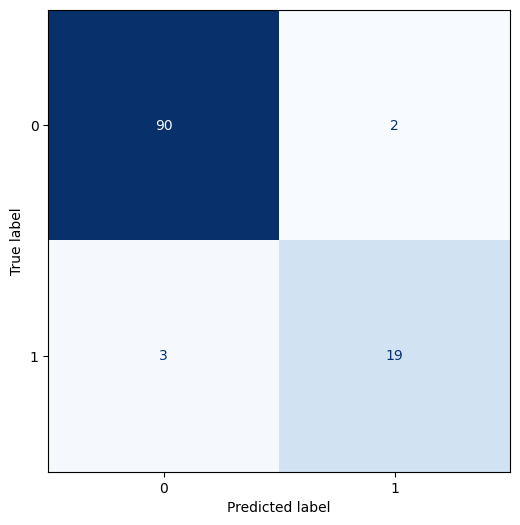

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression



#!ls -R /content/drive/MyDrive/uto/models/knn_models

#ensemble = VotingClassifier(
    #estimators=[('raw', knn_model), ('feat', pipeB)],
    #voting='soft'
#)

#param_grid_ens = {
  #'voting':   ['soft','hard'],
  #'weights':  [(w1,w2) for w1 in (1,2,3) for w2 in (1,2,3)]
#}

# 4) 5-fold outer splitter (same you’ve been using)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


stack = StackingClassifier(
    estimators      = [('raw', datapoint_pipe), ('feat', feature_pipe)],
    final_estimator = LogisticRegression(max_iter=1000, random_state=SEED),
    cv               = skf,
    passthrough     = False    # purely learns weights on the two legs
)


param_grid = {
    'final_estimator__C':        [0.01, 0.1, 1, 10],
    'passthrough':               [False, True]
}

grid = GridSearchCV(
    estimator      = stack,
    param_grid     = param_grid,
    cv             = skf,
    scoring        = make_scorer(f1_score),
    n_jobs         = -1,
    verbose        = 2,
    return_train_score = False
)
grid.fit(X_full, y)

best_stack = grid.best_estimator_
print("Grid-search best params:", grid.best_params_)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)
}
#cv_res = cross_validate(
   # best_stack, X_full, y,
   #cv=skf, scoring=scoring,
   # return_estimator=False
#)

y_pred_cv = cross_val_predict(best_stack, X_full, y, cv=skf, method='predict')

cm = confusion_matrix(y, y_pred_cv)
print("Overall 5-fold CV confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_stack.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.show()




#average_metrics = { metric: float(np.mean(cv_res[f'test_{metric}']))
                    #for metric in scoring }
#print("Average CV metrics:", average_metrics)

# ----------------------------------------
# 7) Inspect the learned weights
# ----------------------------------------
#coefs = best_stack.final_estimator_.coef_[0]
#print("Learned soft-voting weights (raw, feat):", coefs)


model_save_path="/content/drive/MyDrive/uto/ensamble_models/stack_best_model.joblib"
training_data_save_path="/content/drive/MyDrive/uto/ensamble_models/stack_training_data.json"

#save_training_data_and_model(model_save_path, training_data_save_path, best_stack, X_full)







In [ ]:
# --- 1) Prepare output folder ---
out_mis_dir = "/content/drive/MyDrive/uto/misclassified_plots"
os.makedirs(out_mis_dir, exist_ok=True)

# --- 2) Loop over folds, collect misclassified cases ---
misclassified = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_full, y), start=1):
    # clone the tuned stack and fit on the train split
    model = clone(best_stack)
    model.fit(X_full[train_idx], y[train_idx])

    # get test‐set predictions & scores
    X_test   = X_full[test_idx]
    y_true   = y[test_idx]
    y_score  = model.predict_proba(X_test)[:,1]
    y_pred   = (y_score >= 0.5).astype(int)

    # record any mismatches
    for local_i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        if yt != yp:
            global_idx = test_idx[local_i]
            misclassified.append({
                "fold": fold,
                "idx":  int(global_idx),
                "patient_id": patient_folders[global_idx],
                "true": yt,
                "pred": yp
            })

# --- 3) Print summary ---
print(f"Total misclassified cases: {len(misclassified)}")
print("Unique patient IDs:", sorted({m["patient_id"] for m in misclassified}))

# --- 4) Plot the first N misclassified curves ---
N = 8
for case in misclassified[:N]:
    idx      = case["idx"]
    pid      = case["patient_id"]
    true_lbl = case["true"]
    pred_lbl = case["pred"]

    # pull the raw & smoothed curves + time vector
    raw_curve    = orig_X_raw[idx]
    smooth_curve = orig_X_smooth[idx]
    t_vec        = orig_time_vectors[idx]

    # ensure numpy
    raw_curve    = raw_curve.detach().cpu().numpy()    if hasattr(raw_curve, "detach") else np.array(raw_curve)
    smooth_curve = smooth_curve.detach().cpu().numpy() if hasattr(smooth_curve, "detach") else np.array(smooth_curve)
    t_vec        = np.array(t_vec)

    # make the plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(t_vec, raw_curve,    alpha=0.6, label="raw")
    ax.plot(t_vec, smooth_curve, linewidth=1.5, label="smoothed")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Counts/sec")
    ax.set_title(f"true={true_lbl}  pred={pred_lbl}")
    ax.legend()

    # optionally save:
    fname = f"mis_{pid}_fold{case['fold']}.png"
    fig.savefig(os.path.join(out_mis_dir, fname), dpi=150, bbox_inches="tight")
    plt.close(fig)

print(f"Saved up to {min(N, len(misclassified))} misclassified plots to\n  {out_mis_dir}")


Total misclassified cases: 5
Unique patient IDs: [np.str_('EE3D27BE'), np.str_('EE5D0C3A'), np.str_('EEB056B3'), np.str_('EEF61EF2')]
Saved up to 5 misclassified plots to
  /content/drive/MyDrive/uto/misclassified_plots


# **Quantitative analysis**

## **Performance metric setup**

In [ ]:
import pandas as pd, glob, json
from pathlib import Path
from scipy.stats import wilcoxon


base_dir = Path('/content/drive/MyDrive/uto/models')

records = []
for path in base_dir.rglob('*.json'):
    text = path.read_text()
    data = json.loads(text)
    fold_f1s = [fold['f1'] for fold in data.get('fold_metrics', [])]  # Extract F1 scores per fold

    records.append({
        'main_group': data['main_group'],
        'subgroup':   data['subgroup'],
        'model':      data['model'],
        'hyperparams': data['hyperparameters'],
        'mean_f1':   data['average_metrics']['f1'],
        'fold_f1s': fold_f1s

    })
df = pd.DataFrame(records)

print("df", df)

df    main_group          subgroup    model  \
0   datapoint       whole_curve      svm   
1   datapoint    diuretic_phase      svm   
2     feature  domain_expertise      svm   
3     feature          combined      svm   
4     feature      related_work      svm   
5   datapoint    diuretic_phase       dt   
6   datapoint       whole_curve       dt   
7     feature  domain_expertise       dt   
8     feature      related_work       dt   
9     feature          combined       dt   
10  datapoint       whole_curve  xgboost   
11  datapoint    diuretic_phase  xgboost   
12    feature  domain_expertise  xgboost   
13    feature      related_work  xgboost   
14    feature          combined  xgboost   
15  datapoint       whole_curve       rf   
16  datapoint    diuretic_phase       rf   
17    feature  domain_expertise       rf   
18    feature      related_work       rf   
19    feature          combined       rf   
20  datapoint    diuretic_phase      knn   
21  datapoint       whole_cur

## **Best models from each group**

In [ ]:
# Pick the single best model for each main_group
best = ( df
         .sort_values('mean_f1', ascending=False)
         .groupby('main_group', as_index=False)
         .first()
       )

print(best[['main_group','subgroup','model','mean_f1']])

  main_group     subgroup model   mean_f1
0  datapoint  whole_curve   knn  0.860317
1    feature     combined    rf  0.881429


## **Datapoint subgroups analysis**

In [ ]:
#Filter to the “datapoint” main group and pivot so rows=models, cols=subgroups

pivot_dp = df[df['main_group'] == 'datapoint']


df_dp = df[df['main_group']=='datapoint']
pivot_dp = df_dp.pivot(index='model', columns='subgroup', values='mean_f1')

print("pivot_dp", pivot_dp)

# make sure your columns match exactly:
pivot_dp = pivot_dp[['whole_curve','diuretic_phase']]

print("dp", pivot_dp)

# 3) Summary stats
#summary = pivot_dp.agg(['mean','std']).T.rename_axis('subgroup')
#print(summary)


# 3) Run the paired Wilcoxon signed-rank test
f1_whole = pivot_dp['whole_curve'].values
f1_diur  = pivot_dp['diuretic_phase'].values

stat, p_val = wilcoxon(f1_whole, f1_diur)
print(f"Wilcoxon signed-rank test on 7 models: W={stat:.1f}, p={p_val:.3f}")


dp    main_group        subgroup    model  \
0   datapoint     whole_curve      svm   
1   datapoint  diuretic_phase      svm   
5   datapoint  diuretic_phase       dt   
6   datapoint     whole_curve       dt   
10  datapoint     whole_curve  xgboost   
11  datapoint  diuretic_phase  xgboost   
15  datapoint     whole_curve       rf   
16  datapoint  diuretic_phase       rf   
20  datapoint  diuretic_phase      knn   
21  datapoint     whole_curve      knn   
25  datapoint     whole_curve      cnn   
26  datapoint  diuretic_phase      cnn   
27  datapoint     whole_curve      mlp   
28  datapoint  diuretic_phase      mlp   

                                          hyperparams   mean_f1  \
0       {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}  0.761429   
1   {'svm__C': 100, 'svm__gamma': 'scale', 'svm__k...  0.756190   
5   {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...  0.628571   
6   {'max_depth': 5, 'min_samples_leaf': 2, 'min_s...  0.750519   
10  {'colsample_bytree': 0.8, '

## **Feature subgroups analysis**

In [ ]:
from scipy.stats import friedmanchisquare
from itertools      import combinations

# 1) Pivot your df to get one row per model, columns=subgroups
df_feat = df[df['main_group']=='feature']
pivot_feat = df_feat.pivot(index='model',
                           columns='subgroup',
                           values='mean_f1')

print("pivot_feat", pivot_feat)

# make sure the columns are in the right order:
pivot_feat = pivot_feat[[
    'domain_expertise',
    'related_work',
    'combined'
]]

print("pivot feat ordered", pivot_feat)

# 3) Summary stats
summary = pivot_feat.agg(['mean','std']).T.rename_axis('subgroup')
print(summary)

# 2) Friedman test across the three
stat_f, p_f = friedmanchisquare(
    pivot_feat['domain_expertise'],
    pivot_feat['related_work'],
    pivot_feat['combined']
)
print(f"Friedman χ²={stat_f:.2f}, p={p_f:.3f}")

# 3) If p_f < 0.05, do pairwise Wilcoxon with Bonferroni
if p_f < 0.05:
    alpha = 0.05
    m = 3  # number of pairwise tests
    for a, b in combinations(pivot_feat.columns, 2):
        stat_w, p_w = wilcoxon(pivot_feat[a], pivot_feat[b])
        p_corr = min(p_w * m, 1.0)
        print(f"{a} vs {b}: W={stat_w:.1f}, raw p={p_w:.3f}, Bonferroni p={p_corr:.3f}")
else:
    print("No overall difference (Friedman p >= 0.05), skip post-hoc.")

pivot_feat subgroup  combined  domain_expertise  related_work
model                                             
dt        0.619264          0.827778      0.698788
knn       0.787302          0.814358      0.838095
mlp       0.241905          0.663917      0.208571
rf        0.881429          0.827778      0.869524
svm       0.749206          0.826263      0.804762
xgboost   0.866883          0.790426      0.820130
pivot feat ordered subgroup  domain_expertise  related_work  combined
model                                             
dt                0.827778      0.698788  0.619264
knn               0.814358      0.838095  0.787302
mlp               0.663917      0.208571  0.241905
rf                0.827778      0.869524  0.881429
svm               0.826263      0.804762  0.749206
xgboost           0.790426      0.820130  0.866883
                      mean       std
subgroup                            
domain_expertise  0.791753  0.064251
related_work      0.706645  0.250780
combin

## **Main group analysis**

In [ ]:
# 1a) Best F1 PER model within each main_group
best_dp   = df[df['main_group']=='datapoint'] .groupby('model')['mean_f1'].max()
best_feat = df[df['main_group']=='feature']   .groupby('model')['mean_f1'].max()

#print("best_dp", best_dp)

# 1b) Align them in one DataFrame
compare = pd.concat([best_dp, best_feat], axis=1, keys=['datapoint','feature'])
compare = compare.dropna()   # if any model is missing one group
print(compare)

dp_vals   = compare['datapoint'].values
feat_vals = compare['feature'].values

stat, p_val = wilcoxon(dp_vals, feat_vals)
print(f"Wilcoxon W={stat:.1f}, p={p_val:.3f}")

summary = compare.agg(['mean','std']).T.rename_axis('main_group')
print(summary)

         datapoint   feature
model                       
dt        0.750519  0.827778
knn       0.860317  0.838095
mlp       0.831429  0.663917
rf        0.810317  0.881429
svm       0.761429  0.826263
xgboost   0.810000  0.866883
Wilcoxon W=7.0, p=0.562
                mean       std
main_group                    
datapoint   0.804002  0.041647
feature     0.817394  0.078383


## **Explainability**

### **Decision Tree**

In [ ]:
feature_names = [
    # Temporal Features
    "Left Time to Peak", "Left Peak Value", "Left AUC", "Left Rising Slope", "Left Recovery Time",
    "Right Time to Peak", "Right Peak Value", "Right AUC", "Right Rising Slope", "Right Recovery Time",

    # Statistical Features
    "Left Mean", "Left Variance", "Left Skewness", "Left Kurtosis",
    "Right Mean", "Right Variance", "Right Skewness", "Right Kurtosis"
]

feature_names_total = [
     "Mean", "Variance", "Skewness", "Kurtosis",
]


assert len(feature_names_total) == X_features.shape[1], f"Mismatch: {len(feature_names_total)} names vs {X_features.shape[1]} features"


# Initialize SHAP Explainer
explainer = shap.Explainer(best_model, X_features)

# Compute SHAP values for the dataset
shap_values = explainer(X_features)

# Extract SHAP values for class 1 ("Sick")


#print("shap values", shap_values)

# Convert SHAP values to a format that includes feature names
#shap_values.feature_names = feature_names_total  # Set feature names manually


# Bar plot for global feature importance (No feature_names argument needed)
#shap.plots.bar(shap_values)


# Select a random patient sample
patient_index = 7  # Change this index as needed
patient_features = X_features[patient_index].reshape(1, -1)

print("patient_features", patient_features)

# Compute SHAP values for this specific patient
shap_values_patient = explainer(patient_features)

print("shap_values_patient", shap_values_patient)


# Ensure feature names are attached to SHAP values
shap_values_patient.feature_names = feature_names_total  # Assign feature names manually


# Waterfall plot with feature names
shap.plots.waterfall(shap_values_patient[0])


# Get the SHAP values for this patient
shap_values_array = shap_values_patient.values[0]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names_total, shap_values_array, color="skyblue")
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.title(f"Feature Importance for Patient {patient_index}")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()




NameError: name 'X_features' is not defined

### **Support Vector Machine**

svm_classes [0 1]
X_train [-1.2260281  -0.83043841  0.45441324 -0.17118202 -0.62435559 -0.77625554
  0.85311709 -0.59620298 -0.03737055 -0.26211045]
single renogram [[-1.2260281  -0.83043841  0.45441324 -0.17118202 -0.62435559 -0.77625554
   0.85311709 -0.59620298 -0.03737055 -0.26211045]]
raw renogram [[ 9.20358429e+01  4.55142480e+03  4.90232378e-01 -2.29966402e-01
   2.00000000e+02  3.53730738e-01  4.60000000e+02  0.00000000e+00
   3.05566519e-01  3.16434979e-01]]


  0%|          | 0/1 [00:00<?, ?it/s]

predicted_class 0
shap values for predicted class [-0.0094658  -0.01428261  0.03122644  0.02739177  0.08902688  0.02963265
  0.          0.0021368  -0.00651517 -0.00894866]
Base values for predicted class 0.7994219570401342


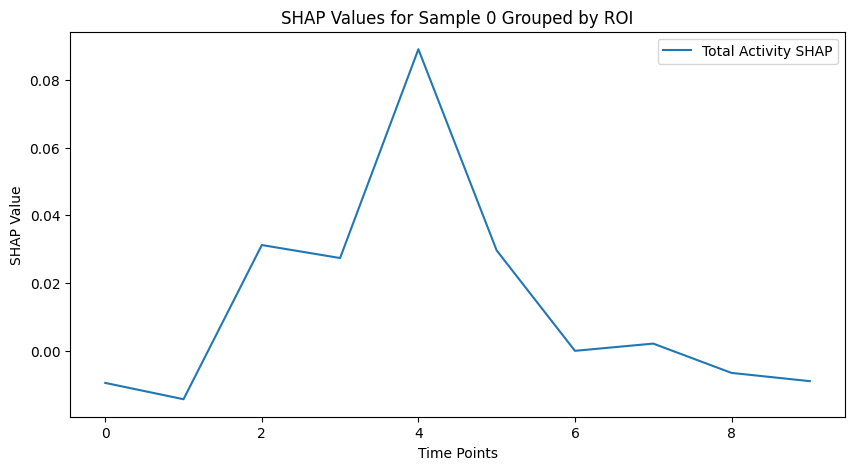

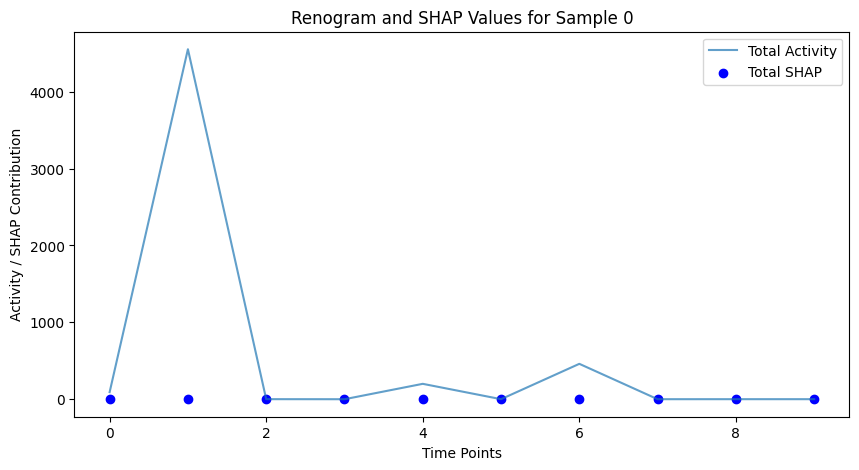

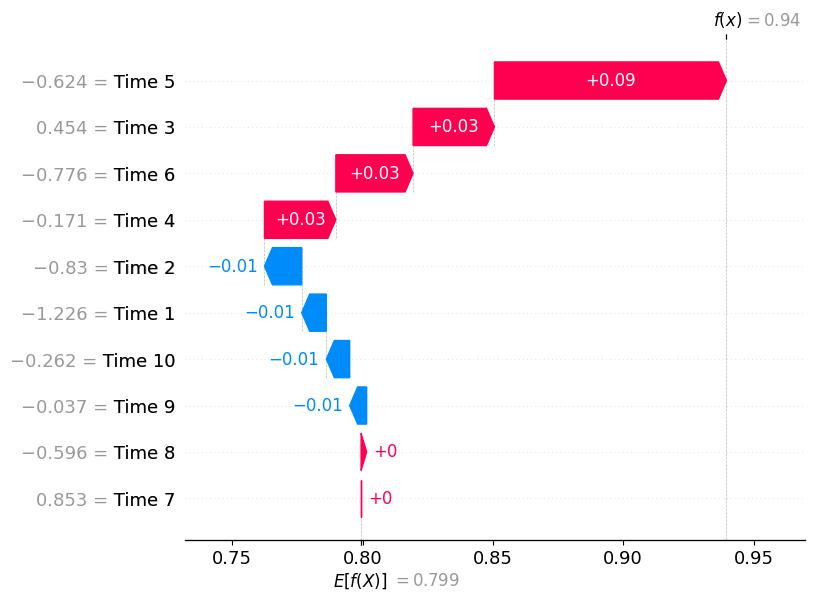

In [ ]:

# Define the number of time points in each ROI

print("svm_classes", best_svm_model.classes_)  # This will tell you the class order

# Initialize SHAP explainer

explainer = shap.KernelExplainer(best_svm_model.predict_proba, X_train)

print("X_train", X_train[0])

#Index is patient id
single_renogram = X_train[0].reshape(1, -1)

print("single renogram", single_renogram)

raw_renogram = scaler.inverse_transform(single_renogram)

print("raw renogram", raw_renogram)

# Compute SHAP values for validation data
shap_values = explainer(single_renogram)


predicted_class = best_svm_model.predict(single_renogram)[0]

shap_values_for_predicted_class = shap_values.values[:, :, predicted_class][0]

base_values_for_predicted_class = shap_values.base_values[:, predicted_class][0]

print("predicted_class", predicted_class)

print("shap values for predicted class", shap_values_for_predicted_class)
print("Base values for predicted class", base_values_for_predicted_class)



# Plot SHAP values for each ROI
plt.figure(figsize=(10, 5))
plt.plot(shap_values_for_predicted_class, label="Total Activity SHAP")
plt.xlabel("Time Points")
plt.ylabel("SHAP Value")
plt.legend()
plt.title(f"SHAP Values for Sample 0 Grouped by ROI")
plt.show()

# Overlay SHAP values on the renogram
plt.figure(figsize=(10, 5))
plt.plot(raw_renogram[0], label="Total Activity", alpha=0.7)
plt.scatter(range(single_renogram.size), shap_values_for_predicted_class, color='blue', label="Total SHAP")
plt.xlabel("Time Points")
plt.ylabel("Activity / SHAP Contribution")
plt.legend()
plt.title(f"Renogram and SHAP Values for Sample 0")
plt.show()

# Waterfall plot for a single prediction
shap.waterfall_plot(shap.Explanation(values=shap_values_for_predicted_class,
                                     base_values=base_values_for_predicted_class,
                                     data=single_renogram[0],
                                     feature_names=[f"Time {i+1}" for i in range(raw_renogram.size)]))





### **Random Forest**

In [ ]:
feature_names_total = [
     "Mean", "Variance", "Skewness", "Kurtosis",
]

explainer = shap.Explainer(best_rf_model, X_features)
#shap_values = explainer(X_features)

shap_values = explainer(X_features)

shap.summary_plot(shap_values[:,:, 0], X_features, feature_names=["Mean", "Variance", "Skewness", "Kurtosis"])



NameError: name 'shap' is not defined

# **Global XAI**

## **Best feature model**

rf_feats ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'C_last', 'Slope_0_5_min', 'Slope_15_20_min', 'Length', 'Time to peek', 'Peek to half peak', 'Diuretic T1/2', '30min/peak', '30min/3min', 'Split Function']
All classes: [0 1]
Positive (index 1): 1
X_scaled shape: (114, 14)
[(14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (14, 2), (1

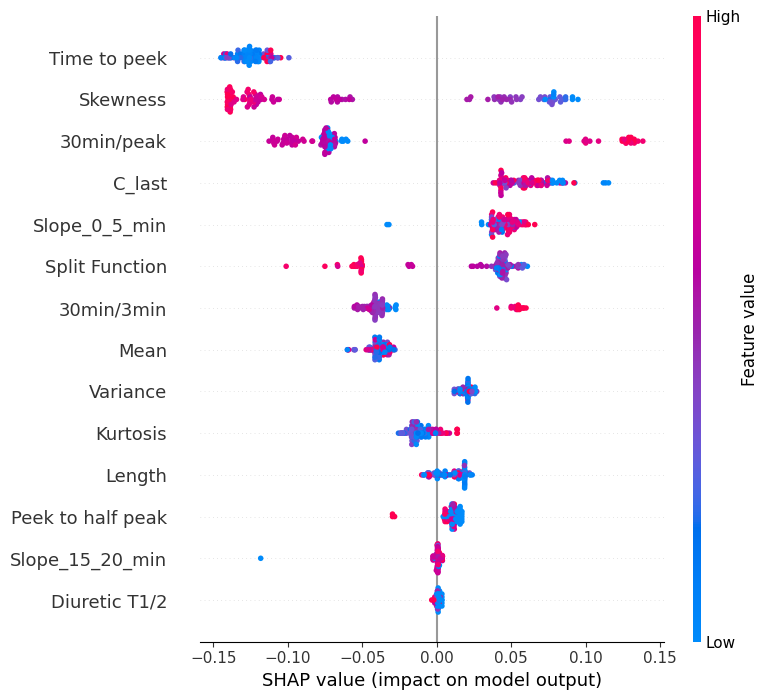

In [ ]:
# Hent ut modell og treningsdata fra googe disk

# Legg på SHAP

# Akkumuler SHAP verdier til



import shap
import numpy as np


# Suppose your 13 metrics really mean:


rf_feats = [
    "Mean", "Variance", "Skewness", "Kurtosis",
    "C_last", "Slope_0_5_min", "Slope_15_20_min",
    "Length", "Time to peek", "Peek to half peak",
    "Diuretic T1/2", "30min/peak", "30min/3min", "Split Function"
]

print("rf_feats", rf_feats)

# 1) Pull the RF bits out of your pipeline
rf_scaler = pipeB.named_steps['scale']
rf_clf    = pipeB.named_steps['clf']

# assume `rf` is your trained RandomForestClassifier
print("All classes:", rf_clf.classes_)
print("Positive (index 1):", rf_clf.classes_[1])

# 2) (Re-)fit the scaler on your raw 13-dim training data
rf_scaler.fit(feature_data)
X_scaled = rf_scaler.transform(feature_data)
print("X_scaled shape:", X_scaled.shape)   # → (n_samples, 13)

# 3) Build the TreeExplainer on the raw RandomForestClassifier
explainer_rf = shap.TreeExplainer(rf_clf)

# 4) Compute SHAP values for both classes
shap_vals = explainer_rf.shap_values(X_scaled)
print([v.shape for v in shap_vals])


# (re-)fit & transform exactly as before
rf_scaler.fit(feature_data)
X_scaled = rf_scaler.transform(feature_data)

# build the explainer on the raw RF
explainer_rf   = shap.TreeExplainer(rf_clf)

# this is a list of length n_samples, each array (13,2)
shap_vals_list = explainer_rf.shap_values(X_scaled)

# stack into shape (n_samples, n_features, n_classes)
shap_arr = np.stack(shap_vals_list, axis=0)

# now pick the positive‐class slice → shape (n_samples, 13)
sv_pos = shap_arr[:, :, 1]

print("sv_pos shape:", sv_pos.shape)    # should be (114,13)
print("X_scaled shape:", X_scaled.shape) # (114,13)

# final bar-chart of global importances
shap.summary_plot(
    sv_pos,
    X_scaled,
    feature_names=rf_feats,
    max_display=len(rf_feats)
)


## **Best datapoint model**

In [ ]:
from scipy.special import logit

time_feats = [f"time_{i}" for i in range(n_curve)]

curves = datapoint_data

bg_idx     = np.random.RandomState(42).choice(len(datapoint_data), 110, replace=False)
bg_curves  = datapoint_data[bg_idx]

explainer_knn = shap.KernelExplainer(
    lambda X: knn_model.predict_proba(X)[:,1],
    bg_curves
)


shap_pos = explainer_knn.shap_values(datapoint_data, nsamples=2000)

print("shap_pos.shape:", shap_pos.shape)
print("bin_idx.shape:", bin_idx.shape)


# 2) Compute per-frame average |SHAP|
abs_shap        = np.abs(shap_pos)
mean_per_frame  = abs_shap.mean(axis=0)

# 3) Compute per-frame mean time from your T array
#    (T is shape (n_samples, n_curve))
T = np.load(knn_timevecs_path)
T = np.asarray(T)
mean_times = T.mean(axis=0)                # ⇒ (n_curve,)
print("mean_times shape:", mean_times.shape)

BIN_SIZE = 3

t_min, t_max = mean_times.min(), mean_times.max()
edges = np.arange(t_min, t_max + BIN_SIZE, BIN_SIZE)

# 5) Assign each of the 220 frames to a bin based on its mean timestamp
#    np.digitize gives bin indices in 1…len(edges), so subtract 1 to get 0-based
bin_idx = np.digitize(mean_times, edges, right=False) - 1

# 6) Aggregate the mean SHAP within each bin
bin_shap = []
for i in range(len(edges)-1):
    mask = (bin_idx == i)
    if not mask.any():
        continue
    bin_shap.append({
        "interval_s":  (edges[i], edges[i+1]),
        "mean_SHAP":   mean_per_frame[mask].mean(),
        "n_frames":    int(mask.sum())
    })

# 7) Sort bins by descending importance
bin_shap.sort(key=lambda x: x["mean_SHAP"], reverse=True)

# 8) Print out the top intervals
for b in bin_shap:
    start, end = b["interval_s"]
    print(f"{start:.0f}–{end:.0f}min: mean|SHAP|={b['mean_SHAP']:.4f} over {b['n_frames']} frames")





  0%|          | 0/114 [00:00<?, ?it/s]

shap_pos.shape: (114, 220)
bin_idx.shape: (220,)
mean_times shape: (220,)
3–6min: mean|SHAP|=0.0036 over 18 frames
33–36min: mean|SHAP|=0.0029 over 18 frames
0–3min: mean|SHAP|=0.0026 over 19 frames
30–33min: mean|SHAP|=0.0023 over 18 frames
27–30min: mean|SHAP|=0.0013 over 18 frames
24–27min: mean|SHAP|=0.0010 over 19 frames
6–9min: mean|SHAP|=0.0008 over 19 frames
9–12min: mean|SHAP|=0.0008 over 18 frames
21–24min: mean|SHAP|=0.0007 over 18 frames
18–21min: mean|SHAP|=0.0005 over 18 frames
15–18min: mean|SHAP|=0.0004 over 19 frames
12–15min: mean|SHAP|=0.0004 over 18 frames


### **Bar plot**

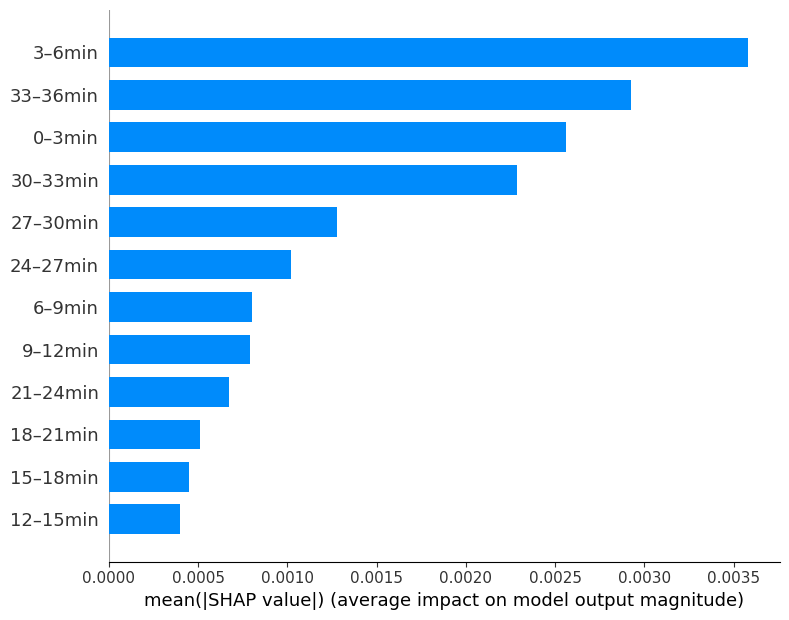

In [ ]:
# Extract labels & values
labels = [
    f"{int(start)}–{int(end)}min"
    for start,end in (b["interval_s"] for b in bin_shap)
]

global_shap = np.array([ b["mean_SHAP"] for b in bin_shap ])  # shape (n_bins,)

shap_vals_2d = global_shap[np.newaxis, :]                       # now shape (1, n_bins)


shap.summary_plot(
    shap_vals_2d,
    feature_names=labels,
    plot_type="bar",
    max_display=len(labels)   # show all bins
)


# bar‐plot
#shap.summary_plot(
   # shap_pos,
   # features=values,
   # feature_names=labels,
   # plot_type="bar",
#)


#plt.figure()
#plt.bar(labels, values)
#plt.xticks(rotation=45, ha="right")
#plt.ylabel("Mean |SHAP|")
#plt.title("2-min interval importances")
#plt.tight_layout()
#plt.show()


### **Bee swarm plot**

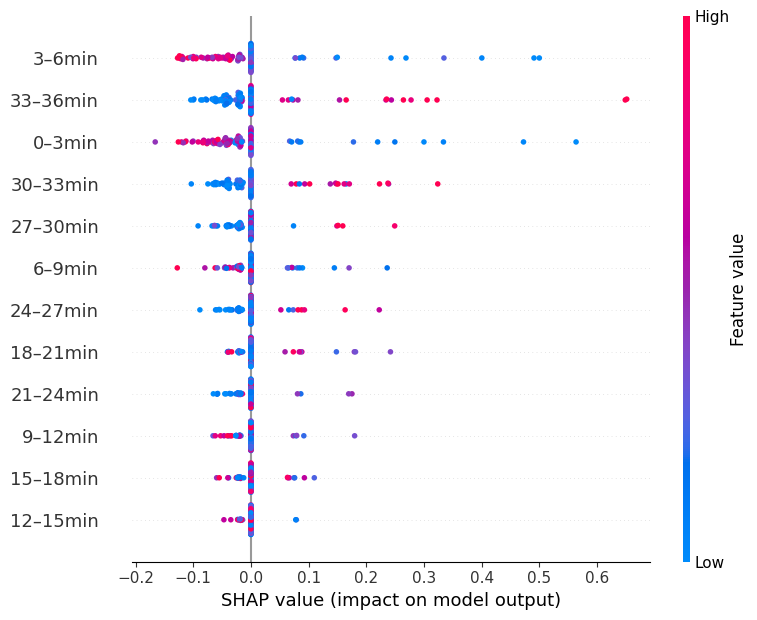

In [ ]:
n_bins = len(edges) - 1
n_samples = shap_pos.shape[0]

# Labels for each bin
bin_labels = [
    f"{int(edges[i])}–{int(edges[i+1])}min"
    for i in range(n_bins)
]


sample_bin_signed = np.zeros((n_samples, n_bins))
for b in range(n_bins):
    mask = (bin_idx == b)
    if mask.any():
        # mean SHAP (with sign) of all frames in bin b, per sample
        sample_bin_signed[:, b] = shap_pos[:, mask].sum(axis=1)


# 2) Build the corresponding per-sample, per-bin FEATURE matrix:
#    here we take the *raw* curve values in each bin and average them
sample_bin_feat = np.zeros((n_samples, n_bins))
for b in range(n_bins):
    mask = (bin_idx == b)
    if mask.any():
        sample_bin_feat[:, b] = datapoint_data[:, mask].mean(axis=1)

# Pass the 2-D array as “shap_values” and a DataFrame (or list) for feature names:
shap.summary_plot(
    sample_bin_signed,
    sample_bin_feat,    # raw feature values (same shape), used for coloring
    feature_names=bin_labels,
    plot_type="dot"   # the classic beeswarm
)

## **Dependency plot**

Top bins: [('0–3min', 0), ('3–6min', 1), ('6–9min', 2)]


<Figure size 600x400 with 0 Axes>

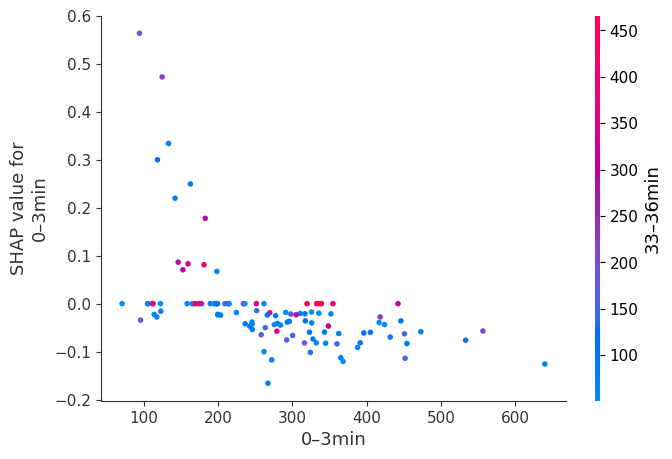

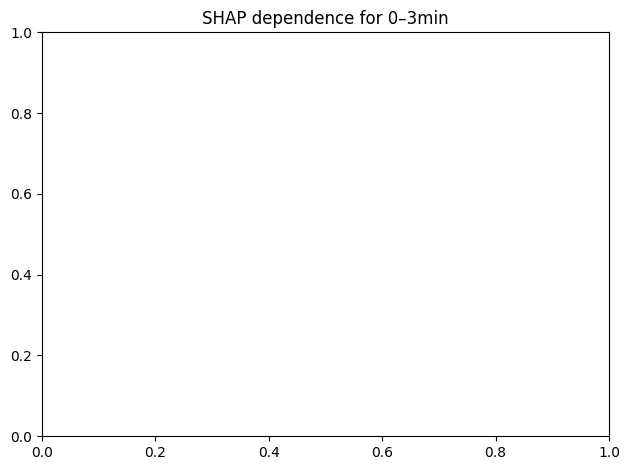

<Figure size 600x400 with 0 Axes>

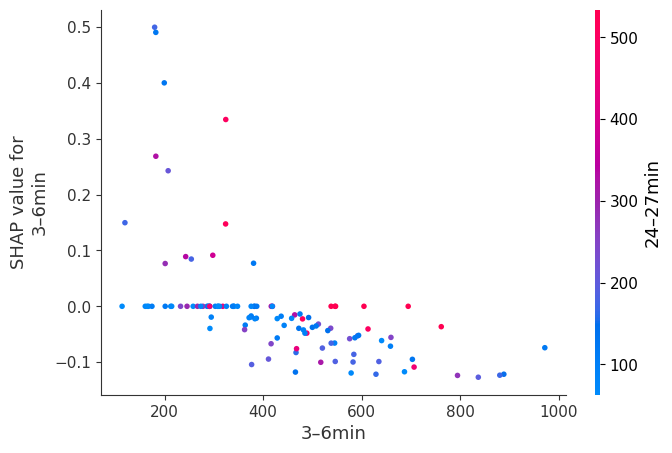

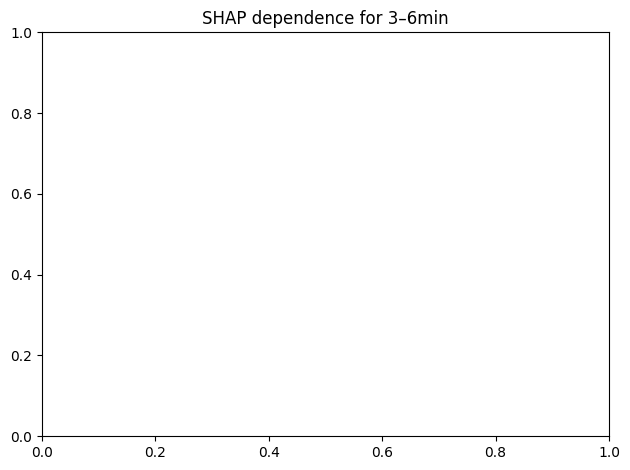

<Figure size 600x400 with 0 Axes>

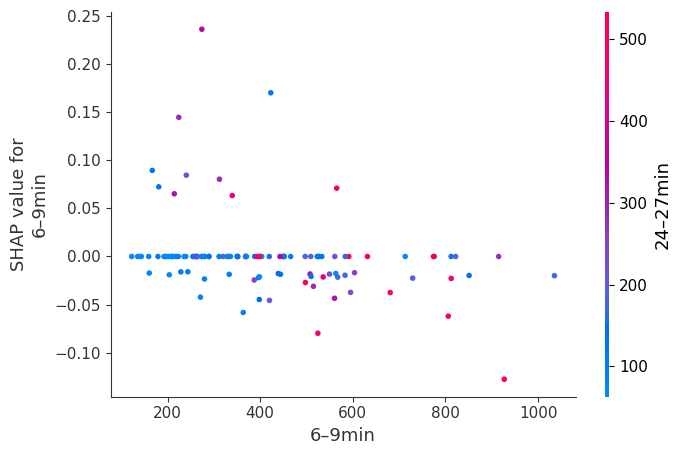

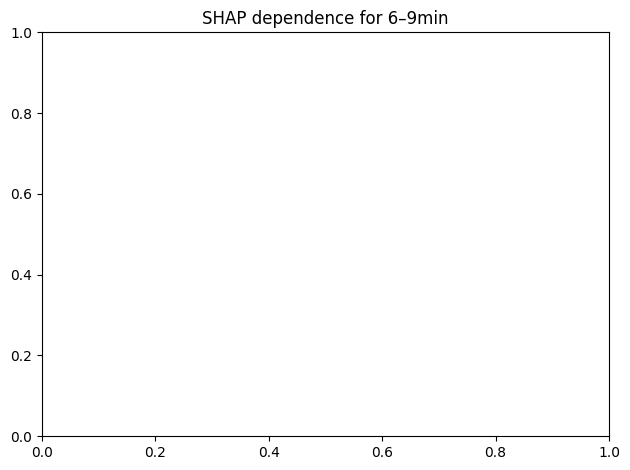

In [ ]:
# get the top-3 bin indices
top_bins = [i for i,_ in sorted(
    enumerate(bin_shap),
    key=lambda x: x[1]["mean_SHAP"],
    reverse=True
)[:3]]
print("Top bins:", [(bin_labels[i], i) for i in top_bins])


for idx in top_bins:
    plt.figure(figsize=(6,4))
    shap.dependence_plot(
      idx,
      sample_bin_signed,
      sample_bin_feat,
      feature_names=bin_labels,
      interaction_index="auto"
  )
    plt.title(f"SHAP dependence for {bin_labels[idx]}")
    plt.tight_layout()




## **Interactions**

In [ ]:
X_sample = datapoint_data[np.random.RandomState(42).choice(len(datapoint_data), 110, replace=False)]

# for KNN—with kernel explainer
shap_inter = explainer_knn.shap_interaction_values(X_sample)

AttributeError: 'KernelExplainer' object has no attribute 'shap_interaction_values'

## **Ensamble model**

### **Setup**

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression



rf_feats = [
    "Mean", "Variance", "Skewness", "Kurtosis",
    "C_last", "Slope_0_5_min", "Slope_15_20_min",
    "Length", "Time to peek", "Peek to half peak",
    "Diuretic T1/2", "30min/peak", "30min/3min", "Split Function"
]

bg_idx = np.random.RandomState(SEED).choice(len(X_full), 110, replace=False)
explainer_ens = shap.KernelExplainer(
    lambda X: ens_stack_model.predict_proba(X)[:,1],
    X_full[bg_idx]
)
shap_vals = explainer_ens.shap_values(X_full, nsamples=2000)


# 3) Split into raw‐curve vs RF parts
n_curve     = datapoint_data.shape[1]
shap_curves = shap_vals[:, :n_curve]
shap_rf     = shap_vals[:, n_curve:]

# 4) Bin the 220 time‐points into 2-min windows
T = np.load(knn_timevecs_path)
mean_times = T.mean(axis=0)
edges = np.arange(mean_times.min(), mean_times.max()+2, 3)
bin_idx    = np.digitize(mean_times, edges) - 1
n_bins     = len(edges)-1

# 5) Aggregate SHAP per bin (sum across frames)
shap_bins = np.zeros((len(X_full), n_bins))
for b in range(n_bins):
    mask = (bin_idx == b)
    if mask.any():
        shap_bins[:, b] = shap_curves[:, mask].sum(axis=1)

# 6) Also compute your “binned feature values” for coloring
feat_bins = np.zeros((len(X_full), n_bins))
for b in range(n_bins):
    mask = (bin_idx == b)
    if mask.any():
        feat_bins[:, b] = datapoint_data[:, mask].mean(axis=1)

# 7) Stack together and build feature names
X_agg_shap = np.hstack([shap_bins, shap_rf])
X_agg_feat = np.hstack([feat_bins, feature_data])

bin_labels = [f"{int(edges[i])}–{int(edges[i+1])}min"
              for i in range(n_bins)]
rf_labels  = rf_feats
all_labels = bin_labels + rf_labels


  0%|          | 0/114 [00:00<?, ?it/s]

### **Bar plot**

<ipython-input-73-8d810ad9ed13>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


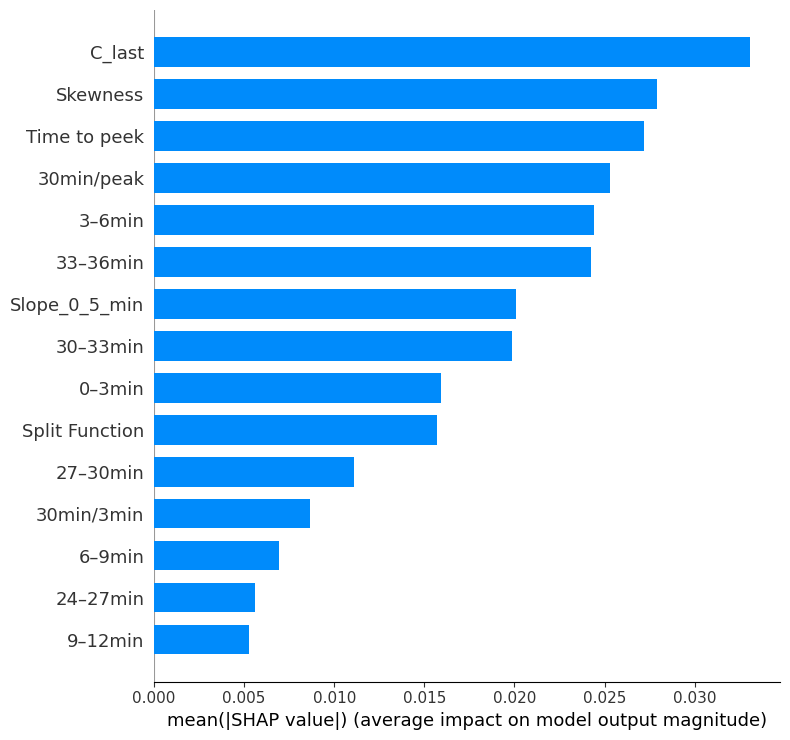

RF baseline: 0.20984474095380687 Ensemble baseline: 0.21127822767531115


In [ ]:
shap.summary_plot(
    X_agg_shap,
    features       = X_agg_feat,
    feature_names  = all_labels,
    plot_type      = "bar",
    max_display    = 15
)


mean_rf  = np.mean(rf_model.predict_proba(feature_data)[:,1])
mean_ens = np.mean(ens_model.predict_proba(X_full[bg_idx])[:,1])
print("RF baseline:", mean_rf, "Ensemble baseline:", mean_ens)

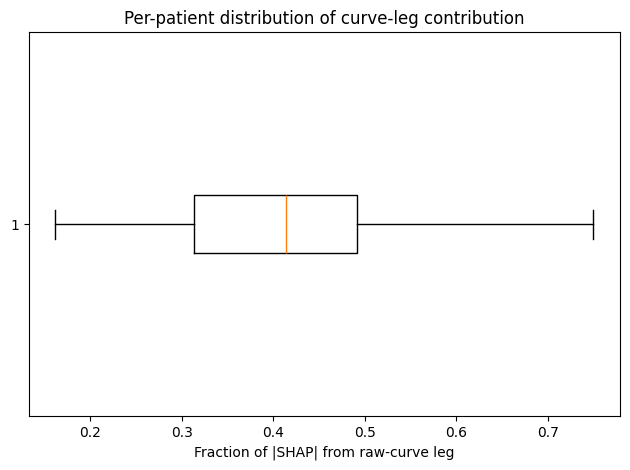

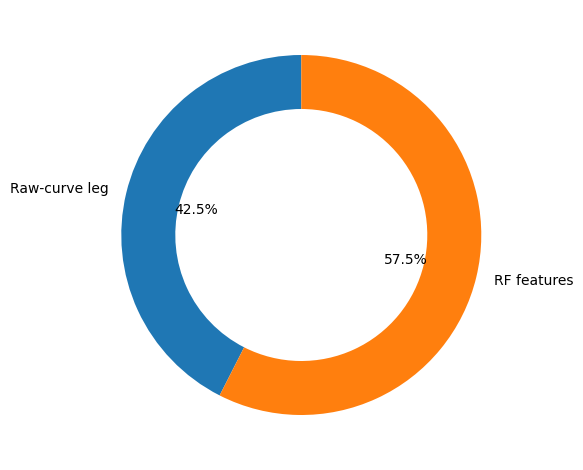

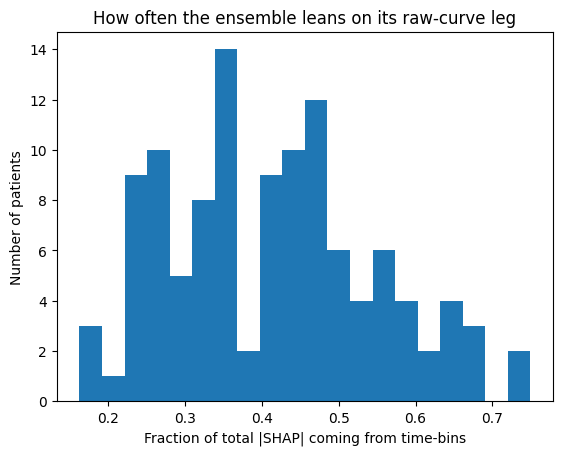

Overall raw‐curve vs RF contribution: 0.42506583945082127 0.5749341605491788


In [ ]:
# shap_vals is your full (n_samples, n_bins+14) array
#shap_bins = np.abs(shap_vals[:, :n_bins]).sum(axis=1)
#shap_rf   = np.abs(shap_vals[:, n_bins:]).sum(axis=1)

#frac_bin = shap_bins / (shap_bins + shap_rf)

# 1) Histogram of how often the bins matter:
#plt.figure()
#plt.hist(frac_bin, bins=20)
#plt.xlabel("Fraction of total |SHAP| coming from time-bins")
#plt.ylabel("Number of patients")
#plt.title("How often the ensemble leans on its raw-curve leg")
#plt.show()

# 2) Find “bin-dominated” cases (e.g. frac_bin > 0.5)
#idx = np.where(frac_bin > 0.1)[0]
#print(f"{len(idx)} patients where time-bins explain more than half the total SHAP.")

#print("Avg raw‐curve contribution:", frac_bin.mean())

#plt.step(np.sort(frac_bin), np.linspace(0,1,len(frac_bin)))


#total_bins = shap_bins.sum()
##total_rf   = shap_rf.sum()
#print("Overall raw‐curve vs RF contribution:",
      #total_bins/(total_bins+total_rf),
     # total_rf/(total_bins+total_rf))



raw_mass = np.sum(np.abs(shap_bins), axis=1)
rf_mass  = np.sum(np.abs(shap_rf), axis=1)
frac_curve = raw_mass / (raw_mass + rf_mass)

# —— Boxplot —— #
plt.figure()
plt.boxplot(frac_curve, vert=False)
plt.xlabel("Fraction of |SHAP| from raw-curve leg")
plt.title("Per-patient distribution of curve-leg contribution")
plt.tight_layout()
plt.show()


# —— Donut chart —— #
total_raw = raw_mass.sum()
total_rf  = rf_mass.sum()
sizes     = [total_raw, total_rf]
labels    = ["Raw-curve leg", "RF features"]

fig, ax = plt.subplots()
ax.pie(sizes,
       labels=labels,
       autopct="%1.1f%%",
       startangle=90,
       wedgeprops={"width": 0.3})
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


# Histogram of how often the bins matter:
plt.figure()
plt.hist(frac_curve, bins=20)
plt.xlabel("Fraction of total |SHAP| coming from time-bins")
plt.ylabel("Number of patients")
plt.title("How often the ensemble leans on its raw-curve leg")
plt.show()


total_bins = raw_mass.sum()
total_rf   = rf_mass.sum()
print("Overall raw‐curve vs RF contribution:",
      total_bins/(total_bins+total_rf),
      total_rf/(total_bins+total_rf))



### **Dot plot**

<ipython-input-58-80615dcd0c45>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


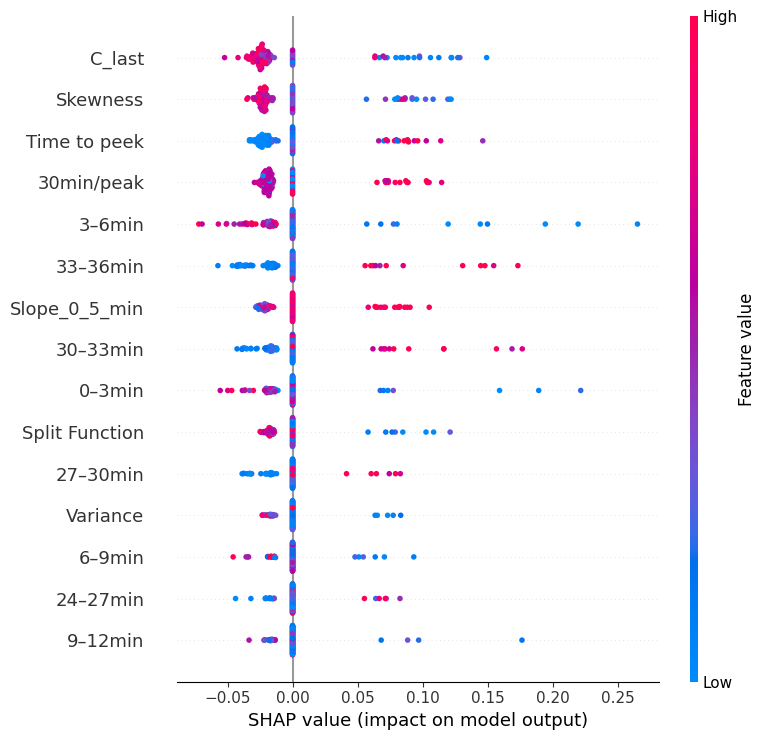

In [ ]:
shap.summary_plot(
    X_agg_shap,
    features       = X_agg_feat,
    feature_names  = all_labels,
    plot_type      = "dot",
    max_display    = 15
)